In [123]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN, MeanShift, AffinityPropagation, SpectralClustering, AgglomerativeClustering, Birch, HDBSCAN, OPTICS
from google.colab import drive
from sklearn.metrics import silhouette_score, davies_bouldin_score, v_measure_score, mean_squared_error, mean_absolute_error
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from sklearn.mixture import GaussianMixture

In [3]:
# @title Функции

def top_to_user(k: int, n=10) -> pd.DataFrame:
    user_id = k
    correlations_for_user = correlation_matrix[user_id]
    top_10_users = correlations_for_user.sort_values(ascending=False)[1:n+1]
    return top_10_users

def create_tables(n=999999, k=999999) -> pd.DataFrame:

    drive.mount('/content/drive')

    movie_tags = pd.read_csv('/content/drive/MyDrive/ml-latest/genome-scores.csv', low_memory=False)
    movie_tags = movie_tags[movie_tags['movieId'] < n]

    tags = pd.read_csv('/content/drive/MyDrive/ml-latest/genome-tags.csv', low_memory=False)
    movie_tags = pd.merge(movie_tags, tags, on='tagId', how='left')

    movies = pd.read_csv('/content/drive/MyDrive/ml-latest/links.csv', low_memory=False)
    movies = movies[movies['movieId'] < n]

    movie_details = pd.read_csv('/content/drive/MyDrive/ml-latest/movies.csv', low_memory=False)
    movie_details = movie_details[movie_details['movieId'] < n]
    movie_details['genres'] = movie_details['genres'].str.replace('|', ' ', regex=False)
    movie_details['first_genre'] = movie_details['genres'].str.split().str[0]
    movie_details = movie_details[['movieId', 'title', 'genres', 'first_genre']]

    ratings = pd.read_csv('/content/drive/MyDrive/ml-latest/ratings.csv', low_memory=False)
    ratings['date'] = pd.to_datetime(ratings['timestamp'], unit='s').dt.strftime('%Y-%m-%d')
    ratings = ratings[ratings['movieId'] < n]
    ratings = ratings[ratings['userId'] < k]
    ratings = pd.merge(movie_details[['movieId', 'title']], ratings, on='movieId', how='inner')
    ratings = ratings[['userId', 'movieId', 'title', 'rating', 'timestamp', 'date']]

    ratings_matrix = ratings.pivot_table(index='title', columns='userId', values='rating').fillna(0)
    correlation_matrix = ratings_matrix.corr()

    movie_ratings = ratings.groupby('movieId').agg(
        average_rating=('rating', 'mean'),
        vote_count=('rating', 'count')
    ).reset_index()
    movie_ratings = pd.merge(movie_details[['movieId', 'title']], movie_ratings, on='movieId', how='inner')

    user_tags = pd.read_csv('/content/drive/MyDrive/ml-latest/tags.csv', low_memory=False)
    user_tags['date'] = pd.to_datetime(user_tags['timestamp'], unit='s').dt.strftime('%Y-%m-%d')
    user_tags = user_tags[user_tags['movieId'] < n]
    user_tags = user_tags[user_tags['userId'] < k]

    return ratings_matrix, correlation_matrix, tags, movie_tags, movies, movie_details, ratings, movie_ratings, user_tags

In [4]:
ratings_matrix, correlation_matrix, tags, movie_tags, movies, movie_details, ratings, movie_ratings, user_tags = create_tables(n=1000, k=1000)

Mounted at /content/drive


In [5]:
movie_tags_count = movie_tags.groupby('movieId').size().reset_index(name='tag_count')
movie_ratings = movie_ratings[['movieId', 'average_rating']]
movie_data = movie_tags_count.merge(movie_ratings, on='movieId')

scaler = StandardScaler()
movie_data_scaled = scaler.fit_transform(movie_data[['tag_count', 'average_rating']])

### 1. **K-means**


**Где применять:**  
- **Когда работает хорошо:** Для больших данных, где количество кластеров заранее известно. K-means — это быстрый и эффективный метод для кластеризации, если данные имеют четкую структуру и линейные границы между кластерами.Если нам нужно сгруппировать фильмы по жанрам или другим характеристикам, например, на основе их меток в `movie_tags` или средних рейтингов в `movie_ratings`. Также подходит, если мы хотим кластеризовать пользователей, основываясь на их средних оценках (в данных `ratings`).
- **Где плохо применять:** Если данные имеют сложную, нелинейную структуру, и кластеров много (или их трудно предсказать). Также плохо работает с выбросами и в случае, когда кластеры сильно различаются по плотности. В случае с кластеризацией фильмов с редкими или неочевидными тегами или жанрами, где кластеры имеют сложные формы. Например, если фильмы представляют собой смесь жанров, метод может не сработать хорошо, так как K-means предполагает, что кластеры имеют округлую (шарообразную) форму.
- **Не применять:** Для сильно нерегулярных или сильно перекрывающихся данных (например, при рекомендациях для пользователей с весьма разнообразными интересами, если нет четкого разделения). Для данных с большим количеством выбросов, например, если один фильм имеет очень низкий рейтинг, что может повлиять на формирование кластеров.
  
**Тип данных:** Числовые данные, где каждый объект можно представить как вектор признаков. Кластеризация фильмов по тегам из `movie_tags`, или по жанрам из `movie_details`, или пользователей по их оценкам из `ratings`.

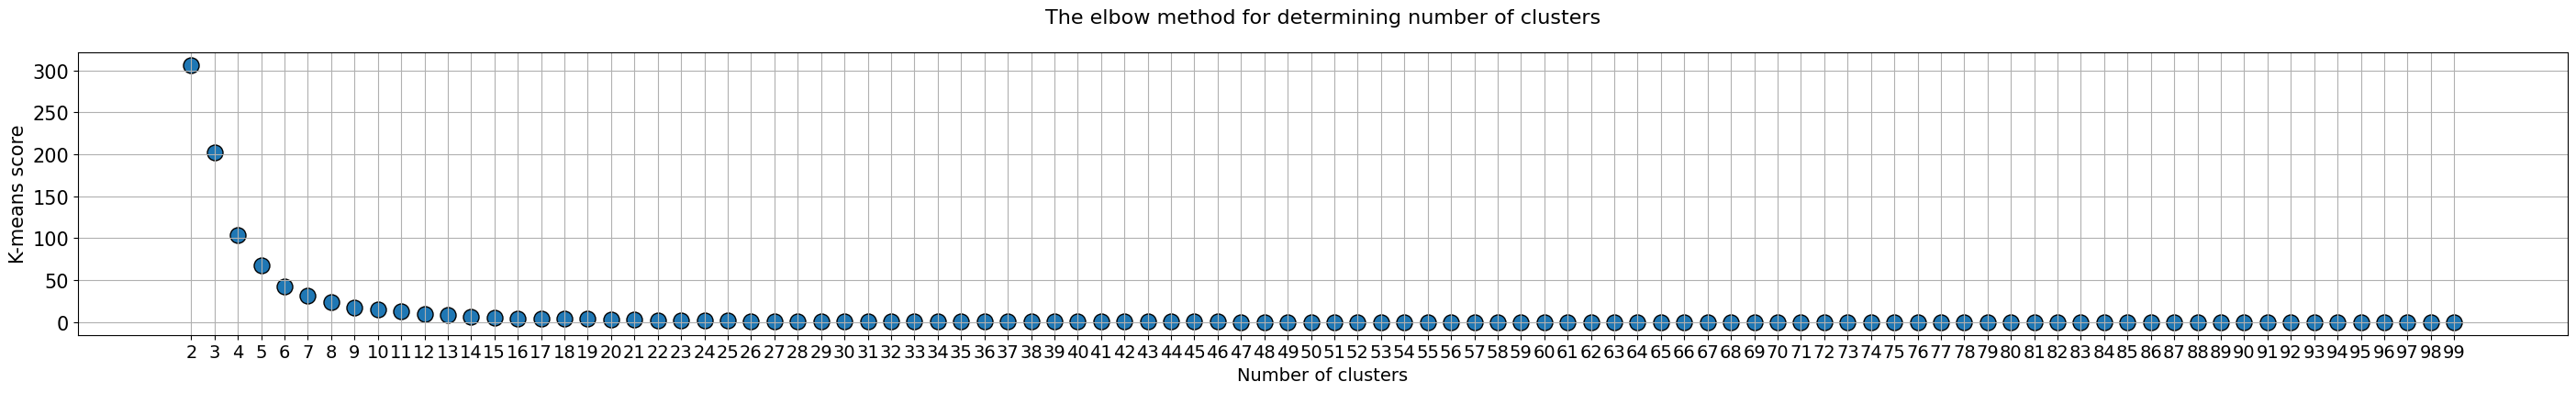

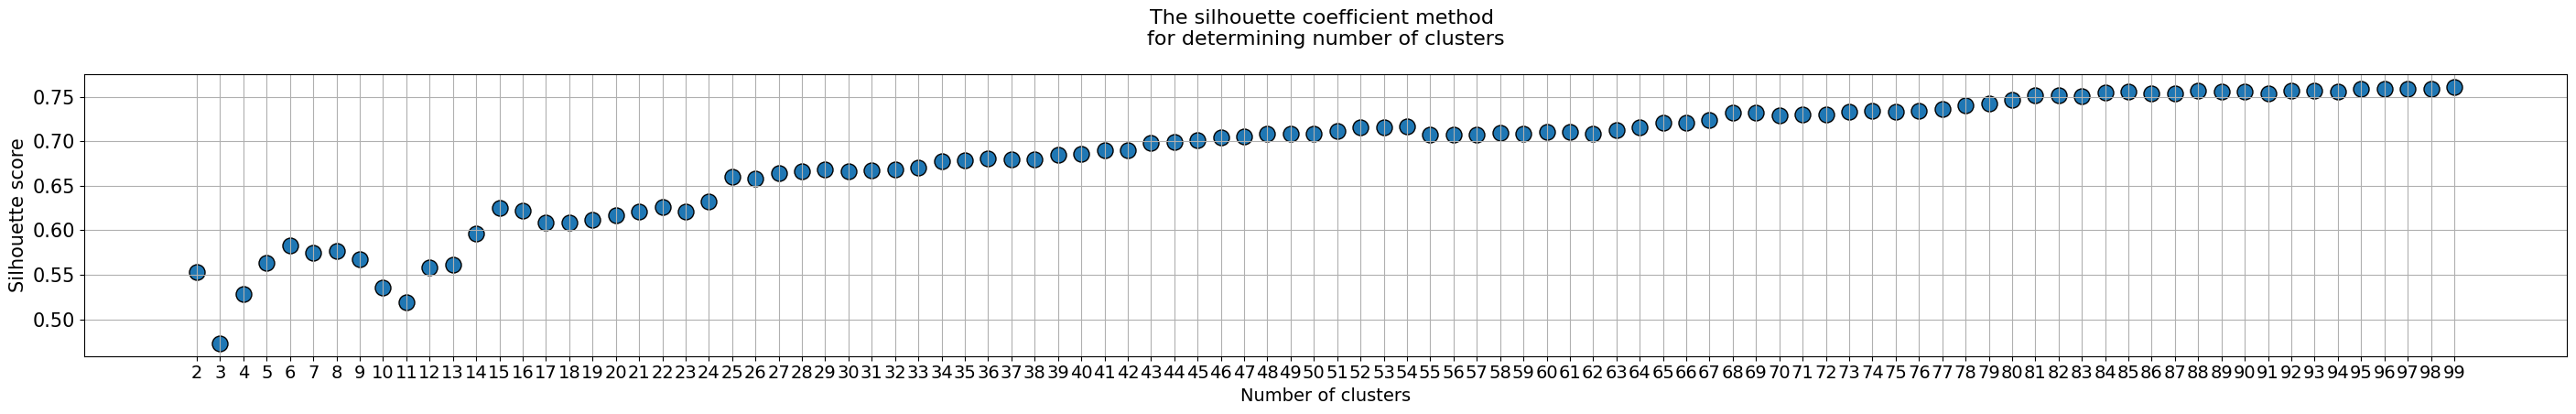

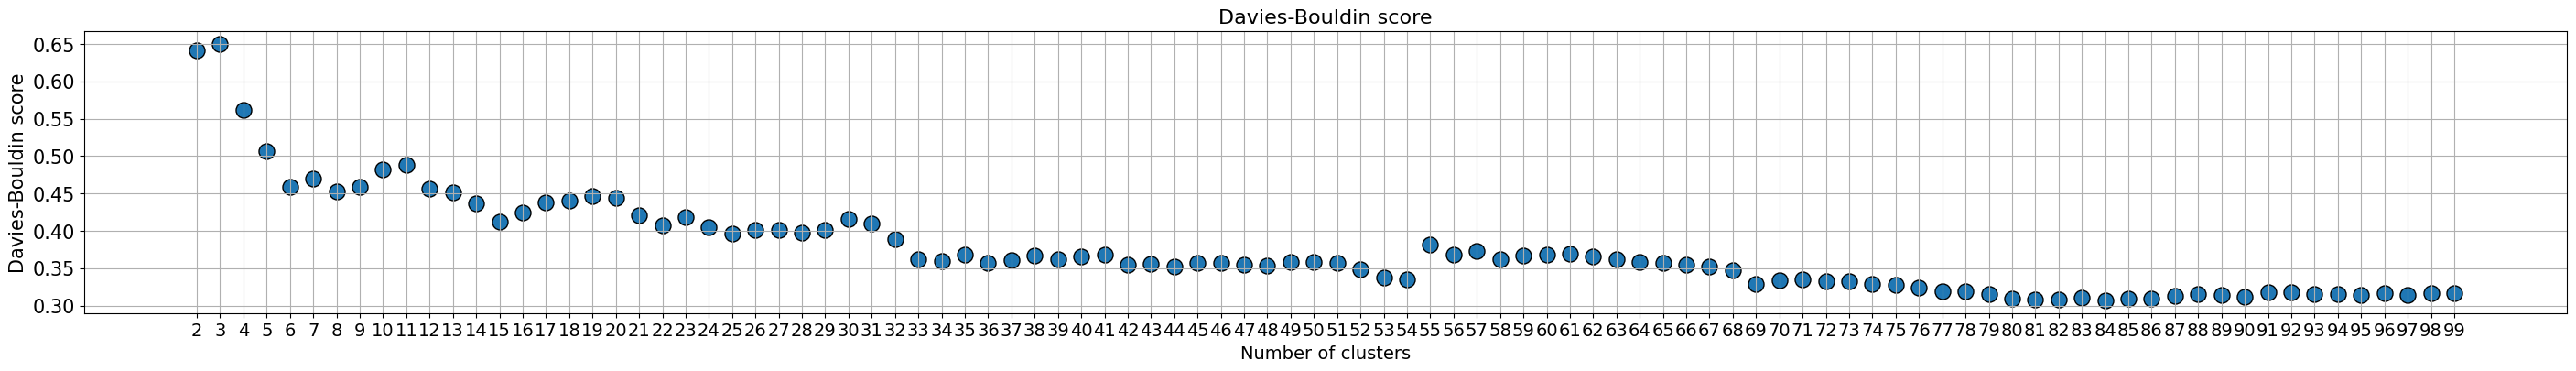

In [33]:
km_scores= []
km_silhouette = []
db_score = []
for i in range(2,100):
    km = KMeans(n_clusters=i, random_state=0).fit(movie_data_scaled)
    preds = km.predict(movie_data_scaled)

    #print("Score for number of cluster(s) {}: {}".format(i,km.score(movie_data_scaled)))
    km_scores.append(-km.score(movie_data_scaled))

    silhouette = silhouette_score(movie_data_scaled,preds)
    km_silhouette.append(silhouette)
    #print("Silhouette score for number of cluster(s) {}: {}".format(i,silhouette))

    db = davies_bouldin_score(movie_data_scaled,preds)
    db_score.append(db)
    #print("Davies Bouldin score for number of cluster(s) {}: {}".format(i,db))
    #print("------------------------------------------------------------------")

plt.figure(figsize=(35,4))
plt.title("The elbow method for determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in range(2,100)],y=km_scores,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("K-means score",fontsize=15)
plt.xticks([i for i in range(2,100)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

plt.figure(figsize=(35,4))
plt.title("The silhouette coefficient method \nfor determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in range(2,100)],y=km_silhouette,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("Silhouette score",fontsize=15)
plt.xticks([i for i in range(2,100)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

plt.figure(figsize=(35,4))
plt.title("Davies-Bouldin score",fontsize=16)
plt.scatter(x=[i for i in range(2,100)],y=db_score,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("Davies-Bouldin score",fontsize=15)
plt.xticks([i for i in range(2,100)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

Silhouette Score для K-means: 0.6248868948787744


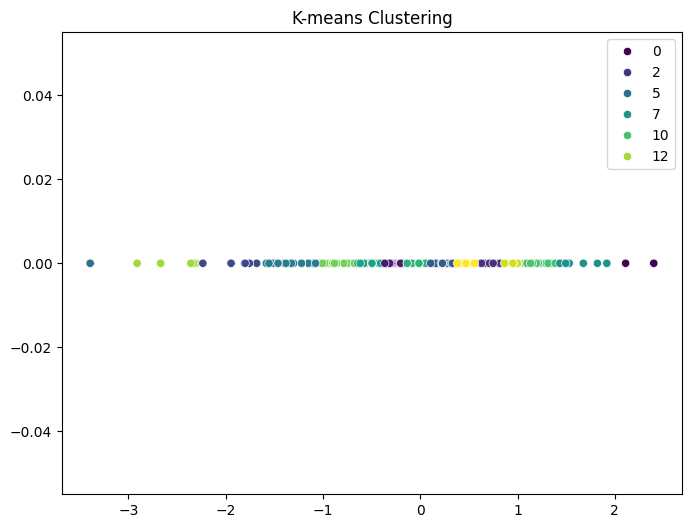

In [12]:
kmeans = KMeans(n_clusters=15, random_state=0)
kmeans_labels = kmeans.fit_predict(movie_data_scaled)

silhouette_avg = silhouette_score(movie_data_scaled, kmeans_labels)
print(f"Silhouette Score для K-means: {silhouette_avg}")

pca = PCA(n_components=2)
movie_data_pca = pca.fit_transform(movie_data_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=movie_data_pca[:, 0], y=movie_data_pca[:, 1], hue=kmeans_labels, palette='viridis')
plt.title('K-means Clustering')
plt.show()

---

### 2. **DBSCAN (Density-Based Spatial Clustering of Applications with Noise)**

**Где применять:**  
- **Когда работает хорошо:** Когда в данных есть кластеры, но они имеют разные формы, и важен поиск плотных областей (например, при кластеризации пользователей по схожим интересам, если интересы пересекаются). Отлично работает с выбросами. Когда данные имеют сложные формы кластеров или когда важно выделить фильмы с уникальными характеристиками, например, редкими тегами в `movie_tags` или необычными жанрами. DBSCAN хорошо работает в ситуациях с высоким уровнем шума, например, с редкими или нетипичными тегами.
- **Где плохо применять:** При слишком высоком уровне шума или когда кластеры имеют сильно различную плотность. Если данные имеют четкие и хорошо разделенные кластеры, например, если фильмы четко разделяются по жанрам или средним рейтингам, DBSCAN может выделять слишком много шума и неэффективно кластеризовать.
- **Не применять:** Если данные содержат явные линейные структуры, например, для слабо перекрывающихся данных, где лучше применить более строгие методы, такие как K-means. Для данных с четко определенными кластерными структурами, где лучше подходят другие методы, например, K-means.

**Тип данных:** Идеально подходит для данных с шумом, например, для кластеризации текстов или пользователей с редкими интересами. Использование тегов из `user_tags` для кластеризации фильмов, связанных с нестандартными жанрами или редкими темами.

Silhouette score for eps=0.01, min_samples=1: 0.6853687816536889
Davies Bouldin score for eps=0.01, min_samples=1: 0.20600631525482024
------------------------------------------------------------------
Silhouette score for eps=0.01, min_samples=2: 0.6656186037916901
Davies Bouldin score for eps=0.01, min_samples=2: 62.63955737664777
------------------------------------------------------------------
Silhouette score for eps=0.01, min_samples=3: 0.5815203015518702
Davies Bouldin score for eps=0.01, min_samples=3: 4.7888849577414065
------------------------------------------------------------------
Silhouette score for eps=0.01, min_samples=4: 0.5080644583207214
Davies Bouldin score for eps=0.01, min_samples=4: 6.470612983493248
------------------------------------------------------------------
Silhouette score for eps=0.01, min_samples=5: 0.4275817612876719
Davies Bouldin score for eps=0.01, min_samples=5: 6.779117821041188
----------------------------------------------------------------

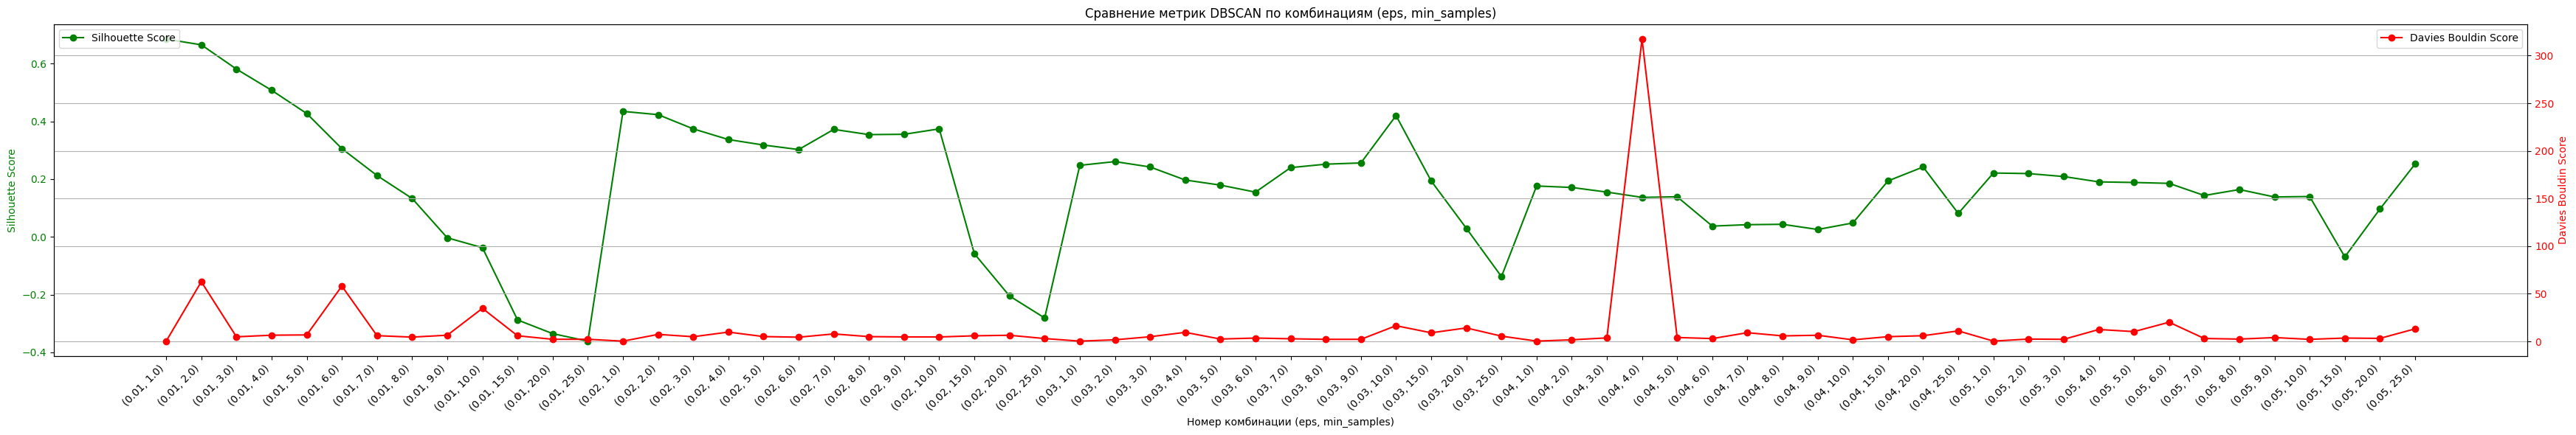

In [35]:
db_silhouette = []
db_score = []

min_samples_values = [1,2,3,4,5,6,7,8,9,10,15,20,25]
eps_values = []
for k in range(1,6,1):
    epsilon = k/100
    eps_values.append(epsilon)

for eps in eps_values:
    for min_samples in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=min_samples)
        preds = db.fit_predict(movie_data_scaled)

        if len(set(preds)) > 1:
            silhouette = silhouette_score(movie_data_scaled, preds)
            db_silhouette.append(silhouette)
            print(f"Silhouette score for eps={eps}, min_samples={min_samples}: {silhouette}")

            db_index = davies_bouldin_score(movie_data_scaled, preds)
            db_score.append(db_index)
            print(f"Davies Bouldin score for eps={eps}, min_samples={min_samples}: {db_index}")
        else:
            print(f"Insufficient clusters for eps={eps}, min_samples={min_samples}")

        print("------------------------------------------------------------------")

eps_min_samples_pairs = [(eps, min_samples) for eps in eps_values for min_samples in min_samples_values]
eps_min_samples_pairs = np.array(eps_min_samples_pairs)

fig, ax1 = plt.subplots(figsize=(35, 6))

ax1.plot(range(len(db_silhouette)), db_silhouette, 'g-o', label='Silhouette Score')
ax1.set_xlabel('Номер комбинации (eps, min_samples)')
ax1.set_ylabel('Silhouette Score', color='g')
ax1.tick_params(axis='y', labelcolor='g')
ax1.set_xticks(range(len(db_silhouette)))
ax1.set_xticklabels([f'({eps}, {min_samples})' for eps, min_samples in eps_min_samples_pairs], rotation=45, ha='right')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(range(len(db_score)), db_score, 'r-o', label='Davies Bouldin Score')
ax2.set_ylabel('Davies Bouldin Score', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.legend(loc='upper right')

plt.title('Сравнение метрик DBSCAN по комбинациям (eps, min_samples)')
plt.grid()
plt.tight_layout()
plt.show()

Silhouette Score для DBSCAN: 0.6853687816536889


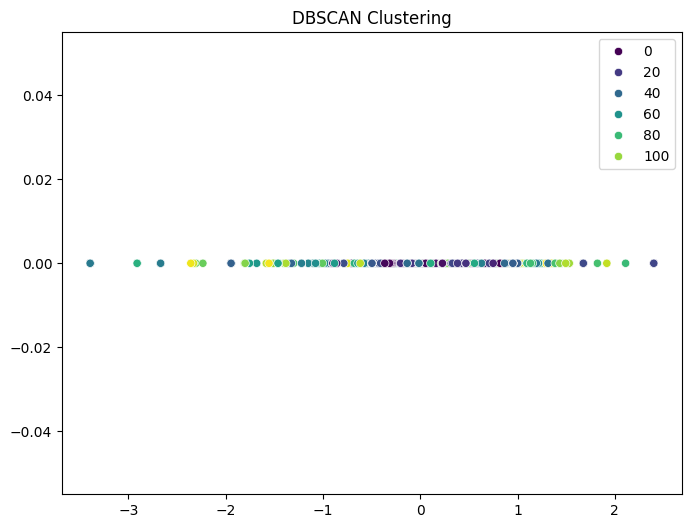

In [85]:
dbscan = DBSCAN(eps=0.01, min_samples=1)
dbscan_labels = dbscan.fit_predict(movie_data_scaled)

silhouette_avg = silhouette_score(movie_data_scaled, dbscan_labels)
print(f"Silhouette Score для DBSCAN: {silhouette_avg}")

plt.figure(figsize=(8, 6))
sns.scatterplot(x=movie_data_pca[:, 0], y=movie_data_pca[:, 1], hue=dbscan_labels, palette='viridis')
plt.title('DBSCAN Clustering')
plt.show()

---

### 3. **HDBSCAN (Hierarchical DBSCAN)**

**Где применять:**  
- **Когда работает хорошо:** Для данных с переменной плотностью и шумом, где важно выделять кластеры с нестандартной формой. Это улучшенная версия DBSCAN, которая может работать с данными, имеющими различные плотности. Когда важна кластеризация с переменной плотностью, например, если некоторые фильмы имеют больше тегов, чем другие. Этот метод отлично подходит для кластеризации фильмов с переменным интересом, например, редких жанров (таких как "wuxia" или "zombies") или популярных фильмов с множеством различных тегов в `movie_tags`.
- **Где плохо применять:** Если необходимо заранее определить количество кластеров или если кластеры должны быть строго шарообразными. Если фильмы имеют очень четко очерченные категории и кластеров должно быть немного.
- **Не применять:** В случаях, когда данные структурированы и не содержат много шума (например, четко разделенные сегменты пользователей с одинаковыми интересами). Для ситуации, когда нужно строго контролировать количество кластеров, так как HDBSCAN может образовывать несколько кластеров с разной плотностью.

**Тип данных:** Большие наборы данных с переменной плотностью, данные с шумом, например, для рекомендаций на основе пользовательского поведения. Для кластеризации фильмов по тегам, когда плотность тегов или жанров различна между фильмами, например, при анализе редких жанров, таких как "comedy" и "drama", или для выделения "нишевых" фильмов.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Silhouette score for min_cluster_size=2: 0.7247530529071873
Davies Bouldin score for min_cluster_size=2: 4.863369530389789
------------------------------------------------------------------
Silhouette score for min_cluster_size=3: 0.6425016329394587
Davies Bouldin score for min_cluster_size=3: 4.234123087107269
------------------------------------------------------------------
Silhouette score for min_cluster_size=4: 0.5793309797039911
Davies Bouldin score for min_cluster_size=4: 5.248595459452858
------------------------------------------------------------------
Silhouette score for min_cluster_size=5: 0.5241186435039473
Davies Bouldin score for min_cluster_size=5: 6.367277291004122
------------------------------------------------------------------
Silhouette score for min_cluster_size=6: 0.5098512003903932
Davies Bouldin score for min_cluster_size=6: 5.403590321299373
------------------------------------------------------------------
Silhouette score for min_cluster_size=7: 0.4680964

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Silhouette score for min_cluster_size=9: 0.4126572693801279
Davies Bouldin score for min_cluster_size=9: 14.338162652782824
------------------------------------------------------------------
Silhouette score for min_cluster_size=10: 0.3796382332362805
Davies Bouldin score for min_cluster_size=10: 11.711709045634725
------------------------------------------------------------------
Silhouette score for min_cluster_size=15: 0.2542155906802994
Davies Bouldin score for min_cluster_size=15: 11.63939540577595
------------------------------------------------------------------
Silhouette score for min_cluster_size=20: 0.17760242314348754
Davies Bouldin score for min_cluster_size=20: 16.3380495301531
------------------------------------------------------------------
Silhouette score for min_cluster_size=25: 0.14625419289520997
Davies Bouldin score for min_cluster_size=25: 6.885937894580439
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

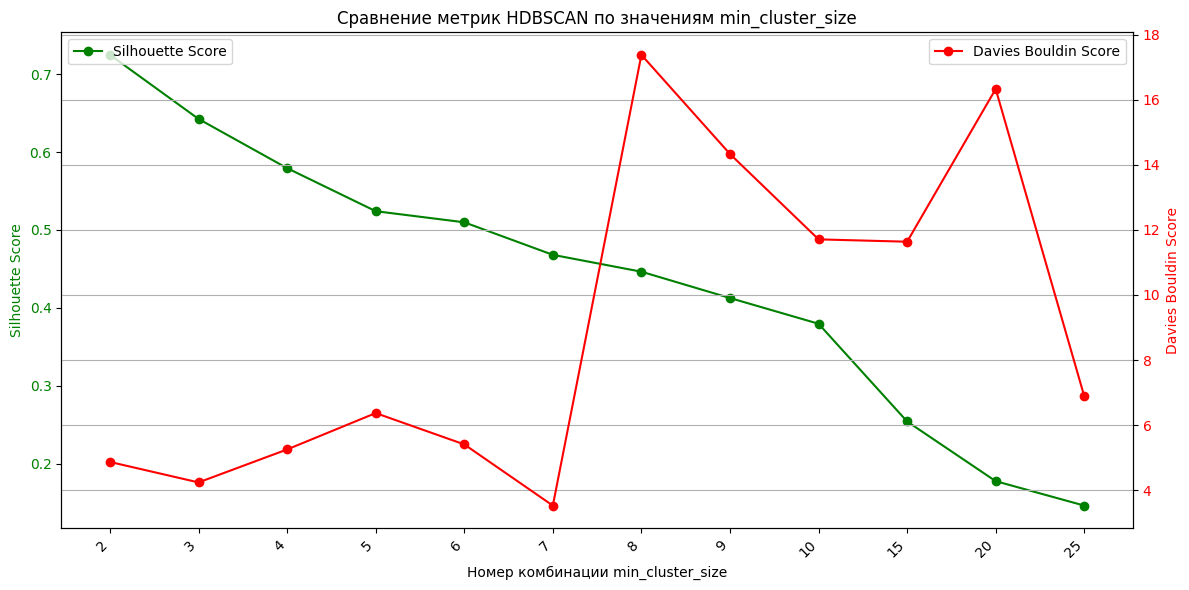

In [51]:
import hdbscan

hdb_silhouette = []
hdb_score = []

min_cluster_size_values = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25]

for min_cluster_size in min_cluster_size_values:
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size)
    preds = clusterer.fit_predict(movie_data_scaled)

    if len(set(preds)) > 1:
        silhouette = silhouette_score(movie_data_scaled, preds)
        hdb_silhouette.append(silhouette)
        print(f"Silhouette score for min_cluster_size={min_cluster_size}: {silhouette}")

        db_index = davies_bouldin_score(movie_data_scaled, preds)
        hdb_score.append(db_index)
        print(f"Davies Bouldin score for min_cluster_size={min_cluster_size}: {db_index}")
    else:
        print(f"Insufficient clusters for min_cluster_size={min_cluster_size}")

    print("------------------------------------------------------------------")

min_cluster_size_pairs = np.array(min_cluster_size_values)

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(range(len(hdb_silhouette)), hdb_silhouette, 'g-o', label='Silhouette Score')
ax1.set_xlabel('Номер комбинации min_cluster_size')
ax1.set_ylabel('Silhouette Score', color='g')
ax1.tick_params(axis='y', labelcolor='g')
ax1.set_xticks(range(len(hdb_silhouette)))
ax1.set_xticklabels([f'{min_cluster_size}' for min_cluster_size in min_cluster_size_pairs], rotation=45, ha='right')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(range(len(hdb_score)), hdb_score, 'r-o', label='Davies Bouldin Score')
ax2.set_ylabel('Davies Bouldin Score', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.legend(loc='upper right')

plt.title('Сравнение метрик HDBSCAN по значениям min_cluster_size')
plt.grid()
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Silhouette Score для HDBSCAN: 0.7247530529071873


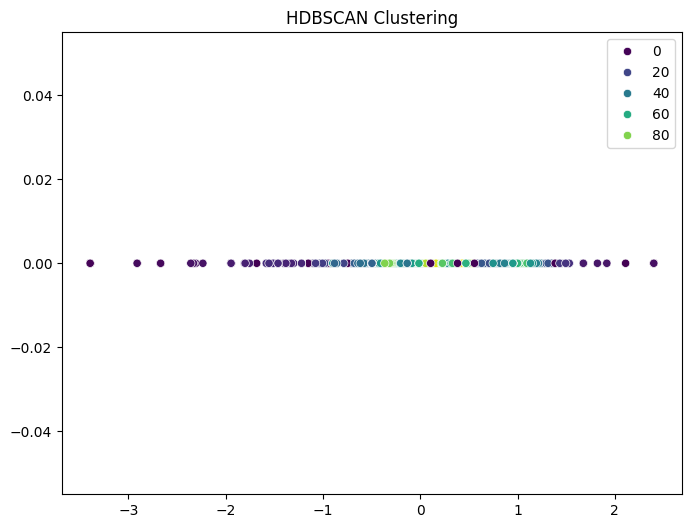

In [52]:
hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=2)
hdbscan_labels = hdbscan_clusterer.fit_predict(movie_data_scaled)

silhouette_avg = silhouette_score(movie_data_scaled, hdbscan_labels)
print(f"Silhouette Score для HDBSCAN: {silhouette_avg}")

plt.figure(figsize=(8, 6))
sns.scatterplot(x=movie_data_pca[:, 0], y=movie_data_pca[:, 1], hue=hdbscan_labels, palette='viridis')
plt.title('HDBSCAN Clustering')
plt.show()

---

### 4. **Affinity Propagation**

**Где применять:**  
- **Когда работает хорошо:** Когда заранее не известно количество кластеров, и важна автоматическая кластеризация с учетом сходства объектов (например, для рекомендаций товаров или фильмов, если необходимо найти группы пользователей по схожим предпочтениям). Когда количество кластеров заранее неизвестно и важно, чтобы алгоритм сам определил наиболее подходящие группы. Хорошо подходит для кластеризации фильмов, когда нужно объединить их по меткам или жанрам, но количество этих кластеров заранее не определено. Также подойдет для пользователей, если мы хотим выделить группы схожих предпочтений.
- **Где плохо применять:** Когда данные содержат множество выбросов или избыточные вычисления (алгоритм может быть медленным на больших данных). При больших объемах данных, так как алгоритм может быть медленным и затратным по времени.
- **Не применять:** Если кластеризация должна быть быстро выполнена на очень больших наборах данных. Для кластеризации фильмов или пользователей, где заранее известно, сколько кластеров нужно.

**Тип данных:** Хорошо работает с данными, где нужно выделить взаимные предпочтения, например, для кластеризации пользователей по интересам. Хорошо подойдет для кластеризации фильмов на основе меток в `movie_tags` или жанров в `movie_details`, а также для кластеризации пользователей на основе их оценок в `ratings`.

Silhouette score for preference=-10.00, damping=0.80: 0.5812
Davies Bouldin score for preference=-10.00, damping=0.80: 0.4527
Silhouette score for preference=-7.78, damping=0.80: 0.5653
Davies Bouldin score for preference=-7.78, damping=0.80: 0.4693
Silhouette score for preference=-5.56, damping=0.80: 0.5787
Davies Bouldin score for preference=-5.56, damping=0.80: 0.4696
Silhouette score for preference=-3.33, damping=0.80: 0.5937
Davies Bouldin score for preference=-3.33, damping=0.80: 0.4414
Silhouette score for preference=-1.11, damping=0.80: 0.6176
Davies Bouldin score for preference=-1.11, damping=0.80: 0.4168
Error with preference=1.11, damping=0.80: Number of labels is 741. Valid values are 2 to n_samples - 1 (inclusive)
Error with preference=3.33, damping=0.80: Number of labels is 741. Valid values are 2 to n_samples - 1 (inclusive)
Error with preference=5.56, damping=0.80: Number of labels is 741. Valid values are 2 to n_samples - 1 (inclusive)
Error with preference=7.78, dampi

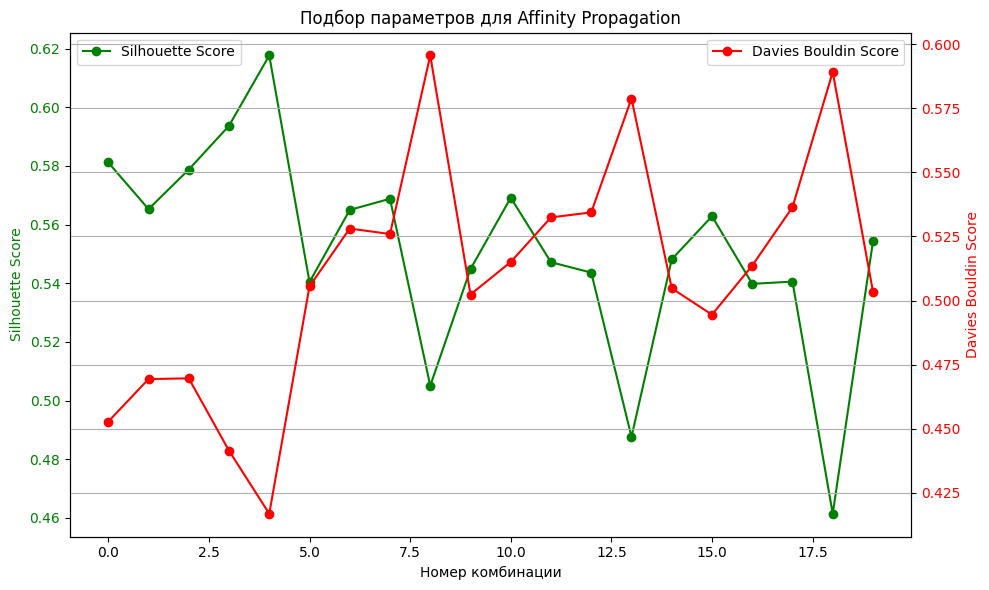

In [65]:
silhouette_scores = []
db_scores = []
preference_values = np.linspace(-10, 10, 10)
damping_values = np.linspace(0.8, 1.0, 5)

best_silhouette_score = -1
best_db_score = np.inf
best_params_silhouette = {}
best_params_db = {}

for damping in damping_values:
    for preference in preference_values:
        affinity_propagation = AffinityPropagation(preference=preference, damping=damping, random_state=42)
        try:
            affinity_propagation_labels = affinity_propagation.fit_predict(movie_data_scaled)
            silhouette_avg = silhouette_score(movie_data_scaled, affinity_propagation_labels)
            db_index = davies_bouldin_score(movie_data_scaled, affinity_propagation_labels)

            if silhouette_avg > best_silhouette_score:
                best_silhouette_score = silhouette_avg
                best_params_silhouette = {'preference': preference, 'damping': damping}

            if db_index < best_db_score:
                best_db_score = db_index
                best_params_db = {'preference': preference, 'damping': damping}

            silhouette_scores.append(silhouette_avg)
            db_scores.append(db_index)

            print(f"Silhouette score for preference={preference:.2f}, damping={damping:.2f}: {silhouette_avg:.4f}")
            print(f"Davies Bouldin score for preference={preference:.2f}, damping={damping:.2f}: {db_index:.4f}")

        except ValueError as e:
            print(f"Error with preference={preference:.2f}, damping={damping:.2f}: {e}")
            continue

print(f"\nBest Silhouette Score: {best_silhouette_score:.4f}")
print(f"Best Parameters for Silhouette: {best_params_silhouette}")

print(f"\nBest Davies Bouldin Score: {best_db_score:.4f}")
print(f"Best Parameters for Davies Bouldin Score: {best_params_db}")


fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(range(len(silhouette_scores)), silhouette_scores, 'g-o', label='Silhouette Score')
ax1.set_xlabel('Номер комбинации')
ax1.set_ylabel('Silhouette Score', color='g')
ax1.tick_params(axis='y', labelcolor='g')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(range(len(db_scores)), db_scores, 'r-o', label='Davies Bouldin Score')
ax2.set_ylabel('Davies Bouldin Score', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.legend(loc='upper right')

plt.title('Подбор параметров для Affinity Propagation')
plt.grid()
plt.tight_layout()
plt.show()

Silhouette Score для Affinity Propagation: 0.6177


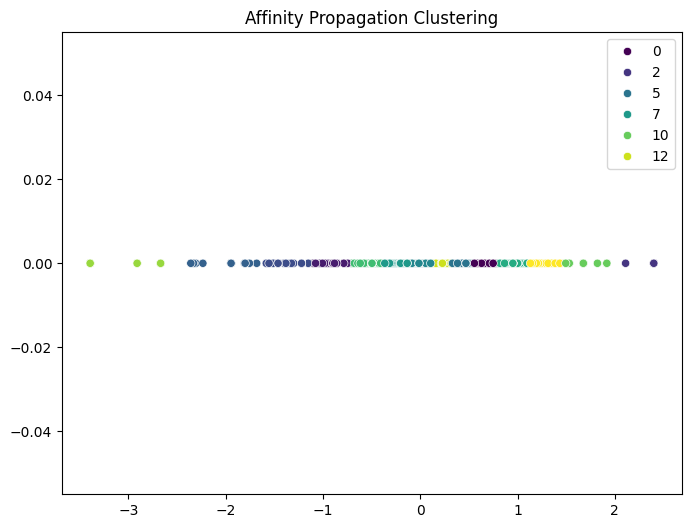

In [60]:
affinity_propagation = AffinityPropagation(preference=-1.11, damping=0.80, random_state=0)
affinity_propagation_labels = affinity_propagation.fit_predict(movie_data_scaled)

silhouette_avg = silhouette_score(movie_data_scaled, affinity_propagation_labels)
print(f"Silhouette Score для Affinity Propagation: {silhouette_avg:.4f}")

plt.figure(figsize=(8, 6))
sns.scatterplot(x=movie_data_pca[:, 0], y=movie_data_pca[:, 1], hue=affinity_propagation_labels, palette='viridis')
plt.title('Affinity Propagation Clustering')
plt.show()

---

### 5. **Gaussian Mixture Model (GMM)**

**Где применять:**  
- **Когда работает хорошо:** Если данные предполагают наличие подмножеств с различными распределениями. GMM позволяет моделировать кластеры, используя статистические распределения (например, нормальные распределения). Подходит для кластеризации, когда кластеры могут перекрываться. Когда нужно моделировать данные с несколькими распределениями (например, фильмов с разными жанровыми предпочтениями или пользователей с разными предпочтениями). GMM может быть полезен, когда кластеры (например, фильмы) имеют перекрывающиеся характеристики (например, фильмы, которые одновременно являются "комедиями" и "драмами").
- **Где плохо применять:** На больших данных или данных, где распределение классов не является гауссовским. Когда данные сильно перекрываются и не могут быть описаны простыми гауссовыми распределениями.
- **Не применять:** Когда кластеры имеют нелинейные границы или имеют сложные формы, такие как в случае с DBSCAN или HDBSCAN. Для кластеризации, где необходимо четко разделить кластеры.

**Тип данных:** Числовые данные, например, для кластеризации пользователей по статистике их поведения, если поведение может быть описано различными статистическими моделями. Для кластеризации фильмов по средним рейтингам из `movie_ratings` или для кластеризации пользователей по оценкам из `ratings`, если предполагается, что существуют перекрывающиеся группы предпочтений.

Silhouette score для n_components=2, covariance_type=full: 0.5517585843735869
Davies Bouldin score для n_components=2, covariance_type=full: 1.1960774355340704
------------------------------------------------------------------
Silhouette score для n_components=2, covariance_type=tied: 0.5695923210490187
Davies Bouldin score для n_components=2, covariance_type=tied: 0.5617647107157029
------------------------------------------------------------------
Silhouette score для n_components=2, covariance_type=diag: 0.5517585843735869
Davies Bouldin score для n_components=2, covariance_type=diag: 1.1960774355340704
------------------------------------------------------------------
Silhouette score для n_components=2, covariance_type=spherical: 0.5530273928394784
Davies Bouldin score для n_components=2, covariance_type=spherical: 0.6424596633132592
------------------------------------------------------------------
Silhouette score для n_components=3, covariance_type=full: 0.5085077613637403
Davi

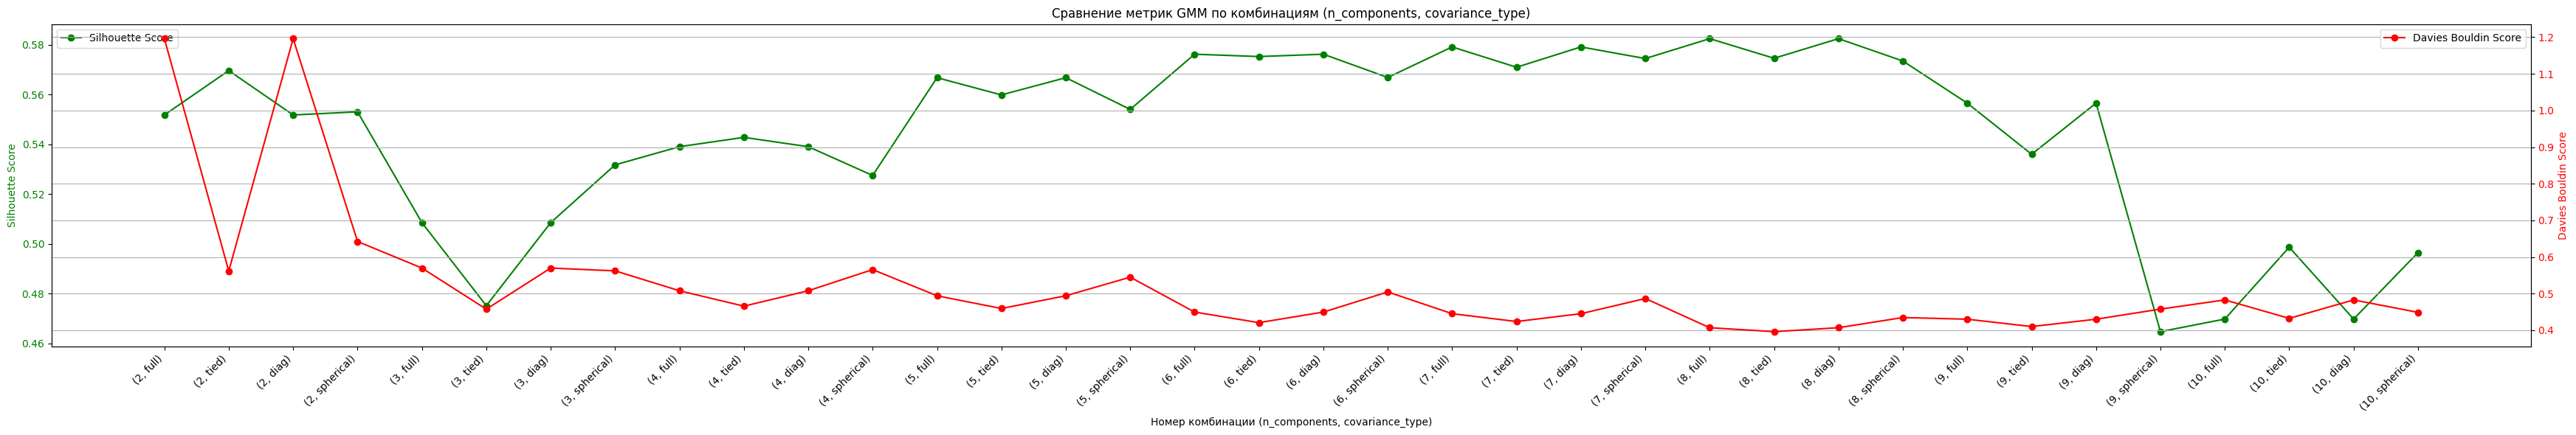

In [63]:
n_components_values = [2, 3, 4, 5, 6, 7, 8, 9, 10]
covariance_types = ['full', 'tied', 'diag', 'spherical']

gmm_silhouette = []
gmm_db_score = []

for n_components in n_components_values:
    for covariance_type in covariance_types:
        try:
            gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type, random_state=0)
            gmm_labels = gmm.fit_predict(movie_data_scaled)

            if len(set(gmm_labels)) > 1:
                silhouette_avg = silhouette_score(movie_data_scaled, gmm_labels)
                gmm_silhouette.append(silhouette_avg)
                print(f"Silhouette score для n_components={n_components}, covariance_type={covariance_type}: {silhouette_avg}")

                davies_bouldin_avg = davies_bouldin_score(movie_data_scaled, gmm_labels)
                gmm_db_score.append(davies_bouldin_avg)
                print(f"Davies Bouldin score для n_components={n_components}, covariance_type={covariance_type}: {davies_bouldin_avg}")
            else:
                print(f"Недостаточно кластеров для n_components={n_components}, covariance_type={covariance_type}")

        except Exception as e:
            print(f"Ошибка с n_components={n_components}, covariance_type={covariance_type}: {e}")
            continue

        print("------------------------------------------------------------------")

param_combinations = [(n_components, covariance_type) for n_components in n_components_values for covariance_type in covariance_types]
param_combinations = np.array(param_combinations)


fig, ax1 = plt.subplots(figsize=(35, 6))

ax1.plot(range(len(gmm_silhouette)), gmm_silhouette, 'g-o', label='Silhouette Score')
ax1.set_xlabel('Номер комбинации (n_components, covariance_type)')
ax1.set_ylabel('Silhouette Score', color='g')
ax1.tick_params(axis='y', labelcolor='g')
ax1.set_xticks(range(len(gmm_silhouette)))
ax1.set_xticklabels([f'({n}, {c})' for n, c in param_combinations], rotation=45, ha='right')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(range(len(gmm_db_score)), gmm_db_score, 'r-o', label='Davies Bouldin Score')
ax2.set_ylabel('Davies Bouldin Score', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.legend(loc='upper right')

plt.title('Сравнение метрик GMM по комбинациям (n_components, covariance_type)')
plt.grid()
plt.tight_layout()
plt.show()

Silhouette Score для GMM: 0.5824096206302373


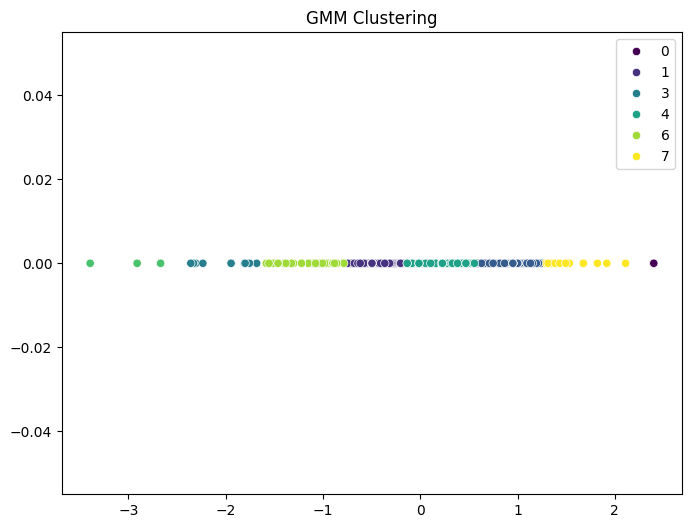

In [64]:
gmm = GaussianMixture(n_components=8, covariance_type='full', random_state=0)
gmm_labels = gmm.fit_predict(movie_data_scaled)

silhouette_avg = silhouette_score(movie_data_scaled, gmm_labels)
print(f"Silhouette Score для GMM: {silhouette_avg}")

plt.figure(figsize=(8, 6))
sns.scatterplot(x=movie_data_pca[:, 0], y=movie_data_pca[:, 1], hue=gmm_labels, palette='viridis')
plt.title('GMM Clustering')
plt.show()

---

### 6. **MeanShift**

**Где применять:**  
- **Когда работает хорошо:** Когда необходимо находить «пики» плотности в данных, например, для кластеризации с неизвестным количеством кластеров, где необходимо выделить наиболее плотные области. Это может быть полезно для поиска групп товаров с высокой популярностью. Когда нужно обнаружить области высокой плотности в данных. В контексте фильмов это может означать выделение фильмов, которые имеют схожие жанры или теги, которые популярны среди пользователей.
- **Где плохо применять:** Если кластеры сильно различаются по плотности или если требуется быстрая кластеризация. Если кластеры имеют различные плотности или если данные очень большие, что может замедлить алгоритм.
- **Не применять:** Когда важно строго определить количество кластеров заранее.

**Тип данных:** Преимущественно для числовых данных, когда нужно выделить области высокой плотности (например, для кластеризации товаров по продажам). Для кластеризации фильмов по популярным тегам из `movie_tags`, например, если мы хотим выделить фильмы, связанные с определенными жанрами или темами, которые популярны среди зрителей.


Silhouette score для bandwidth=0.01: 0.7746
Davies Bouldin score для bandwidth=0.01: 0.2358
------------------------------------------------------------------
Silhouette score для bandwidth=0.02: 0.7394
Davies Bouldin score для bandwidth=0.02: 0.2849
------------------------------------------------------------------
Silhouette score для bandwidth=0.03: 0.7050
Davies Bouldin score для bandwidth=0.03: 0.3370
------------------------------------------------------------------
Silhouette score для bandwidth=0.04: 0.6774
Davies Bouldin score для bandwidth=0.04: 0.3497
------------------------------------------------------------------
Silhouette score для bandwidth=0.05: 0.6666
Davies Bouldin score для bandwidth=0.05: 0.3540
------------------------------------------------------------------
Silhouette score для bandwidth=0.06: 0.6562
Davies Bouldin score для bandwidth=0.06: 0.3400
------------------------------------------------------------------
Silhouette score для bandwidth=0.07: 0.6328
Da

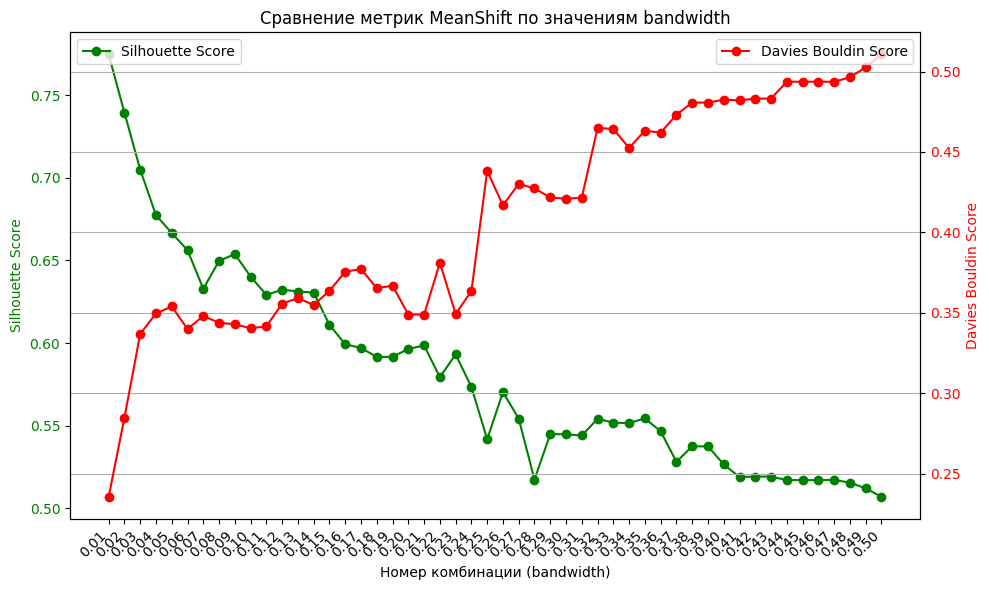

In [74]:
bandwidth_values = np.linspace(0.01, 0.50, 50)

mean_shift_silhouette = []
mean_shift_db_score = []

for bandwidth in bandwidth_values:
    try:
        mean_shift = MeanShift(bandwidth=bandwidth)
        mean_shift_labels = mean_shift.fit_predict(movie_data_scaled)

        if len(set(mean_shift_labels)) > 1:
            silhouette_avg = silhouette_score(movie_data_scaled, mean_shift_labels)
            mean_shift_silhouette.append(silhouette_avg)
            print(f"Silhouette score для bandwidth={bandwidth:.2f}: {silhouette_avg:.4f}")

            davies_bouldin_avg = davies_bouldin_score(movie_data_scaled, mean_shift_labels)
            mean_shift_db_score.append(davies_bouldin_avg)
            print(f"Davies Bouldin score для bandwidth={bandwidth:.2f}: {davies_bouldin_avg:.4f}")
        else:
            print(f"Недостаточно кластеров для bandwidth={bandwidth:.2f}")

    except Exception as e:
        print(f"Ошибка с bandwidth={bandwidth:.2f}: {e}")
        continue

    print("------------------------------------------------------------------")


fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(range(len(mean_shift_silhouette)), mean_shift_silhouette, 'g-o', label='Silhouette Score')
ax1.set_xlabel('Номер комбинации (bandwidth)')
ax1.set_ylabel('Silhouette Score', color='g')
ax1.tick_params(axis='y', labelcolor='g')
ax1.set_xticks(range(len(mean_shift_silhouette)))
ax1.set_xticklabels([f'{bandwidth:.2f}' for bandwidth in bandwidth_values[:len(mean_shift_silhouette)]], rotation=45, ha='right')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(range(len(mean_shift_db_score)), mean_shift_db_score, 'r-o', label='Davies Bouldin Score')
ax2.set_ylabel('Davies Bouldin Score', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.legend(loc='upper right')

plt.title('Сравнение метрик MeanShift по значениям bandwidth')
plt.grid()
plt.tight_layout()
plt.show()

Silhouette Score для MeanShift: 0.6538600511512616


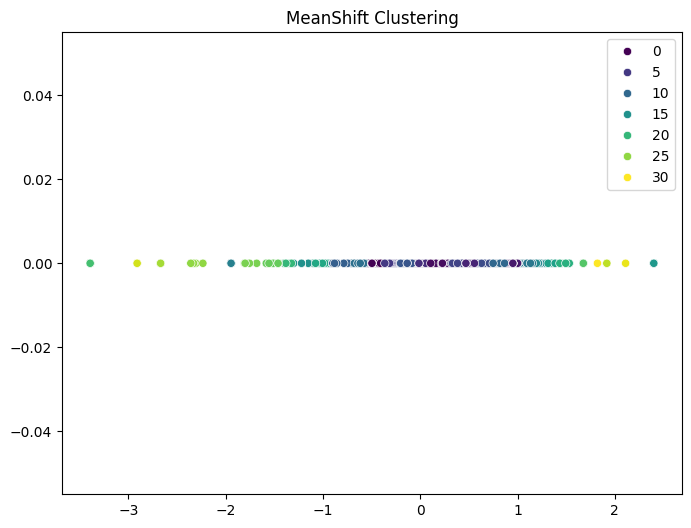

In [75]:
mean_shift = MeanShift(bandwidth=0.09) # для более тонкой кластеризации bandwidth=0.01 (~130 кластеров)
mean_shift_labels = mean_shift.fit_predict(movie_data_scaled)

silhouette_avg = silhouette_score(movie_data_scaled, mean_shift_labels)
print(f"Silhouette Score для MeanShift: {silhouette_avg}")

plt.figure(figsize=(8, 6))
sns.scatterplot(x=movie_data_pca[:, 0], y=movie_data_pca[:, 1], hue=mean_shift_labels, palette='viridis')
plt.title('MeanShift Clustering')
plt.show()

---

### 7. **Spectral Clustering**

**Где применять:**  
- **Когда работает хорошо:** Для графов и данных, которые можно представить в виде графов (например, для кластеризации товаров, связанных рекомендациями). Отлично работает, если кластеры имеют сложные структуры, и нужно учитывать связи между объектами. Для кластеризации с учетом связей между объектами, например, если фильмы могут быть связаны на основе совместных тегов в `movie_tags` или связаны через жанры в `movie_details`. Этот метод полезен для кластеризации на основе графов, например, когда нужно выделить группы фильмов, которые часто упоминаются вместе в описаниях или рецензиях.
- **Где плохо применять:** При слишком большом объеме данных или если кластеры сильно перекрываются.
- **Не применять:** Если данные не могут быть эффективно представлены как графы.

**Тип данных:** Данные, имеющие явные или скрытые связи между объектами, например, для рекомендаций, основанных на взаимодействиях пользователей и товаров. Хорошо подходит для кластеризации фильмов, которые связаны через метки или жанры, а также для объединения пользователей, которые оценивают схожие фильмы.

Ошибка с n_clusters=2, affinity=nearest_neighbors, gamma=None: The 'gamma' parameter of SpectralClustering must be a float in the range [0.0, inf). Got None instead.
------------------------------------------------------------------
Silhouette: 0.5493, Davies Bouldin: 0.6483 для n_clusters=2, affinity=rbf, gamma=0.1
Silhouette: 0.6594, Davies Bouldin: 0.2972 для n_clusters=2, affinity=rbf, gamma=0.5
Silhouette: 0.6654, Davies Bouldin: 0.2475 для n_clusters=2, affinity=rbf, gamma=1.0
Silhouette: 0.6654, Davies Bouldin: 0.2475 для n_clusters=2, affinity=rbf, gamma=2.0
Silhouette: 0.6654, Davies Bouldin: 0.2475 для n_clusters=2, affinity=rbf, gamma=5.0
Silhouette: 0.6654, Davies Bouldin: 0.2475 для n_clusters=2, affinity=rbf, gamma=10.0
------------------------------------------------------------------
Ошибка с n_clusters=3, affinity=nearest_neighbors, gamma=None: The 'gamma' parameter of SpectralClustering must be a float in the range [0.0, inf). Got None instead.
-----------------------

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited at iteration 19 with accuracies 
[2.82927483e-15 2.75407018e-08 3.90663576e-07 6.71825136e-07
 5.25064622e-06 1.19350235e-05 1.01768897e-05 1.00987572e-05]
not reaching the requested tolerance 1.1041760444641113e-05.
Use iteration 19 instead with accuracy 
4.818918259467924e-06.

  _, diffusion_map = lobpcg(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited postprocessing with accuracies 
[2.74499019e-15 2.75407019e-08 3.90663576e-07 6.71825136e-07
 5.25064622e-06 1.19350236e-05 1.01768899e-05 1.00987569e-05]
not reaching the requested tolerance 1.1041760444641113e-05.
  _, diffusion_map = lobpcg(


Silhouette: 0.2494, Davies Bouldin: 3.6771 для n_clusters=7, affinity=rbf, gamma=0.1
Silhouette: 0.4133, Davies Bouldin: 0.3939 для n_clusters=7, affinity=rbf, gamma=0.5
Silhouette: 0.4079, Davies Bouldin: 0.3925 для n_clusters=7, affinity=rbf, gamma=1.0
Silhouette: 0.4033, Davies Bouldin: 0.3665 для n_clusters=7, affinity=rbf, gamma=2.0
Silhouette: 0.3930, Davies Bouldin: 0.3579 для n_clusters=7, affinity=rbf, gamma=5.0
Silhouette: 0.4183, Davies Bouldin: 0.3530 для n_clusters=7, affinity=rbf, gamma=10.0
------------------------------------------------------------------
Ошибка с n_clusters=8, affinity=nearest_neighbors, gamma=None: The 'gamma' parameter of SpectralClustering must be a float in the range [0.0, inf). Got None instead.
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited at iteration 20 with accuracies 
[6.11422004e-15 3.45222118e-08 5.54233430e-07 5.86765100e-07
 5.28161521e-06 1.19399386e-05 9.24010376e-06 1.02687521e-05
 1.06155373e-05]
not reaching the requested tolerance 1.1041760444641113e-05.
Use iteration 20 instead with accuracy 
5.3912741877118355e-06.

  _, diffusion_map = lobpcg(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited postprocessing with accuracies 
[5.44467785e-15 3.45222119e-08 5.54233430e-07 5.86765100e-07
 5.28161520e-06 1.19399384e-05 9.24010526e-06 1.02687101e-05
 1.06155767e-05]
not reaching the requested tolerance 1.1041760444641113e-05.
  _, diffusion_map = lobpcg(


Silhouette: 0.2964, Davies Bouldin: 12.2131 для n_clusters=8, affinity=rbf, gamma=0.1
Silhouette: 0.4854, Davies Bouldin: 0.4147 для n_clusters=8, affinity=rbf, gamma=0.5
Silhouette: 0.4752, Davies Bouldin: 0.3970 для n_clusters=8, affinity=rbf, gamma=1.0
Silhouette: 0.4787, Davies Bouldin: 0.3961 для n_clusters=8, affinity=rbf, gamma=2.0
Silhouette: 0.2857, Davies Bouldin: 0.3457 для n_clusters=8, affinity=rbf, gamma=5.0
Silhouette: 0.4010, Davies Bouldin: 0.3503 для n_clusters=8, affinity=rbf, gamma=10.0
------------------------------------------------------------------
Ошибка с n_clusters=9, affinity=nearest_neighbors, gamma=None: The 'gamma' parameter of SpectralClustering must be a float in the range [0.0, inf). Got None instead.
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited at iteration 19 with accuracies 
[1.95709196e-15 2.51426219e-08 2.84208950e-07 6.65687760e-07
 4.43725497e-06 9.73370921e-06 1.07360775e-05 1.29958346e-05
 1.18305854e-05 9.66461178e-06]
not reaching the requested tolerance 1.1041760444641113e-05.
Use iteration 19 instead with accuracy 
6.037311273233322e-06.

  _, diffusion_map = lobpcg(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited postprocessing with accuracies 
[2.01276518e-15 2.51426220e-08 2.84208950e-07 6.65687760e-07
 4.43725497e-06 9.73370943e-06 1.07360775e-05 1.29958345e-05
 1.18305853e-05 9.66461177e-06]
not reaching the requested tolerance 1.1041760444641113e-05.
  _, diffusion_map = lobpcg(


Silhouette: 0.3001, Davies Bouldin: 18.9455 для n_clusters=9, affinity=rbf, gamma=0.1
Silhouette: 0.5684, Davies Bouldin: 0.4299 для n_clusters=9, affinity=rbf, gamma=0.5
Silhouette: 0.4594, Davies Bouldin: 0.3709 для n_clusters=9, affinity=rbf, gamma=1.0
Silhouette: 0.4368, Davies Bouldin: 0.3579 для n_clusters=9, affinity=rbf, gamma=2.0
Silhouette: 0.4336, Davies Bouldin: 0.3568 для n_clusters=9, affinity=rbf, gamma=5.0
Silhouette: 0.4182, Davies Bouldin: 0.3468 для n_clusters=9, affinity=rbf, gamma=10.0
------------------------------------------------------------------
Ошибка с n_clusters=10, affinity=nearest_neighbors, gamma=None: The 'gamma' parameter of SpectralClustering must be a float in the range [0.0, inf). Got None instead.
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited at iteration 18 with accuracies 
[2.74757176e-15 4.28587084e-06 7.81911658e-07 9.20258242e-07
 4.10235230e-06 1.18997227e-05 9.01560158e-06 1.23816336e-05
 1.03099136e-05 1.30680897e-05 9.35101158e-06]
not reaching the requested tolerance 1.1041760444641113e-05.
Use iteration 18 instead with accuracy 
6.919669619887489e-06.

  _, diffusion_map = lobpcg(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited postprocessing with accuracies 
[2.65055454e-15 4.28587084e-06 7.81911658e-07 9.20258243e-07
 4.10235230e-06 1.18997232e-05 9.01560270e-06 1.23816305e-05
 1.03099156e-05 1.30680908e-05 9.35101022e-06]
not reaching the requested tolerance 1.1041760444641113e-05.
  _, diffusion_map = lobpcg(


Silhouette: 0.2923, Davies Bouldin: 17.0764 для n_clusters=10, affinity=rbf, gamma=0.1


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited at iteration 111 with accuracies 
[9.00373933e-15 1.71909020e-06 4.52006001e-06 4.27678252e-07
 9.71090411e-07 2.33033892e-06 3.01947854e-06 6.93650626e-06
 9.74182149e-06 1.11037062e-05 1.03759700e-05]
not reaching the requested tolerance 1.1041760444641113e-05.
Use iteration 111 instead with accuracy 
4.649612754646825e-06.

  _, diffusion_map = lobpcg(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited postprocessing with accuracies 
[6.52146557e-15 1.71909020e-06 4.52006001e-06 4.27678252e-07
 9.71090411e-07 2.33033892e-06 3.01947854e-06 6.93650628e-06
 9.74182218e-06 1.11037020e-05 1.03759738e-05]
not reaching the requested tolerance 1.1041760444641113e-05.
  _, diffusion_map = lobpcg(


Silhouette: 0.3779, Davies Bouldin: 1.0063 для n_clusters=10, affinity=rbf, gamma=0.5
Silhouette: 0.5606, Davies Bouldin: 0.3674 для n_clusters=10, affinity=rbf, gamma=1.0
Silhouette: 0.5403, Davies Bouldin: 0.3475 для n_clusters=10, affinity=rbf, gamma=2.0
Silhouette: 0.5482, Davies Bouldin: 0.3464 для n_clusters=10, affinity=rbf, gamma=5.0
Silhouette: 0.5517, Davies Bouldin: 0.3420 для n_clusters=10, affinity=rbf, gamma=10.0
------------------------------------------------------------------
Ошибка с n_clusters=11, affinity=nearest_neighbors, gamma=None: The 'gamma' parameter of SpectralClustering must be a float in the range [0.0, inf). Got None instead.
------------------------------------------------------------------
Silhouette: 0.2821, Davies Bouldin: 7.6585 для n_clusters=11, affinity=rbf, gamma=0.1
Silhouette: 0.3578, Davies Bouldin: 4.6342 для n_clusters=11, affinity=rbf, gamma=0.5
Silhouette: 0.5864, Davies Bouldin: 0.3858 для n_clusters=11, affinity=rbf, gamma=1.0
Silhouette

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited at iteration 168 with accuracies 
[7.97724578e-13 8.36923298e-07 4.15427089e-08 9.57740266e-08
 1.79101302e-07 1.41477413e-06 8.46821196e-07 3.17769831e-06
 2.61437905e-06 4.48524792e-06 1.10749490e-05 7.75241635e-06
 1.25899003e-05 7.77106921e-06 1.17798528e-05 1.08713056e-05]
not reaching the requested tolerance 1.1041760444641113e-05.
Use iteration 168 instead with accuracy 
4.720734752258338e-06.

  _, diffusion_map = lobpcg(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited postprocessing with accuracies 
[7.91663044e-13 8.36923298e-07 4.15427088e-08 9.57740266e-08
 1.79101302e-07 1.41477413e-06 8.46821196e-07 3.17769831e-06
 2.61437905e-06 4.48524796e-06 1.12520959e-05 7.36509860e-06
 1.24331678e-05 8.12175280e-06 1.17446070e-05 1.09207096e-05]
not reaching the requested tolerance 1.1041760444641113e-05.
  _, diffusion_map

Silhouette: 0.3888, Davies Bouldin: 0.6719 для n_clusters=15, affinity=rbf, gamma=1.0
Silhouette: 0.4900, Davies Bouldin: 0.6250 для n_clusters=15, affinity=rbf, gamma=2.0
Silhouette: 0.5396, Davies Bouldin: 0.3085 для n_clusters=15, affinity=rbf, gamma=5.0
Silhouette: 0.5411, Davies Bouldin: 0.3047 для n_clusters=15, affinity=rbf, gamma=10.0
------------------------------------------------------------------
Ошибка с n_clusters=16, affinity=nearest_neighbors, gamma=None: The 'gamma' parameter of SpectralClustering must be a float in the range [0.0, inf). Got None instead.
------------------------------------------------------------------
Silhouette: 0.1332, Davies Bouldin: 0.9835 для n_clusters=16, affinity=rbf, gamma=0.1
Silhouette: 0.3064, Davies Bouldin: 65.1908 для n_clusters=16, affinity=rbf, gamma=0.5


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited at iteration 192 with accuracies 
[1.99096738e-13 9.13184523e-07 1.54175171e-06 1.55341820e-07
 1.62276298e-07 4.12221921e-07 4.80471711e-07 1.46769974e-06
 3.37628343e-06 5.34382201e-06 8.43392277e-06 8.82656424e-06
 8.62265496e-06 9.23200494e-06 1.13364731e-05 1.06225320e-05
 1.07400477e-05]
not reaching the requested tolerance 1.1041760444641113e-05.
Use iteration 187 instead with accuracy 
4.6950632082228125e-06.

  _, diffusion_map = lobpcg(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited postprocessing with accuracies 
[1.94261437e-13 9.14385264e-07 1.54377014e-06 1.55365598e-07
 1.62286572e-07 4.12256430e-07 4.80776625e-07 1.47403334e-06
 3.37664788e-06 5.34381323e-06 8.28538574e-06 8.83695840e-06
 8.16904223e-06 9.41428157e-06 1.14455837e-05 7.93352094e-06
 1.18642752e-05]
not reaching the requested tolerance 1.1041760

Silhouette: 0.3848, Davies Bouldin: 2.3776 для n_clusters=16, affinity=rbf, gamma=1.0


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited at iteration 237 with accuracies 
[8.14904680e-15 1.12636571e-07 2.86371524e-07 2.38970650e-07
 1.29282498e-07 3.55993628e-07 7.96439250e-07 2.68227542e-06
 1.13212874e-06 2.09360265e-06 4.33944552e-06 5.30495709e-06
 8.10334761e-06 1.09769766e-05 1.10369309e-05 9.88324364e-06
 1.13510871e-05]
not reaching the requested tolerance 1.1041760444641113e-05.
Use iteration 237 instead with accuracy 
4.048452319503503e-06.

  _, diffusion_map = lobpcg(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited postprocessing with accuracies 
[7.88744453e-15 1.12636571e-07 2.86371524e-07 2.38970649e-07
 1.29282498e-07 3.55993628e-07 7.96439250e-07 2.68227542e-06
 1.13212874e-06 2.09360265e-06 4.33944552e-06 5.30495709e-06
 8.10334762e-06 1.09766542e-05 1.10368983e-05 9.87683504e-06
 1.13570071e-05]
not reaching the requested tolerance 1.10417604

Silhouette: 0.4792, Davies Bouldin: 0.6098 для n_clusters=16, affinity=rbf, gamma=2.0
Silhouette: 0.5911, Davies Bouldin: 0.3143 для n_clusters=16, affinity=rbf, gamma=5.0
Silhouette: 0.5894, Davies Bouldin: 0.3103 для n_clusters=16, affinity=rbf, gamma=10.0
------------------------------------------------------------------
Ошибка с n_clusters=17, affinity=nearest_neighbors, gamma=None: The 'gamma' parameter of SpectralClustering must be a float in the range [0.0, inf). Got None instead.
------------------------------------------------------------------
Silhouette: 0.1346, Davies Bouldin: 0.9964 для n_clusters=17, affinity=rbf, gamma=0.1
Silhouette: 0.3776, Davies Bouldin: 8.9913 для n_clusters=17, affinity=rbf, gamma=0.5


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited at iteration 161 with accuracies 
[4.63009378e-14 1.27592021e-06 8.38608203e-07 1.63767017e-06
 6.52443525e-07 1.60774454e-06 1.60466334e-06 2.68848026e-06
 3.67535530e-06 4.37841021e-06 6.48582932e-06 7.18065257e-06
 9.04277021e-06 1.03858615e-05 1.07784622e-05 1.14692229e-05
 7.67158235e-06 1.06560930e-05]
not reaching the requested tolerance 1.1041760444641113e-05.
Use iteration 161 instead with accuracy 
5.112764991664893e-06.

  _, diffusion_map = lobpcg(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited postprocessing with accuracies 
[4.40749555e-14 1.27592021e-06 8.38608203e-07 1.63767017e-06
 6.52443525e-07 1.60774454e-06 1.60466334e-06 2.68848026e-06
 3.67535530e-06 4.37841021e-06 6.48578037e-06 7.18063703e-06
 9.04275796e-06 1.03862770e-05 1.07777546e-05 1.14694797e-05
 7.67178900e-06 1.06560292e-05]
not reaching the 

Silhouette: 0.3880, Davies Bouldin: 2.7388 для n_clusters=17, affinity=rbf, gamma=1.0
Silhouette: 0.4944, Davies Bouldin: 0.4813 для n_clusters=17, affinity=rbf, gamma=2.0
Silhouette: 0.5975, Davies Bouldin: 0.3247 для n_clusters=17, affinity=rbf, gamma=5.0
Silhouette: 0.5963, Davies Bouldin: 0.3205 для n_clusters=17, affinity=rbf, gamma=10.0
------------------------------------------------------------------
Ошибка с n_clusters=18, affinity=nearest_neighbors, gamma=None: The 'gamma' parameter of SpectralClustering must be a float in the range [0.0, inf). Got None instead.
------------------------------------------------------------------
Silhouette: 0.1350, Davies Bouldin: 1.0084 для n_clusters=18, affinity=rbf, gamma=0.1
Silhouette: 0.3109, Davies Bouldin: 5.1453 для n_clusters=18, affinity=rbf, gamma=0.5


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited at iteration 152 with accuracies 
[1.37802219e-14 5.37504621e-07 3.49702424e-07 1.15962284e-07
 6.00251435e-08 1.11348304e-06 4.78229492e-07 1.38713199e-06
 2.75672684e-06 4.07076270e-06 6.21915774e-06 6.91549678e-06
 9.99061904e-06 7.67200982e-06 1.25395628e-05 1.13900712e-05
 1.08635420e-05 1.10211804e-05 9.91665305e-06]
not reaching the requested tolerance 1.1041760444641113e-05.
Use iteration 152 instead with accuracy 
5.126201131201377e-06.

  _, diffusion_map = lobpcg(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited postprocessing with accuracies 
[1.38066945e-14 5.37504621e-07 3.49702424e-07 1.15962284e-07
 6.00251435e-08 1.11348304e-06 4.78229492e-07 1.38713199e-06
 2.75672684e-06 4.07076270e-06 6.21915781e-06 6.91549723e-06
 9.99061977e-06 7.67201345e-06 1.25407499e-05 1.13890380e-05
 1.08632867e-05 1.10211747e-05 9.9

Silhouette: 0.3861, Davies Bouldin: 7.8819 для n_clusters=18, affinity=rbf, gamma=1.0


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited at iteration 267 with accuracies 
[7.12874265e-14 5.84005969e-08 7.36266436e-08 9.03799006e-08
 1.77681501e-07 6.84979746e-07 3.67360462e-07 1.29277075e-06
 6.08361719e-07 1.53922831e-06 3.95603642e-06 4.77189644e-06
 4.49316236e-06 8.78312292e-06 1.14461075e-05 7.97286339e-06
 1.03947096e-05 1.01228489e-05 1.06753443e-05]
not reaching the requested tolerance 1.1041760444641113e-05.
Use iteration 267 instead with accuracy 
4.079414817639459e-06.

  _, diffusion_map = lobpcg(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited postprocessing with accuracies 
[6.06643495e-14 5.84005969e-08 7.36266437e-08 9.03799009e-08
 1.77681501e-07 6.84979746e-07 3.67360462e-07 1.29277075e-06
 6.08361720e-07 1.53922831e-06 3.95603642e-06 4.77189644e-06
 4.49316236e-06 8.78465561e-06 1.14538852e-05 7.97451977e-06
 1.04155830e-05 1.00908771e-05 1.0

Silhouette: 0.4053, Davies Bouldin: 1.5642 для n_clusters=18, affinity=rbf, gamma=2.0
Silhouette: 0.5991, Davies Bouldin: 0.3336 для n_clusters=18, affinity=rbf, gamma=5.0
Silhouette: 0.5941, Davies Bouldin: 0.3487 для n_clusters=18, affinity=rbf, gamma=10.0
------------------------------------------------------------------
Ошибка с n_clusters=19, affinity=nearest_neighbors, gamma=None: The 'gamma' parameter of SpectralClustering must be a float in the range [0.0, inf). Got None instead.
------------------------------------------------------------------
Silhouette: 0.1329, Davies Bouldin: 1.0094 для n_clusters=19, affinity=rbf, gamma=0.1
Silhouette: 0.3261, Davies Bouldin: 3.5094 для n_clusters=19, affinity=rbf, gamma=0.5
Silhouette: 0.3847, Davies Bouldin: 1.0368 для n_clusters=19, affinity=rbf, gamma=1.0


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited at iteration 249 with accuracies 
[4.17930364e-14 5.92469168e-08 8.59269720e-08 2.06796716e-07
 2.00788205e-07 4.88119337e-07 1.15551203e-07 8.06938426e-07
 5.36800493e-07 2.22854614e-06 2.48056548e-06 3.67824578e-06
 4.96516788e-06 1.22406323e-05 1.08411510e-05 8.22603258e-06
 1.00509349e-05 9.98137275e-06 1.05424016e-05 1.08590614e-05]
not reaching the requested tolerance 1.1041760444641113e-05.
Use iteration 249 instead with accuracy 
4.429714009331542e-06.

  _, diffusion_map = lobpcg(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited postprocessing with accuracies 
[3.96344087e-14 5.92469168e-08 8.59269719e-08 2.06796716e-07
 2.00788205e-07 4.88119337e-07 1.15551203e-07 8.06938426e-07
 5.36800493e-07 2.22854614e-06 2.48056548e-06 3.67824578e-06
 4.96516790e-06 1.22403307e-05 1.08407457e-05 8.22688600e-06
 1.00507792e-05 9.9

Silhouette: 0.4654, Davies Bouldin: 1.1170 для n_clusters=19, affinity=rbf, gamma=2.0
Silhouette: 0.6105, Davies Bouldin: 0.3452 для n_clusters=19, affinity=rbf, gamma=5.0
Silhouette: 0.5921, Davies Bouldin: 0.3568 для n_clusters=19, affinity=rbf, gamma=10.0
------------------------------------------------------------------
Ошибка с n_clusters=20, affinity=nearest_neighbors, gamma=None: The 'gamma' parameter of SpectralClustering must be a float in the range [0.0, inf). Got None instead.
------------------------------------------------------------------
Silhouette: 0.1315, Davies Bouldin: 1.0208 для n_clusters=20, affinity=rbf, gamma=0.1
Silhouette: 0.3234, Davies Bouldin: 3.1400 для n_clusters=20, affinity=rbf, gamma=0.5
Silhouette: 0.2767, Davies Bouldin: 0.5838 для n_clusters=20, affinity=rbf, gamma=1.0


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited at iteration 232 with accuracies 
[5.19139335e-14 2.72356642e-08 1.37186750e-08 6.27290723e-08
 1.73623872e-07 5.48206437e-07 1.81792917e-07 1.02184291e-06
 4.86191634e-07 2.52106547e-06 1.96866385e-06 3.25098500e-06
 4.60499564e-06 9.60636429e-06 1.22620107e-05 1.08220313e-05
 1.04459354e-05 1.34391990e-05 1.12582727e-05 1.09528238e-05
 9.01989168e-06]
not reaching the requested tolerance 1.1041760444641113e-05.
Use iteration 221 instead with accuracy 
4.845078266211886e-06.

  _, diffusion_map = lobpcg(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited postprocessing with accuracies 
[4.93832760e-14 2.72414269e-08 1.37295154e-08 6.27475727e-08
 1.73814195e-07 5.48708776e-07 1.82187091e-07 1.02453338e-06
 4.86561090e-07 2.52629757e-06 1.97161232e-06 3.25308175e-06
 4.61107543e-06 9.70584197e-06 1.25269088e-05 1.08274697e-05
 1.

Silhouette: 0.4646, Davies Bouldin: 0.6967 для n_clusters=20, affinity=rbf, gamma=2.0
Silhouette: 0.4613, Davies Bouldin: 0.4432 для n_clusters=20, affinity=rbf, gamma=5.0
Silhouette: 0.5944, Davies Bouldin: 0.3466 для n_clusters=20, affinity=rbf, gamma=10.0
------------------------------------------------------------------


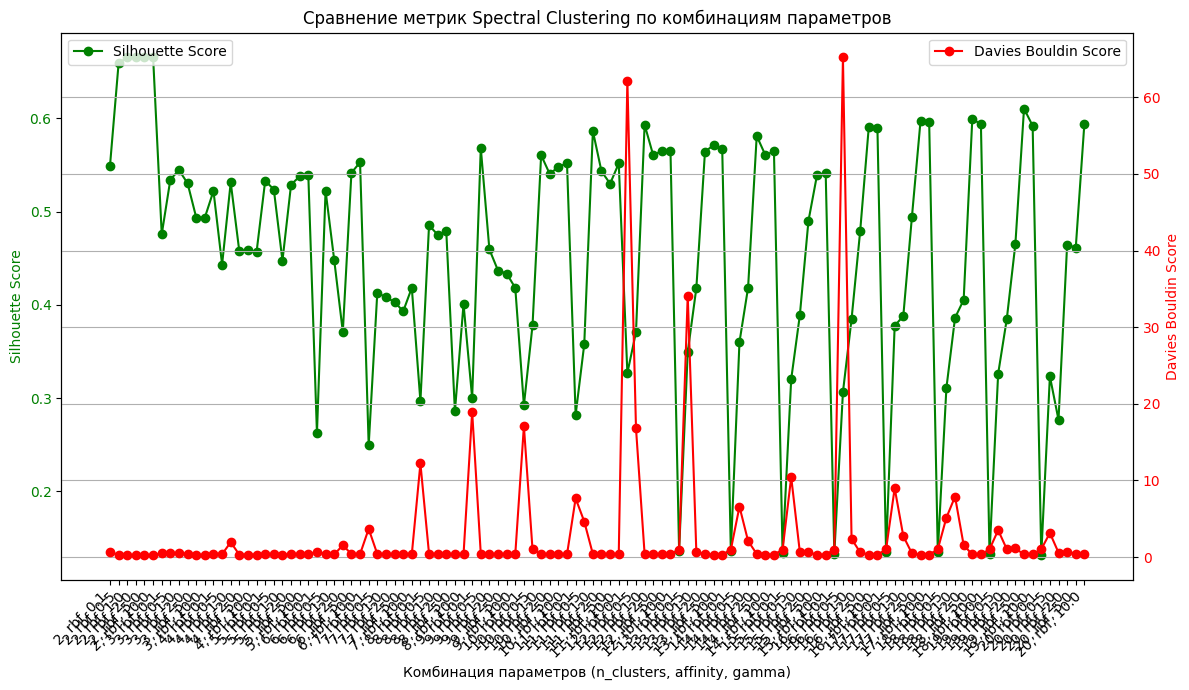

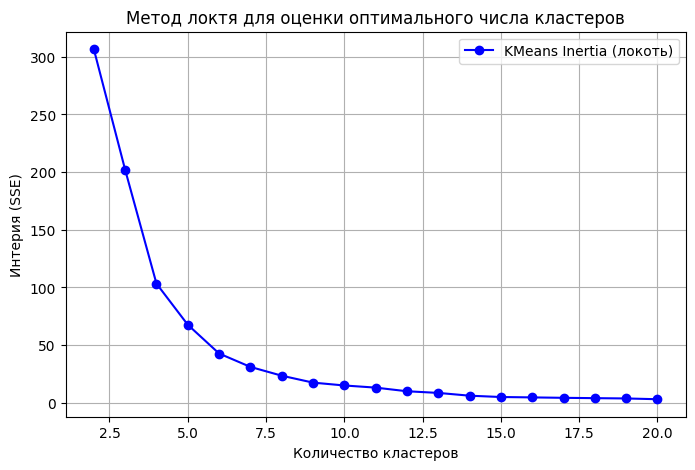

In [82]:
n_clusters_values = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
affinity_values = ['nearest_neighbors', 'rbf']
gamma_values = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]

spectral_silhouette = []
spectral_db_score = []
param_combinations = []

kmeans_inertia = []

def perform_clustering(n_clusters, affinity, gamma=None):
    """Функция для выполнения кластеризации и вычисления метрик"""
    try:
        spectral_clustering = SpectralClustering(
            n_clusters=n_clusters,
            affinity=affinity,
            gamma=gamma,
            random_state=0
        )
        spectral_labels = spectral_clustering.fit_predict(movie_data_scaled)

        silhouette_avg = silhouette_score(movie_data_scaled, spectral_labels)
        davies_bouldin_avg = davies_bouldin_score(movie_data_scaled, spectral_labels)

        return silhouette_avg, davies_bouldin_avg
    except Exception as e:
        print(f"Ошибка с n_clusters={n_clusters}, affinity={affinity}, gamma={gamma}: {e}")
        return None, None

for n_clusters in n_clusters_values:
    for affinity in affinity_values:
        if affinity == 'rbf':
            for gamma in gamma_values:
                silhouette_avg, davies_bouldin_avg = perform_clustering(n_clusters, affinity, gamma)
                if silhouette_avg is not None:
                    spectral_silhouette.append(silhouette_avg)
                    spectral_db_score.append(davies_bouldin_avg)
                    param_combinations.append(f"{n_clusters}, {affinity}, {gamma}")
                    print(f"Silhouette: {silhouette_avg:.4f}, Davies Bouldin: {davies_bouldin_avg:.4f} для n_clusters={n_clusters}, affinity={affinity}, gamma={gamma}")
        else:
            silhouette_avg, davies_bouldin_avg = perform_clustering(n_clusters, affinity)
            if silhouette_avg is not None:
                spectral_silhouette.append(silhouette_avg)
                spectral_db_score.append(davies_bouldin_avg)
                param_combinations.append(f"{n_clusters}, {affinity}")
                print(f"Silhouette: {silhouette_avg:.4f}, Davies Bouldin: {davies_bouldin_avg:.4f} для n_clusters={n_clusters}, affinity={affinity}")

        print("------------------------------------------------------------------")

    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(movie_data_scaled)
    kmeans_inertia.append(kmeans.inertia_)


fig, ax1 = plt.subplots(figsize=(12, 7))

ax1.plot(range(len(spectral_silhouette)), spectral_silhouette, 'g-o', label='Silhouette Score')
ax1.set_xlabel('Комбинация параметров (n_clusters, affinity, gamma)')
ax1.set_ylabel('Silhouette Score', color='g')
ax1.tick_params(axis='y', labelcolor='g')
ax1.set_xticks(range(len(spectral_silhouette)))
ax1.set_xticklabels(param_combinations, rotation=45, ha='right')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(range(len(spectral_db_score)), spectral_db_score, 'r-o', label='Davies Bouldin Score')
ax2.set_ylabel('Davies Bouldin Score', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.legend(loc='upper right')

plt.title('Сравнение метрик Spectral Clustering по комбинациям параметров')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(n_clusters_values, kmeans_inertia, 'b-o', label='KMeans Inertia (локоть)')
plt.xlabel('Количество кластеров')
plt.ylabel('Интерия (SSE)')
plt.title('Метод локтя для оценки оптимального числа кластеров')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

Silhouette Score для Spectral Clustering: 0.5607080769931695


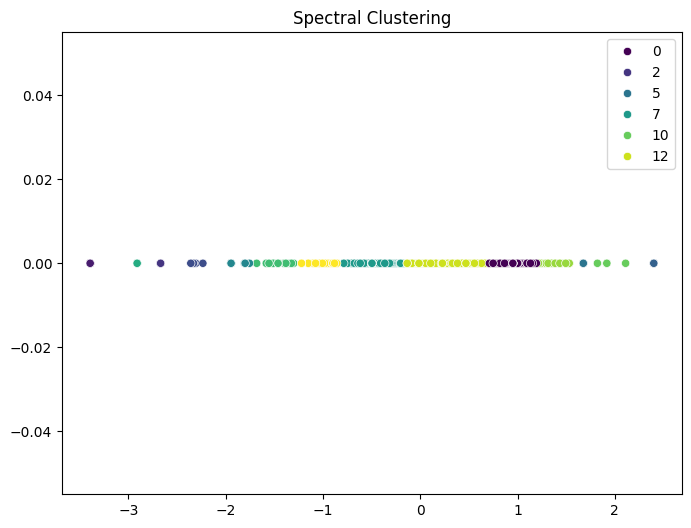

In [84]:
spectral = SpectralClustering(n_clusters=14, affinity='rbf', gamma=5.0, random_state=0)
spectral_labels = spectral.fit_predict(movie_data_scaled)

silhouette_avg = silhouette_score(movie_data_scaled, spectral_labels)
print(f"Silhouette Score для Spectral Clustering: {silhouette_avg}")

plt.figure(figsize=(8, 6))
sns.scatterplot(x=movie_data_pca[:, 0], y=movie_data_pca[:, 1], hue=spectral_labels, palette='viridis')
plt.title('Spectral Clustering')
plt.show()

---

### 8-9. **Ward (Hierarchical Clustering using Variance Minimization)** как способ слияния кластеров в **Agglomerative clustering**

**Где применять:**  
- **Когда работает хорошо:** Для иерархической кластеризации, где важно минимизировать вариацию внутри кластеров. Этот метод подходит для кластеризации, когда структуры данных могут быть иерархическими, например, при кластеризации товаров по категориям. Когда необходимо объединить фильмы по схожести их характеристик (например, жанров или тегов). Подходит для иерархической кластеризации, например, для создания иерархий жанров или меток.
- **Где плохо применять:** Если количество кластеров заранее неизвестно или если данные очень большие.
- **Не применять:** Если нужно быстро обработать очень большие наборы данных, поскольку алгоритм имеет сложность O(n^2).

**Тип данных:** Хорошо работает для структурированных данных, например, для товаров, сгруппированных по категориям. Хорошо работает для создания иерархий жанров или меток фильмов, например, объединение фильмов по типу жанра или тегу.

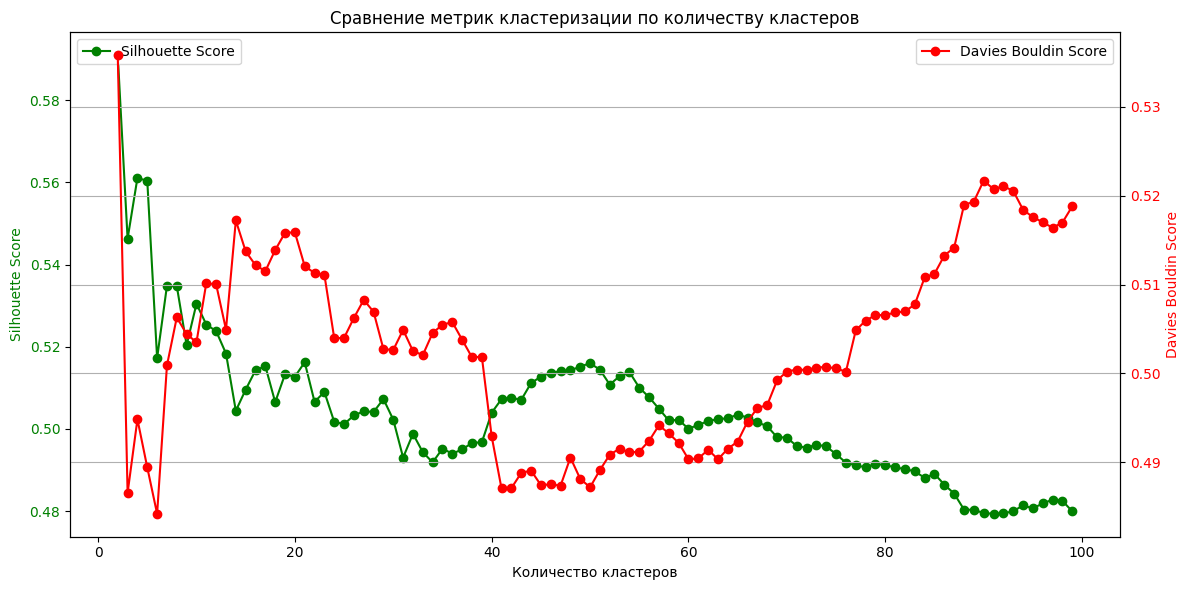

Лучшее количество кластеров по силуэтному коэффициенту: 2
Лучшее количество кластеров по Davies-Bouldin score: 6


In [121]:
silhouette_scores = []
davies_bouldin_scores = []

for n_clusters in range(2, 100):
    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    cluster_labels = agg_clustering.fit_predict(movie_data)

    silhouette_avg = silhouette_score(movie_data, cluster_labels)
    silhouette_scores.append(silhouette_avg)

    davies_bouldin_avg = davies_bouldin_score(movie_data, cluster_labels)
    davies_bouldin_scores.append(davies_bouldin_avg)


fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(range(2, 100), silhouette_scores, 'g-o', label='Silhouette Score')
ax1.set_xlabel('Количество кластеров')
ax1.set_ylabel('Silhouette Score', color='g')
ax1.tick_params(axis='y', labelcolor='g')

ax2 = ax1.twinx()
ax2.plot(range(2, 100), davies_bouldin_scores, 'r-o', label='Davies Bouldin Score')
ax2.set_ylabel('Davies Bouldin Score', color='r')
ax2.tick_params(axis='y', labelcolor='r')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title('Сравнение метрик кластеризации по количеству кластеров')
plt.grid(True)
plt.tight_layout()
plt.show()

best_n_clusters_silhouette = range(2, 100)[silhouette_scores.index(max(silhouette_scores))]
print(f"Лучшее количество кластеров по силуэтному коэффициенту: {best_n_clusters_silhouette}")

best_n_clusters_db = range(2, 100)[davies_bouldin_scores.index(min(davies_bouldin_scores))]
print(f"Лучшее количество кластеров по Davies-Bouldin score: {best_n_clusters_db}")

Silhouette Score для Ward: 0.5172050416723217


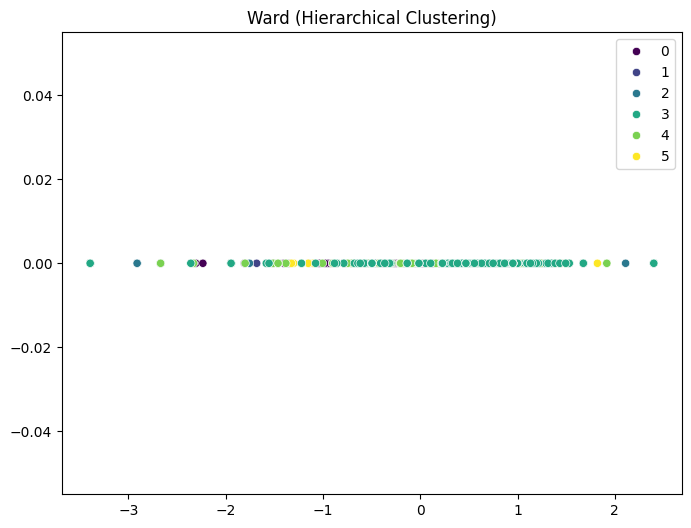

In [122]:
ward = AgglomerativeClustering(n_clusters=6, linkage='ward')
ward_labels = ward.fit_predict(movie_data)

silhouette_avg = silhouette_score(movie_data, ward_labels)
print(f"Silhouette Score для Ward: {silhouette_avg}")

plt.figure(figsize=(8, 6))
sns.scatterplot(x=movie_data_pca[:, 0], y=movie_data_pca[:, 1], hue=ward_labels, palette='viridis')
plt.title('Ward (Hierarchical Clustering)')
plt.show()

**Основные типы связи (Linkage Methods)**:
- **Ward's linkage (Ward's method)** — минимизация внутрикластерной дисперсии. Это один из самых популярных методов и заключается в том, что на каждом шаге объединяются два кластера, которые приводят к минимальному увеличению общей дисперсии (вариативности) внутри объединённых кластеров. Это обычно приводит к компактным и сферическим кластерам.
  
- **Single linkage (одиночная связь)** — кластеры сливаются, если они имеют минимальное расстояние между ближайшими точками. Этот метод может привести к "цепочечным" кластерам (long chains).

- **Complete linkage (полная связь)** — кластеры сливаются, если они имеют минимальное расстояние между самыми удалёнными точками в разных кластерах. Этот метод приводит к более компактным кластерам, чем одиночная связь.

- **Average linkage (средняя связь)** — расстояние между двумя кластерами определяется как среднее расстояние между всеми парами точек в этих кластерах.

---

### 10. **OPTICS (Ordering Points To Identify Clustering Structure)**

**Где применять:**  
- **Когда работает хорошо:** Когда нужно кластеризовать данные с переменной плотностью, и важно учитывать как глобальные, так и локальные структуры. Когда требуется обнаружить структуры с переменной плотностью, например, при кластеризации фильмов по популярности тегов в `movie_tags`, где некоторые теги имеют более высокую плотность (например, "action", "comedy").
- **Где плохо применять:** Если кластеры имеют четкую структуру и высокую плотность. Для данных с четкими и хорошо разделенными кластерами.
- **Не применять:** В случае с очень большим количеством данных, когда кластеризация должна быть быстрой.

**Тип данных:** Хорошо подходит для кластеризации с переменной плотностью и шумом, например, при анализе пользователей с разнообразными интересами. Хорошо подойдет для кластеризации фильмов с разной популярностью тегов или жанров.

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=0.5, xi=0.01, min_cluster_size=5: 0.5745094959087722
Davies Bouldin score для min_samples=5, max_eps=0.5, xi=0.01, min_cluster_size=5: 5.740177608792903
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=0.5, xi=0.01, min_cluster_size=10: 0.379656502268611
Davies Bouldin score для min_samples=5, max_eps=0.5, xi=0.01, min_cluster_size=10: 4.480312624372539
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=0.5, xi=0.01, min_cluster_size=20: 0.1674624704918178
Davies Bouldin score для min_samples=5, max_eps=0.5, xi=0.01, min_cluster_size=20: 4.164168517088879
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=0.5, xi=0.01, min_cluster_size=50: 0.042499808108764095
Davies Bouldin score для min_samples=5, max_eps=0.5, xi=0.01, min_cluster_size=50: 5.075299479866872
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=0.5, xi=0.05, min_cluster_size=5: 0.5679814528761787
Davies Bouldin score для min_samples=5, max_eps=0.5, xi=0.05, min_cluster_size=5: 5.220631700365295
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=0.5, xi=0.05, min_cluster_size=10: 0.3583959573315845
Davies Bouldin score для min_samples=5, max_eps=0.5, xi=0.05, min_cluster_size=10: 21.895684130900893
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=0.5, xi=0.05, min_cluster_size=20: 0.22969945083927817
Davies Bouldin score для min_samples=5, max_eps=0.5, xi=0.05, min_cluster_size=20: 3.158263674094213
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=0.5, xi=0.05, min_cluster_size=50: 0.041233099809725386
Davies Bouldin score для min_samples=5, max_eps=0.5, xi=0.05, min_cluster_size=50: 5.071612590572846
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=0.5, xi=0.1, min_cluster_size=5: 0.5274789535647305
Davies Bouldin score для min_samples=5, max_eps=0.5, xi=0.1, min_cluster_size=5: 6.893570068999005
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=0.5, xi=0.1, min_cluster_size=10: 0.27726322437824624
Davies Bouldin score для min_samples=5, max_eps=0.5, xi=0.1, min_cluster_size=10: 3.314289933688302
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=0.5, xi=0.1, min_cluster_size=20: 0.19165942543520303
Davies Bouldin score для min_samples=5, max_eps=0.5, xi=0.1, min_cluster_size=20: 4.948947918844924
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=0.5, xi=0.1, min_cluster_size=50: -0.09421089243590947
Davies Bouldin score для min_samples=5, max_eps=0.5, xi=0.1, min_cluster_size=50: 14.724133524525014
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=0.5, xi=0.2, min_cluster_size=5: 0.43416500391243484
Davies Bouldin score для min_samples=5, max_eps=0.5, xi=0.2, min_cluster_size=5: 4.922997665505496
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=0.5, xi=0.2, min_cluster_size=10: 0.29342647933595256
Davies Bouldin score для min_samples=5, max_eps=0.5, xi=0.2, min_cluster_size=10: 5.70525542917474
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=0.5, xi=0.2, min_cluster_size=20: 0.04179754695379295
Davies Bouldin score для min_samples=5, max_eps=0.5, xi=0.2, min_cluster_size=20: 2.411863512849738
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=0.5, xi=0.2, min_cluster_size=50: -0.2841463473066599
Davies Bouldin score для min_samples=5, max_eps=0.5, xi=0.2, min_cluster_size=50: 1.3583944385178377
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=1.0, xi=0.01, min_cluster_size=5: 0.5745094959087722
Davies Bouldin score для min_samples=5, max_eps=1.0, xi=0.01, min_cluster_size=5: 5.740177608792903
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=1.0, xi=0.01, min_cluster_size=10: 0.379656502268611
Davies Bouldin score для min_samples=5, max_eps=1.0, xi=0.01, min_cluster_size=10: 4.480312624372539
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=1.0, xi=0.01, min_cluster_size=20: 0.1674624704918178
Davies Bouldin score для min_samples=5, max_eps=1.0, xi=0.01, min_cluster_size=20: 4.164168517088879
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=1.0, xi=0.01, min_cluster_size=50: 0.042499808108764095
Davies Bouldin score для min_samples=5, max_eps=1.0, xi=0.01, min_cluster_size=50: 5.075299479866872
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=1.0, xi=0.05, min_cluster_size=5: 0.5679814528761787
Davies Bouldin score для min_samples=5, max_eps=1.0, xi=0.05, min_cluster_size=5: 5.220631700365295
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=1.0, xi=0.05, min_cluster_size=10: 0.3583959573315845
Davies Bouldin score для min_samples=5, max_eps=1.0, xi=0.05, min_cluster_size=10: 21.895684130900893
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=1.0, xi=0.05, min_cluster_size=20: 0.22969945083927817
Davies Bouldin score для min_samples=5, max_eps=1.0, xi=0.05, min_cluster_size=20: 3.158263674094213
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=1.0, xi=0.05, min_cluster_size=50: 0.041233099809725386
Davies Bouldin score для min_samples=5, max_eps=1.0, xi=0.05, min_cluster_size=50: 5.071612590572846
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=1.0, xi=0.1, min_cluster_size=5: 0.5274789535647305
Davies Bouldin score для min_samples=5, max_eps=1.0, xi=0.1, min_cluster_size=5: 6.893570068999005
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=1.0, xi=0.1, min_cluster_size=10: 0.27726322437824624
Davies Bouldin score для min_samples=5, max_eps=1.0, xi=0.1, min_cluster_size=10: 3.314289933688302
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=1.0, xi=0.1, min_cluster_size=20: 0.19165942543520303
Davies Bouldin score для min_samples=5, max_eps=1.0, xi=0.1, min_cluster_size=20: 4.948947918844924
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=1.0, xi=0.1, min_cluster_size=50: -0.09421089243590947
Davies Bouldin score для min_samples=5, max_eps=1.0, xi=0.1, min_cluster_size=50: 14.724133524525014
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=1.0, xi=0.2, min_cluster_size=5: 0.43416500391243484
Davies Bouldin score для min_samples=5, max_eps=1.0, xi=0.2, min_cluster_size=5: 4.922997665505496
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=1.0, xi=0.2, min_cluster_size=10: 0.29342647933595256
Davies Bouldin score для min_samples=5, max_eps=1.0, xi=0.2, min_cluster_size=10: 5.70525542917474
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=1.0, xi=0.2, min_cluster_size=20: 0.04179754695379295
Davies Bouldin score для min_samples=5, max_eps=1.0, xi=0.2, min_cluster_size=20: 2.411863512849738
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=1.0, xi=0.2, min_cluster_size=50: -0.2841463473066599
Davies Bouldin score для min_samples=5, max_eps=1.0, xi=0.2, min_cluster_size=50: 1.3583944385178377
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=1.5, xi=0.01, min_cluster_size=5: 0.5745094959087722
Davies Bouldin score для min_samples=5, max_eps=1.5, xi=0.01, min_cluster_size=5: 5.740177608792903
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=1.5, xi=0.01, min_cluster_size=10: 0.379656502268611
Davies Bouldin score для min_samples=5, max_eps=1.5, xi=0.01, min_cluster_size=10: 4.480312624372539
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=1.5, xi=0.01, min_cluster_size=20: 0.1674624704918178
Davies Bouldin score для min_samples=5, max_eps=1.5, xi=0.01, min_cluster_size=20: 4.164168517088879
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=1.5, xi=0.01, min_cluster_size=50: 0.042499808108764095
Davies Bouldin score для min_samples=5, max_eps=1.5, xi=0.01, min_cluster_size=50: 5.075299479866872
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=1.5, xi=0.05, min_cluster_size=5: 0.5679814528761787
Davies Bouldin score для min_samples=5, max_eps=1.5, xi=0.05, min_cluster_size=5: 5.220631700365295
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=1.5, xi=0.05, min_cluster_size=10: 0.3583959573315845
Davies Bouldin score для min_samples=5, max_eps=1.5, xi=0.05, min_cluster_size=10: 21.895684130900893
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=1.5, xi=0.05, min_cluster_size=20: 0.22969945083927817
Davies Bouldin score для min_samples=5, max_eps=1.5, xi=0.05, min_cluster_size=20: 3.158263674094213
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=1.5, xi=0.05, min_cluster_size=50: 0.041233099809725386
Davies Bouldin score для min_samples=5, max_eps=1.5, xi=0.05, min_cluster_size=50: 5.071612590572846
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=1.5, xi=0.1, min_cluster_size=5: 0.5274789535647305
Davies Bouldin score для min_samples=5, max_eps=1.5, xi=0.1, min_cluster_size=5: 6.893570068999005
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=1.5, xi=0.1, min_cluster_size=10: 0.27726322437824624
Davies Bouldin score для min_samples=5, max_eps=1.5, xi=0.1, min_cluster_size=10: 3.314289933688302
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=1.5, xi=0.1, min_cluster_size=20: 0.19165942543520303
Davies Bouldin score для min_samples=5, max_eps=1.5, xi=0.1, min_cluster_size=20: 4.948947918844924
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=1.5, xi=0.1, min_cluster_size=50: -0.09421089243590947
Davies Bouldin score для min_samples=5, max_eps=1.5, xi=0.1, min_cluster_size=50: 14.724133524525014
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=1.5, xi=0.2, min_cluster_size=5: 0.43416500391243484
Davies Bouldin score для min_samples=5, max_eps=1.5, xi=0.2, min_cluster_size=5: 4.922997665505496
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=1.5, xi=0.2, min_cluster_size=10: 0.29342647933595256
Davies Bouldin score для min_samples=5, max_eps=1.5, xi=0.2, min_cluster_size=10: 5.70525542917474
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=1.5, xi=0.2, min_cluster_size=20: 0.04179754695379295
Davies Bouldin score для min_samples=5, max_eps=1.5, xi=0.2, min_cluster_size=20: 2.411863512849738
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=1.5, xi=0.2, min_cluster_size=50: -0.2841463473066599
Davies Bouldin score для min_samples=5, max_eps=1.5, xi=0.2, min_cluster_size=50: 1.3583944385178377
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=2.0, xi=0.01, min_cluster_size=5: 0.5745094959087722
Davies Bouldin score для min_samples=5, max_eps=2.0, xi=0.01, min_cluster_size=5: 5.740177608792903
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=2.0, xi=0.01, min_cluster_size=10: 0.379656502268611
Davies Bouldin score для min_samples=5, max_eps=2.0, xi=0.01, min_cluster_size=10: 4.480312624372539
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=2.0, xi=0.01, min_cluster_size=20: 0.1674624704918178
Davies Bouldin score для min_samples=5, max_eps=2.0, xi=0.01, min_cluster_size=20: 4.164168517088879
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=2.0, xi=0.01, min_cluster_size=50: 0.042499808108764095
Davies Bouldin score для min_samples=5, max_eps=2.0, xi=0.01, min_cluster_size=50: 5.075299479866872
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=2.0, xi=0.05, min_cluster_size=5: 0.5679814528761787
Davies Bouldin score для min_samples=5, max_eps=2.0, xi=0.05, min_cluster_size=5: 5.220631700365295
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=2.0, xi=0.05, min_cluster_size=10: 0.3583959573315845
Davies Bouldin score для min_samples=5, max_eps=2.0, xi=0.05, min_cluster_size=10: 21.895684130900893
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=2.0, xi=0.05, min_cluster_size=20: 0.22969945083927817
Davies Bouldin score для min_samples=5, max_eps=2.0, xi=0.05, min_cluster_size=20: 3.158263674094213
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=2.0, xi=0.05, min_cluster_size=50: 0.041233099809725386
Davies Bouldin score для min_samples=5, max_eps=2.0, xi=0.05, min_cluster_size=50: 5.071612590572846
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=2.0, xi=0.1, min_cluster_size=5: 0.5274789535647305
Davies Bouldin score для min_samples=5, max_eps=2.0, xi=0.1, min_cluster_size=5: 6.893570068999005
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=2.0, xi=0.1, min_cluster_size=10: 0.27726322437824624
Davies Bouldin score для min_samples=5, max_eps=2.0, xi=0.1, min_cluster_size=10: 3.314289933688302
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=2.0, xi=0.1, min_cluster_size=20: 0.19165942543520303
Davies Bouldin score для min_samples=5, max_eps=2.0, xi=0.1, min_cluster_size=20: 4.948947918844924
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=2.0, xi=0.1, min_cluster_size=50: -0.09421089243590947
Davies Bouldin score для min_samples=5, max_eps=2.0, xi=0.1, min_cluster_size=50: 14.724133524525014
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=2.0, xi=0.2, min_cluster_size=5: 0.43416500391243484
Davies Bouldin score для min_samples=5, max_eps=2.0, xi=0.2, min_cluster_size=5: 4.922997665505496
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=2.0, xi=0.2, min_cluster_size=10: 0.29342647933595256
Davies Bouldin score для min_samples=5, max_eps=2.0, xi=0.2, min_cluster_size=10: 5.70525542917474
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=2.0, xi=0.2, min_cluster_size=20: 0.04179754695379295
Davies Bouldin score для min_samples=5, max_eps=2.0, xi=0.2, min_cluster_size=20: 2.411863512849738
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=2.0, xi=0.2, min_cluster_size=50: -0.2841463473066599
Davies Bouldin score для min_samples=5, max_eps=2.0, xi=0.2, min_cluster_size=50: 1.3583944385178377
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=3.0, xi=0.01, min_cluster_size=5: 0.5745094959087722
Davies Bouldin score для min_samples=5, max_eps=3.0, xi=0.01, min_cluster_size=5: 5.740177608792903
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=3.0, xi=0.01, min_cluster_size=10: 0.379656502268611
Davies Bouldin score для min_samples=5, max_eps=3.0, xi=0.01, min_cluster_size=10: 4.480312624372539
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=3.0, xi=0.01, min_cluster_size=20: 0.1674624704918178
Davies Bouldin score для min_samples=5, max_eps=3.0, xi=0.01, min_cluster_size=20: 4.164168517088879
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=3.0, xi=0.01, min_cluster_size=50: 0.042499808108764095
Davies Bouldin score для min_samples=5, max_eps=3.0, xi=0.01, min_cluster_size=50: 5.075299479866872
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=3.0, xi=0.05, min_cluster_size=5: 0.5679814528761787
Davies Bouldin score для min_samples=5, max_eps=3.0, xi=0.05, min_cluster_size=5: 5.220631700365295
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=3.0, xi=0.05, min_cluster_size=10: 0.3583959573315845
Davies Bouldin score для min_samples=5, max_eps=3.0, xi=0.05, min_cluster_size=10: 21.895684130900893
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=3.0, xi=0.05, min_cluster_size=20: 0.22969945083927817
Davies Bouldin score для min_samples=5, max_eps=3.0, xi=0.05, min_cluster_size=20: 3.158263674094213
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=3.0, xi=0.05, min_cluster_size=50: 0.041233099809725386
Davies Bouldin score для min_samples=5, max_eps=3.0, xi=0.05, min_cluster_size=50: 5.071612590572846
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=3.0, xi=0.1, min_cluster_size=5: 0.5274789535647305
Davies Bouldin score для min_samples=5, max_eps=3.0, xi=0.1, min_cluster_size=5: 6.893570068999005
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=3.0, xi=0.1, min_cluster_size=10: 0.27726322437824624
Davies Bouldin score для min_samples=5, max_eps=3.0, xi=0.1, min_cluster_size=10: 3.314289933688302
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=3.0, xi=0.1, min_cluster_size=20: 0.19165942543520303
Davies Bouldin score для min_samples=5, max_eps=3.0, xi=0.1, min_cluster_size=20: 4.948947918844924
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=3.0, xi=0.1, min_cluster_size=50: -0.09421089243590947
Davies Bouldin score для min_samples=5, max_eps=3.0, xi=0.1, min_cluster_size=50: 14.724133524525014
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=3.0, xi=0.2, min_cluster_size=5: 0.43416500391243484
Davies Bouldin score для min_samples=5, max_eps=3.0, xi=0.2, min_cluster_size=5: 4.922997665505496
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=3.0, xi=0.2, min_cluster_size=10: 0.29342647933595256
Davies Bouldin score для min_samples=5, max_eps=3.0, xi=0.2, min_cluster_size=10: 5.70525542917474
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=3.0, xi=0.2, min_cluster_size=20: 0.04179754695379295
Davies Bouldin score для min_samples=5, max_eps=3.0, xi=0.2, min_cluster_size=20: 2.411863512849738
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=5, max_eps=3.0, xi=0.2, min_cluster_size=50: -0.2841463473066599
Davies Bouldin score для min_samples=5, max_eps=3.0, xi=0.2, min_cluster_size=50: 1.3583944385178377
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=0.5, xi=0.01, min_cluster_size=5: 0.42705091723713373
Davies Bouldin score для min_samples=10, max_eps=0.5, xi=0.01, min_cluster_size=5: 4.416791861068897
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=0.5, xi=0.01, min_cluster_size=10: 0.3897006688947057
Davies Bouldin score для min_samples=10, max_eps=0.5, xi=0.01, min_cluster_size=10: 7.626225243821081
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=0.5, xi=0.01, min_cluster_size=20: 0.25424927731604086
Davies Bouldin score для min_samples=10, max_eps=0.5, xi=0.01, min_cluster_size=20: 28.621191891000706
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=0.5, xi=0.01, min_cluster_size=50: -0.05856330400244386
Davies Bouldin score для min_samples=10, max_eps=0.5, xi=0.01, min_cluster_size=50: 30.964791068447088
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=0.5, xi=0.05, min_cluster_size=5: 0.4115841230519941
Davies Bouldin score для min_samples=10, max_eps=0.5, xi=0.05, min_cluster_size=5: 4.233211635270971
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=0.5, xi=0.05, min_cluster_size=10: 0.3741745434568109
Davies Bouldin score для min_samples=10, max_eps=0.5, xi=0.05, min_cluster_size=10: 5.282755889633843
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=0.5, xi=0.05, min_cluster_size=20: 0.21258677714408852
Davies Bouldin score для min_samples=10, max_eps=0.5, xi=0.05, min_cluster_size=20: 26.62975968486629
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=0.5, xi=0.05, min_cluster_size=50: -0.15204508619154508
Davies Bouldin score для min_samples=10, max_eps=0.5, xi=0.05, min_cluster_size=50: 8.13226561022558
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=0.5, xi=0.1, min_cluster_size=5: 0.3190382545082158
Davies Bouldin score для min_samples=10, max_eps=0.5, xi=0.1, min_cluster_size=5: 12.71910303325549
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=0.5, xi=0.1, min_cluster_size=10: 0.3188952480378714
Davies Bouldin score для min_samples=10, max_eps=0.5, xi=0.1, min_cluster_size=10: 6.132926269992902
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=0.5, xi=0.1, min_cluster_size=20: 0.024688728371869393
Davies Bouldin score для min_samples=10, max_eps=0.5, xi=0.1, min_cluster_size=20: 5.481203018804096
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=0.5, xi=0.1, min_cluster_size=50: -0.15694820238311094
Davies Bouldin score для min_samples=10, max_eps=0.5, xi=0.1, min_cluster_size=50: 4.675979507937299
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=0.5, xi=0.2, min_cluster_size=5: 0.15988009867224504
Davies Bouldin score для min_samples=10, max_eps=0.5, xi=0.2, min_cluster_size=5: 5.371785617661367
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=0.5, xi=0.2, min_cluster_size=10: 0.09544957890116922
Davies Bouldin score для min_samples=10, max_eps=0.5, xi=0.2, min_cluster_size=10: 2.920653946258689
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=0.5, xi=0.2, min_cluster_size=20: -0.04756930068720205
Davies Bouldin score для min_samples=10, max_eps=0.5, xi=0.2, min_cluster_size=20: 3.8603638006531913
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=0.5, xi=0.2, min_cluster_size=50: -0.22984527923248912
Davies Bouldin score для min_samples=10, max_eps=0.5, xi=0.2, min_cluster_size=50: 1.6578977952362743
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=1.0, xi=0.01, min_cluster_size=5: 0.42705091723713373
Davies Bouldin score для min_samples=10, max_eps=1.0, xi=0.01, min_cluster_size=5: 4.416791861068897
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=1.0, xi=0.01, min_cluster_size=10: 0.3897006688947057
Davies Bouldin score для min_samples=10, max_eps=1.0, xi=0.01, min_cluster_size=10: 7.626225243821081
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=1.0, xi=0.01, min_cluster_size=20: 0.25424927731604086
Davies Bouldin score для min_samples=10, max_eps=1.0, xi=0.01, min_cluster_size=20: 28.621191891000706
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=1.0, xi=0.01, min_cluster_size=50: -0.05856330400244386
Davies Bouldin score для min_samples=10, max_eps=1.0, xi=0.01, min_cluster_size=50: 30.964791068447088
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=1.0, xi=0.05, min_cluster_size=5: 0.4115841230519941
Davies Bouldin score для min_samples=10, max_eps=1.0, xi=0.05, min_cluster_size=5: 4.233211635270971
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=1.0, xi=0.05, min_cluster_size=10: 0.3741745434568109
Davies Bouldin score для min_samples=10, max_eps=1.0, xi=0.05, min_cluster_size=10: 5.282755889633843
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=1.0, xi=0.05, min_cluster_size=20: 0.21258677714408852
Davies Bouldin score для min_samples=10, max_eps=1.0, xi=0.05, min_cluster_size=20: 26.62975968486629
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=1.0, xi=0.05, min_cluster_size=50: -0.15204508619154508
Davies Bouldin score для min_samples=10, max_eps=1.0, xi=0.05, min_cluster_size=50: 8.13226561022558
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=1.0, xi=0.1, min_cluster_size=5: 0.3190382545082158
Davies Bouldin score для min_samples=10, max_eps=1.0, xi=0.1, min_cluster_size=5: 12.71910303325549
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=1.0, xi=0.1, min_cluster_size=10: 0.3188952480378714
Davies Bouldin score для min_samples=10, max_eps=1.0, xi=0.1, min_cluster_size=10: 6.132926269992902
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=1.0, xi=0.1, min_cluster_size=20: 0.024688728371869393
Davies Bouldin score для min_samples=10, max_eps=1.0, xi=0.1, min_cluster_size=20: 5.481203018804096
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=1.0, xi=0.1, min_cluster_size=50: -0.15694820238311094
Davies Bouldin score для min_samples=10, max_eps=1.0, xi=0.1, min_cluster_size=50: 4.675979507937299
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=1.0, xi=0.2, min_cluster_size=5: 0.15657208404653006
Davies Bouldin score для min_samples=10, max_eps=1.0, xi=0.2, min_cluster_size=5: 3.741139220928229
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=1.0, xi=0.2, min_cluster_size=10: 0.0920200325246724
Davies Bouldin score для min_samples=10, max_eps=1.0, xi=0.2, min_cluster_size=10: 2.637171134794173
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=1.0, xi=0.2, min_cluster_size=20: -0.04756930068720205
Davies Bouldin score для min_samples=10, max_eps=1.0, xi=0.2, min_cluster_size=20: 3.8603638006531913
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=1.0, xi=0.2, min_cluster_size=50: -0.22984527923248912
Davies Bouldin score для min_samples=10, max_eps=1.0, xi=0.2, min_cluster_size=50: 1.6578977952362743
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=1.5, xi=0.01, min_cluster_size=5: 0.42705091723713373
Davies Bouldin score для min_samples=10, max_eps=1.5, xi=0.01, min_cluster_size=5: 4.416791861068897
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=1.5, xi=0.01, min_cluster_size=10: 0.3897006688947057
Davies Bouldin score для min_samples=10, max_eps=1.5, xi=0.01, min_cluster_size=10: 7.626225243821081
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=1.5, xi=0.01, min_cluster_size=20: 0.25424927731604086
Davies Bouldin score для min_samples=10, max_eps=1.5, xi=0.01, min_cluster_size=20: 28.621191891000706
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=1.5, xi=0.01, min_cluster_size=50: -0.05856330400244386
Davies Bouldin score для min_samples=10, max_eps=1.5, xi=0.01, min_cluster_size=50: 30.964791068447088
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=1.5, xi=0.05, min_cluster_size=5: 0.4115841230519941
Davies Bouldin score для min_samples=10, max_eps=1.5, xi=0.05, min_cluster_size=5: 4.233211635270971
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=1.5, xi=0.05, min_cluster_size=10: 0.3741745434568109
Davies Bouldin score для min_samples=10, max_eps=1.5, xi=0.05, min_cluster_size=10: 5.282755889633843
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=1.5, xi=0.05, min_cluster_size=20: 0.21258677714408852
Davies Bouldin score для min_samples=10, max_eps=1.5, xi=0.05, min_cluster_size=20: 26.62975968486629
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=1.5, xi=0.05, min_cluster_size=50: -0.15204508619154508
Davies Bouldin score для min_samples=10, max_eps=1.5, xi=0.05, min_cluster_size=50: 8.13226561022558
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=1.5, xi=0.1, min_cluster_size=5: 0.3190382545082158
Davies Bouldin score для min_samples=10, max_eps=1.5, xi=0.1, min_cluster_size=5: 12.71910303325549
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=1.5, xi=0.1, min_cluster_size=10: 0.3188952480378714
Davies Bouldin score для min_samples=10, max_eps=1.5, xi=0.1, min_cluster_size=10: 6.132926269992902
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=1.5, xi=0.1, min_cluster_size=20: 0.024688728371869393
Davies Bouldin score для min_samples=10, max_eps=1.5, xi=0.1, min_cluster_size=20: 5.481203018804096
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=1.5, xi=0.1, min_cluster_size=50: -0.15694820238311094
Davies Bouldin score для min_samples=10, max_eps=1.5, xi=0.1, min_cluster_size=50: 4.675979507937299
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=1.5, xi=0.2, min_cluster_size=5: 0.15657208404653006
Davies Bouldin score для min_samples=10, max_eps=1.5, xi=0.2, min_cluster_size=5: 3.741139220928229
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=1.5, xi=0.2, min_cluster_size=10: 0.0920200325246724
Davies Bouldin score для min_samples=10, max_eps=1.5, xi=0.2, min_cluster_size=10: 2.637171134794173
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=1.5, xi=0.2, min_cluster_size=20: -0.04756930068720205
Davies Bouldin score для min_samples=10, max_eps=1.5, xi=0.2, min_cluster_size=20: 3.8603638006531913
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=1.5, xi=0.2, min_cluster_size=50: -0.22984527923248912
Davies Bouldin score для min_samples=10, max_eps=1.5, xi=0.2, min_cluster_size=50: 1.6578977952362743
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=2.0, xi=0.01, min_cluster_size=5: 0.42705091723713373
Davies Bouldin score для min_samples=10, max_eps=2.0, xi=0.01, min_cluster_size=5: 4.416791861068897
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=2.0, xi=0.01, min_cluster_size=10: 0.3897006688947057
Davies Bouldin score для min_samples=10, max_eps=2.0, xi=0.01, min_cluster_size=10: 7.626225243821081
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=2.0, xi=0.01, min_cluster_size=20: 0.25424927731604086
Davies Bouldin score для min_samples=10, max_eps=2.0, xi=0.01, min_cluster_size=20: 28.621191891000706
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=2.0, xi=0.01, min_cluster_size=50: -0.05856330400244386
Davies Bouldin score для min_samples=10, max_eps=2.0, xi=0.01, min_cluster_size=50: 30.964791068447088
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=2.0, xi=0.05, min_cluster_size=5: 0.4115841230519941
Davies Bouldin score для min_samples=10, max_eps=2.0, xi=0.05, min_cluster_size=5: 4.233211635270971
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=2.0, xi=0.05, min_cluster_size=10: 0.3741745434568109
Davies Bouldin score для min_samples=10, max_eps=2.0, xi=0.05, min_cluster_size=10: 5.282755889633843
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=2.0, xi=0.05, min_cluster_size=20: 0.21258677714408852
Davies Bouldin score для min_samples=10, max_eps=2.0, xi=0.05, min_cluster_size=20: 26.62975968486629
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=2.0, xi=0.05, min_cluster_size=50: -0.15204508619154508
Davies Bouldin score для min_samples=10, max_eps=2.0, xi=0.05, min_cluster_size=50: 8.13226561022558
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=2.0, xi=0.1, min_cluster_size=5: 0.3190382545082158
Davies Bouldin score для min_samples=10, max_eps=2.0, xi=0.1, min_cluster_size=5: 12.71910303325549
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=2.0, xi=0.1, min_cluster_size=10: 0.3188952480378714
Davies Bouldin score для min_samples=10, max_eps=2.0, xi=0.1, min_cluster_size=10: 6.132926269992902
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=2.0, xi=0.1, min_cluster_size=20: 0.024688728371869393
Davies Bouldin score для min_samples=10, max_eps=2.0, xi=0.1, min_cluster_size=20: 5.481203018804096
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=2.0, xi=0.1, min_cluster_size=50: -0.15694820238311094
Davies Bouldin score для min_samples=10, max_eps=2.0, xi=0.1, min_cluster_size=50: 4.675979507937299
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=2.0, xi=0.2, min_cluster_size=5: 0.15657208404653006
Davies Bouldin score для min_samples=10, max_eps=2.0, xi=0.2, min_cluster_size=5: 3.741139220928229
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=2.0, xi=0.2, min_cluster_size=10: 0.0920200325246724
Davies Bouldin score для min_samples=10, max_eps=2.0, xi=0.2, min_cluster_size=10: 2.637171134794173
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=2.0, xi=0.2, min_cluster_size=20: -0.04756930068720205
Davies Bouldin score для min_samples=10, max_eps=2.0, xi=0.2, min_cluster_size=20: 3.8603638006531913
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=2.0, xi=0.2, min_cluster_size=50: -0.22984527923248912
Davies Bouldin score для min_samples=10, max_eps=2.0, xi=0.2, min_cluster_size=50: 1.6578977952362743
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=3.0, xi=0.01, min_cluster_size=5: 0.42705091723713373
Davies Bouldin score для min_samples=10, max_eps=3.0, xi=0.01, min_cluster_size=5: 4.416791861068897
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=3.0, xi=0.01, min_cluster_size=10: 0.3897006688947057
Davies Bouldin score для min_samples=10, max_eps=3.0, xi=0.01, min_cluster_size=10: 7.626225243821081
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=3.0, xi=0.01, min_cluster_size=20: 0.25424927731604086
Davies Bouldin score для min_samples=10, max_eps=3.0, xi=0.01, min_cluster_size=20: 28.621191891000706
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=3.0, xi=0.01, min_cluster_size=50: -0.05856330400244386
Davies Bouldin score для min_samples=10, max_eps=3.0, xi=0.01, min_cluster_size=50: 30.964791068447088
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=3.0, xi=0.05, min_cluster_size=5: 0.4115841230519941
Davies Bouldin score для min_samples=10, max_eps=3.0, xi=0.05, min_cluster_size=5: 4.233211635270971
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=3.0, xi=0.05, min_cluster_size=10: 0.3741745434568109
Davies Bouldin score для min_samples=10, max_eps=3.0, xi=0.05, min_cluster_size=10: 5.282755889633843
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=3.0, xi=0.05, min_cluster_size=20: 0.21258677714408852
Davies Bouldin score для min_samples=10, max_eps=3.0, xi=0.05, min_cluster_size=20: 26.62975968486629
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=3.0, xi=0.05, min_cluster_size=50: -0.15204508619154508
Davies Bouldin score для min_samples=10, max_eps=3.0, xi=0.05, min_cluster_size=50: 8.13226561022558
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=3.0, xi=0.1, min_cluster_size=5: 0.3190382545082158
Davies Bouldin score для min_samples=10, max_eps=3.0, xi=0.1, min_cluster_size=5: 12.71910303325549
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=3.0, xi=0.1, min_cluster_size=10: 0.3188952480378714
Davies Bouldin score для min_samples=10, max_eps=3.0, xi=0.1, min_cluster_size=10: 6.132926269992902
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=3.0, xi=0.1, min_cluster_size=20: 0.024688728371869393
Davies Bouldin score для min_samples=10, max_eps=3.0, xi=0.1, min_cluster_size=20: 5.481203018804096
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=3.0, xi=0.1, min_cluster_size=50: -0.15694820238311094
Davies Bouldin score для min_samples=10, max_eps=3.0, xi=0.1, min_cluster_size=50: 4.675979507937299
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=3.0, xi=0.2, min_cluster_size=5: 0.15657208404653006
Davies Bouldin score для min_samples=10, max_eps=3.0, xi=0.2, min_cluster_size=5: 3.741139220928229
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=3.0, xi=0.2, min_cluster_size=10: 0.0920200325246724
Davies Bouldin score для min_samples=10, max_eps=3.0, xi=0.2, min_cluster_size=10: 2.637171134794173
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=3.0, xi=0.2, min_cluster_size=20: -0.04756930068720205
Davies Bouldin score для min_samples=10, max_eps=3.0, xi=0.2, min_cluster_size=20: 3.8603638006531913
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=10, max_eps=3.0, xi=0.2, min_cluster_size=50: -0.22984527923248912
Davies Bouldin score для min_samples=10, max_eps=3.0, xi=0.2, min_cluster_size=50: 1.6578977952362743
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=0.5, xi=0.01, min_cluster_size=5: 0.3723309561826816
Davies Bouldin score для min_samples=15, max_eps=0.5, xi=0.01, min_cluster_size=5: 6.396478603029932
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=0.5, xi=0.01, min_cluster_size=10: 0.3374114836922716
Davies Bouldin score для min_samples=15, max_eps=0.5, xi=0.01, min_cluster_size=10: 8.319600441993304
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=0.5, xi=0.01, min_cluster_size=20: 0.3012689849613459
Davies Bouldin score для min_samples=15, max_eps=0.5, xi=0.01, min_cluster_size=20: 5.868764980738717
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=0.5, xi=0.01, min_cluster_size=50: 0.06296816392352553
Davies Bouldin score для min_samples=15, max_eps=0.5, xi=0.01, min_cluster_size=50: 6.679944134837614
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=0.5, xi=0.05, min_cluster_size=5: 0.3722430359077733
Davies Bouldin score для min_samples=15, max_eps=0.5, xi=0.05, min_cluster_size=5: 6.325283810078966
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=0.5, xi=0.05, min_cluster_size=10: 0.3568006514397504
Davies Bouldin score для min_samples=15, max_eps=0.5, xi=0.05, min_cluster_size=10: 8.73289051121477
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=0.5, xi=0.05, min_cluster_size=20: 0.2974902593543451
Davies Bouldin score для min_samples=15, max_eps=0.5, xi=0.05, min_cluster_size=20: 6.4266289110257695
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=0.5, xi=0.05, min_cluster_size=50: 0.06119632123656521
Davies Bouldin score для min_samples=15, max_eps=0.5, xi=0.05, min_cluster_size=50: 6.5655918182637665
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=0.5, xi=0.1, min_cluster_size=5: 0.2829577781419242
Davies Bouldin score для min_samples=15, max_eps=0.5, xi=0.1, min_cluster_size=5: 5.891154749933753
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=0.5, xi=0.1, min_cluster_size=10: 0.2680525315289145
Davies Bouldin score для min_samples=15, max_eps=0.5, xi=0.1, min_cluster_size=10: 4.035532021027703
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=0.5, xi=0.1, min_cluster_size=20: 0.26934081357300305
Davies Bouldin score для min_samples=15, max_eps=0.5, xi=0.1, min_cluster_size=20: 5.629265422512766
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=0.5, xi=0.1, min_cluster_size=50: -0.099104502500023
Davies Bouldin score для min_samples=15, max_eps=0.5, xi=0.1, min_cluster_size=50: 4.110450547433056
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=0.5, xi=0.2, min_cluster_size=5: -0.1125149296989054
Davies Bouldin score для min_samples=15, max_eps=0.5, xi=0.2, min_cluster_size=5: 9.088795985939097
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=0.5, xi=0.2, min_cluster_size=10: -0.1290434164786802
Davies Bouldin score для min_samples=15, max_eps=0.5, xi=0.2, min_cluster_size=10: 6.310753205923272
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=0.5, xi=0.2, min_cluster_size=20: -0.15434905185816952
Davies Bouldin score для min_samples=15, max_eps=0.5, xi=0.2, min_cluster_size=20: 14.413919190994188
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=0.5, xi=0.2, min_cluster_size=50: -0.042665359009967915
Davies Bouldin score для min_samples=15, max_eps=0.5, xi=0.2, min_cluster_size=50: 1.4146053372453873
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=1.0, xi=0.01, min_cluster_size=5: 0.38745071936036735
Davies Bouldin score для min_samples=15, max_eps=1.0, xi=0.01, min_cluster_size=5: 6.833581913432439
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=1.0, xi=0.01, min_cluster_size=10: 0.3678099402740745
Davies Bouldin score для min_samples=15, max_eps=1.0, xi=0.01, min_cluster_size=10: 6.092038613143795
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=1.0, xi=0.01, min_cluster_size=20: 0.3012689849613459
Davies Bouldin score для min_samples=15, max_eps=1.0, xi=0.01, min_cluster_size=20: 5.868764980738717
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=1.0, xi=0.01, min_cluster_size=50: 0.06296816392352553
Davies Bouldin score для min_samples=15, max_eps=1.0, xi=0.01, min_cluster_size=50: 6.679944134837614
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=1.0, xi=0.05, min_cluster_size=5: 0.3875864620973706
Davies Bouldin score для min_samples=15, max_eps=1.0, xi=0.05, min_cluster_size=5: 8.402027237642143
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=1.0, xi=0.05, min_cluster_size=10: 0.3875864620973706
Davies Bouldin score для min_samples=15, max_eps=1.0, xi=0.05, min_cluster_size=10: 8.402027237642143
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=1.0, xi=0.05, min_cluster_size=20: 0.2974902593543451
Davies Bouldin score для min_samples=15, max_eps=1.0, xi=0.05, min_cluster_size=20: 6.4266289110257695
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=1.0, xi=0.05, min_cluster_size=50: 0.06119632123656521
Davies Bouldin score для min_samples=15, max_eps=1.0, xi=0.05, min_cluster_size=50: 6.5655918182637665
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=1.0, xi=0.1, min_cluster_size=5: 0.2979389531105431
Davies Bouldin score для min_samples=15, max_eps=1.0, xi=0.1, min_cluster_size=5: 4.350932342547882
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=1.0, xi=0.1, min_cluster_size=10: 0.2979389531105431
Davies Bouldin score для min_samples=15, max_eps=1.0, xi=0.1, min_cluster_size=10: 4.350932342547882
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=1.0, xi=0.1, min_cluster_size=20: 0.26934081357300305
Davies Bouldin score для min_samples=15, max_eps=1.0, xi=0.1, min_cluster_size=20: 5.629265422512766
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=1.0, xi=0.1, min_cluster_size=50: -0.099104502500023
Davies Bouldin score для min_samples=15, max_eps=1.0, xi=0.1, min_cluster_size=50: 4.110450547433056
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=1.0, xi=0.2, min_cluster_size=5: -0.1290434164786802
Davies Bouldin score для min_samples=15, max_eps=1.0, xi=0.2, min_cluster_size=5: 6.310753205923272
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=1.0, xi=0.2, min_cluster_size=10: -0.1290434164786802
Davies Bouldin score для min_samples=15, max_eps=1.0, xi=0.2, min_cluster_size=10: 6.310753205923272
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=1.0, xi=0.2, min_cluster_size=20: -0.15434905185816952
Davies Bouldin score для min_samples=15, max_eps=1.0, xi=0.2, min_cluster_size=20: 14.413919190994188
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=1.0, xi=0.2, min_cluster_size=50: -0.042665359009967915
Davies Bouldin score для min_samples=15, max_eps=1.0, xi=0.2, min_cluster_size=50: 1.4146053372453873
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=1.5, xi=0.01, min_cluster_size=5: 0.38745071936036735
Davies Bouldin score для min_samples=15, max_eps=1.5, xi=0.01, min_cluster_size=5: 6.833581913432439
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=1.5, xi=0.01, min_cluster_size=10: 0.3678099402740745
Davies Bouldin score для min_samples=15, max_eps=1.5, xi=0.01, min_cluster_size=10: 6.092038613143795
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=1.5, xi=0.01, min_cluster_size=20: 0.3012689849613459
Davies Bouldin score для min_samples=15, max_eps=1.5, xi=0.01, min_cluster_size=20: 5.868764980738717
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=1.5, xi=0.01, min_cluster_size=50: 0.06296816392352553
Davies Bouldin score для min_samples=15, max_eps=1.5, xi=0.01, min_cluster_size=50: 6.679944134837614
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=1.5, xi=0.05, min_cluster_size=5: 0.3875864620973706
Davies Bouldin score для min_samples=15, max_eps=1.5, xi=0.05, min_cluster_size=5: 8.402027237642143
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=1.5, xi=0.05, min_cluster_size=10: 0.3875864620973706
Davies Bouldin score для min_samples=15, max_eps=1.5, xi=0.05, min_cluster_size=10: 8.402027237642143
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=1.5, xi=0.05, min_cluster_size=20: 0.2974902593543451
Davies Bouldin score для min_samples=15, max_eps=1.5, xi=0.05, min_cluster_size=20: 6.4266289110257695
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=1.5, xi=0.05, min_cluster_size=50: 0.06119632123656521
Davies Bouldin score для min_samples=15, max_eps=1.5, xi=0.05, min_cluster_size=50: 6.5655918182637665
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=1.5, xi=0.1, min_cluster_size=5: 0.2979389531105431
Davies Bouldin score для min_samples=15, max_eps=1.5, xi=0.1, min_cluster_size=5: 4.350932342547882
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=1.5, xi=0.1, min_cluster_size=10: 0.2979389531105431
Davies Bouldin score для min_samples=15, max_eps=1.5, xi=0.1, min_cluster_size=10: 4.350932342547882
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=1.5, xi=0.1, min_cluster_size=20: 0.26934081357300305
Davies Bouldin score для min_samples=15, max_eps=1.5, xi=0.1, min_cluster_size=20: 5.629265422512766
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=1.5, xi=0.1, min_cluster_size=50: -0.099104502500023
Davies Bouldin score для min_samples=15, max_eps=1.5, xi=0.1, min_cluster_size=50: 4.110450547433056
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=1.5, xi=0.2, min_cluster_size=5: -0.1290434164786802
Davies Bouldin score для min_samples=15, max_eps=1.5, xi=0.2, min_cluster_size=5: 6.310753205923272
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=1.5, xi=0.2, min_cluster_size=10: -0.1290434164786802
Davies Bouldin score для min_samples=15, max_eps=1.5, xi=0.2, min_cluster_size=10: 6.310753205923272
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=1.5, xi=0.2, min_cluster_size=20: -0.15434905185816952
Davies Bouldin score для min_samples=15, max_eps=1.5, xi=0.2, min_cluster_size=20: 14.413919190994188
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=1.5, xi=0.2, min_cluster_size=50: -0.042665359009967915
Davies Bouldin score для min_samples=15, max_eps=1.5, xi=0.2, min_cluster_size=50: 1.4146053372453873
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=2.0, xi=0.01, min_cluster_size=5: 0.38745071936036735
Davies Bouldin score для min_samples=15, max_eps=2.0, xi=0.01, min_cluster_size=5: 6.833581913432439
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=2.0, xi=0.01, min_cluster_size=10: 0.3678099402740745
Davies Bouldin score для min_samples=15, max_eps=2.0, xi=0.01, min_cluster_size=10: 6.092038613143795
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=2.0, xi=0.01, min_cluster_size=20: 0.3012689849613459
Davies Bouldin score для min_samples=15, max_eps=2.0, xi=0.01, min_cluster_size=20: 5.868764980738717
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=2.0, xi=0.01, min_cluster_size=50: 0.06296816392352553
Davies Bouldin score для min_samples=15, max_eps=2.0, xi=0.01, min_cluster_size=50: 6.679944134837614
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=2.0, xi=0.05, min_cluster_size=5: 0.3875864620973706
Davies Bouldin score для min_samples=15, max_eps=2.0, xi=0.05, min_cluster_size=5: 8.402027237642143
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=2.0, xi=0.05, min_cluster_size=10: 0.3875864620973706
Davies Bouldin score для min_samples=15, max_eps=2.0, xi=0.05, min_cluster_size=10: 8.402027237642143
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=2.0, xi=0.05, min_cluster_size=20: 0.2974902593543451
Davies Bouldin score для min_samples=15, max_eps=2.0, xi=0.05, min_cluster_size=20: 6.4266289110257695
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=2.0, xi=0.05, min_cluster_size=50: 0.06119632123656521
Davies Bouldin score для min_samples=15, max_eps=2.0, xi=0.05, min_cluster_size=50: 6.5655918182637665
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=2.0, xi=0.1, min_cluster_size=5: 0.2979389531105431
Davies Bouldin score для min_samples=15, max_eps=2.0, xi=0.1, min_cluster_size=5: 4.350932342547882
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=2.0, xi=0.1, min_cluster_size=10: 0.2979389531105431
Davies Bouldin score для min_samples=15, max_eps=2.0, xi=0.1, min_cluster_size=10: 4.350932342547882
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=2.0, xi=0.1, min_cluster_size=20: 0.26934081357300305
Davies Bouldin score для min_samples=15, max_eps=2.0, xi=0.1, min_cluster_size=20: 5.629265422512766
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=2.0, xi=0.1, min_cluster_size=50: -0.099104502500023
Davies Bouldin score для min_samples=15, max_eps=2.0, xi=0.1, min_cluster_size=50: 4.110450547433056
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=2.0, xi=0.2, min_cluster_size=5: -0.1290434164786802
Davies Bouldin score для min_samples=15, max_eps=2.0, xi=0.2, min_cluster_size=5: 6.310753205923272
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=2.0, xi=0.2, min_cluster_size=10: -0.1290434164786802
Davies Bouldin score для min_samples=15, max_eps=2.0, xi=0.2, min_cluster_size=10: 6.310753205923272
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=2.0, xi=0.2, min_cluster_size=20: -0.15434905185816952
Davies Bouldin score для min_samples=15, max_eps=2.0, xi=0.2, min_cluster_size=20: 14.413919190994188
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=2.0, xi=0.2, min_cluster_size=50: -0.042665359009967915
Davies Bouldin score для min_samples=15, max_eps=2.0, xi=0.2, min_cluster_size=50: 1.4146053372453873
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=3.0, xi=0.01, min_cluster_size=5: 0.38745071936036735
Davies Bouldin score для min_samples=15, max_eps=3.0, xi=0.01, min_cluster_size=5: 6.833581913432439
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=3.0, xi=0.01, min_cluster_size=10: 0.3678099402740745
Davies Bouldin score для min_samples=15, max_eps=3.0, xi=0.01, min_cluster_size=10: 6.092038613143795
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=3.0, xi=0.01, min_cluster_size=20: 0.3012689849613459
Davies Bouldin score для min_samples=15, max_eps=3.0, xi=0.01, min_cluster_size=20: 5.868764980738717
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=3.0, xi=0.01, min_cluster_size=50: 0.06296816392352553
Davies Bouldin score для min_samples=15, max_eps=3.0, xi=0.01, min_cluster_size=50: 6.679944134837614
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=3.0, xi=0.05, min_cluster_size=5: 0.3875864620973706
Davies Bouldin score для min_samples=15, max_eps=3.0, xi=0.05, min_cluster_size=5: 8.402027237642143
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=3.0, xi=0.05, min_cluster_size=10: 0.3875864620973706
Davies Bouldin score для min_samples=15, max_eps=3.0, xi=0.05, min_cluster_size=10: 8.402027237642143
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=3.0, xi=0.05, min_cluster_size=20: 0.2974902593543451
Davies Bouldin score для min_samples=15, max_eps=3.0, xi=0.05, min_cluster_size=20: 6.4266289110257695
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=3.0, xi=0.05, min_cluster_size=50: 0.06119632123656521
Davies Bouldin score для min_samples=15, max_eps=3.0, xi=0.05, min_cluster_size=50: 6.5655918182637665
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=3.0, xi=0.1, min_cluster_size=5: 0.2979389531105431
Davies Bouldin score для min_samples=15, max_eps=3.0, xi=0.1, min_cluster_size=5: 4.350932342547882
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=3.0, xi=0.1, min_cluster_size=10: 0.2979389531105431
Davies Bouldin score для min_samples=15, max_eps=3.0, xi=0.1, min_cluster_size=10: 4.350932342547882
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=3.0, xi=0.1, min_cluster_size=20: 0.26934081357300305
Davies Bouldin score для min_samples=15, max_eps=3.0, xi=0.1, min_cluster_size=20: 5.629265422512766
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=3.0, xi=0.1, min_cluster_size=50: -0.099104502500023
Davies Bouldin score для min_samples=15, max_eps=3.0, xi=0.1, min_cluster_size=50: 4.110450547433056
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=3.0, xi=0.2, min_cluster_size=5: -0.1290434164786802
Davies Bouldin score для min_samples=15, max_eps=3.0, xi=0.2, min_cluster_size=5: 6.310753205923272
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=3.0, xi=0.2, min_cluster_size=10: -0.1290434164786802
Davies Bouldin score для min_samples=15, max_eps=3.0, xi=0.2, min_cluster_size=10: 6.310753205923272
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=3.0, xi=0.2, min_cluster_size=20: -0.15434905185816952
Davies Bouldin score для min_samples=15, max_eps=3.0, xi=0.2, min_cluster_size=20: 14.413919190994188
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=15, max_eps=3.0, xi=0.2, min_cluster_size=50: -0.042665359009967915
Davies Bouldin score для min_samples=15, max_eps=3.0, xi=0.2, min_cluster_size=50: 1.4146053372453873
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=0.5, xi=0.01, min_cluster_size=5: 0.34899225007798157
Davies Bouldin score для min_samples=20, max_eps=0.5, xi=0.01, min_cluster_size=5: 7.303682748614579
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=0.5, xi=0.01, min_cluster_size=10: 0.3420959742343807
Davies Bouldin score для min_samples=20, max_eps=0.5, xi=0.01, min_cluster_size=10: 7.770678036420348
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=0.5, xi=0.01, min_cluster_size=20: 0.2761207005912763
Davies Bouldin score для min_samples=20, max_eps=0.5, xi=0.01, min_cluster_size=20: 5.019887656607149
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=0.5, xi=0.01, min_cluster_size=50: 0.14084329685737534
Davies Bouldin score для min_samples=20, max_eps=0.5, xi=0.01, min_cluster_size=50: 5.9948609500243455
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=0.5, xi=0.05, min_cluster_size=5: 0.2531413825265066
Davies Bouldin score для min_samples=20, max_eps=0.5, xi=0.05, min_cluster_size=5: 6.331120375394825
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=0.5, xi=0.05, min_cluster_size=10: 0.31023098147930506
Davies Bouldin score для min_samples=20, max_eps=0.5, xi=0.05, min_cluster_size=10: 147.82770752916142
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=0.5, xi=0.05, min_cluster_size=20: 0.22429439197351547
Davies Bouldin score для min_samples=20, max_eps=0.5, xi=0.05, min_cluster_size=20: 11.168132628714384
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=0.5, xi=0.05, min_cluster_size=50: 0.15628144152324272
Davies Bouldin score для min_samples=20, max_eps=0.5, xi=0.05, min_cluster_size=50: 7.315233352304994
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=0.5, xi=0.1, min_cluster_size=5: 0.23523399048311464
Davies Bouldin score для min_samples=20, max_eps=0.5, xi=0.1, min_cluster_size=5: 11.614194108551759
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=0.5, xi=0.1, min_cluster_size=10: 0.22254396248024438
Davies Bouldin score для min_samples=20, max_eps=0.5, xi=0.1, min_cluster_size=10: 6.93377238976317
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=0.5, xi=0.1, min_cluster_size=20: 0.14015585729952754
Davies Bouldin score для min_samples=20, max_eps=0.5, xi=0.1, min_cluster_size=20: 6.1376599603326545
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=0.5, xi=0.1, min_cluster_size=50: -0.057841397906080304
Davies Bouldin score для min_samples=20, max_eps=0.5, xi=0.1, min_cluster_size=50: 2.1795817098901997
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=0.5, xi=0.2, min_cluster_size=5: 0.0033468352246417603
Davies Bouldin score для min_samples=20, max_eps=0.5, xi=0.2, min_cluster_size=5: 16.94493475688943
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=0.5, xi=0.2, min_cluster_size=10: 0.0033468352246417603
Davies Bouldin score для min_samples=20, max_eps=0.5, xi=0.2, min_cluster_size=10: 16.94493475688943
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=0.5, xi=0.2, min_cluster_size=20: -0.014465648358612221
Davies Bouldin score для min_samples=20, max_eps=0.5, xi=0.2, min_cluster_size=20: 5.098967591135755
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=0.5, xi=0.2, min_cluster_size=50: -0.21321063984614333
Davies Bouldin score для min_samples=20, max_eps=0.5, xi=0.2, min_cluster_size=50: 1.9023063311523158
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=1.0, xi=0.01, min_cluster_size=5: 0.34899225007798157
Davies Bouldin score для min_samples=20, max_eps=1.0, xi=0.01, min_cluster_size=5: 7.303682748614579
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=1.0, xi=0.01, min_cluster_size=10: 0.3420959742343807
Davies Bouldin score для min_samples=20, max_eps=1.0, xi=0.01, min_cluster_size=10: 7.770678036420348
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=1.0, xi=0.01, min_cluster_size=20: 0.2761207005912763
Davies Bouldin score для min_samples=20, max_eps=1.0, xi=0.01, min_cluster_size=20: 5.019887656607149
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=1.0, xi=0.01, min_cluster_size=50: 0.14084329685737534
Davies Bouldin score для min_samples=20, max_eps=1.0, xi=0.01, min_cluster_size=50: 5.9948609500243455
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=1.0, xi=0.05, min_cluster_size=5: 0.2531413825265066
Davies Bouldin score для min_samples=20, max_eps=1.0, xi=0.05, min_cluster_size=5: 6.331120375394825
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=1.0, xi=0.05, min_cluster_size=10: 0.31023098147930506
Davies Bouldin score для min_samples=20, max_eps=1.0, xi=0.05, min_cluster_size=10: 147.82770752916142
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=1.0, xi=0.05, min_cluster_size=20: 0.22429439197351547
Davies Bouldin score для min_samples=20, max_eps=1.0, xi=0.05, min_cluster_size=20: 11.168132628714384
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=1.0, xi=0.05, min_cluster_size=50: 0.15628144152324272
Davies Bouldin score для min_samples=20, max_eps=1.0, xi=0.05, min_cluster_size=50: 7.315233352304994
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=1.0, xi=0.1, min_cluster_size=5: 0.23523399048311464
Davies Bouldin score для min_samples=20, max_eps=1.0, xi=0.1, min_cluster_size=5: 11.614194108551759
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=1.0, xi=0.1, min_cluster_size=10: 0.22254396248024438
Davies Bouldin score для min_samples=20, max_eps=1.0, xi=0.1, min_cluster_size=10: 6.93377238976317
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=1.0, xi=0.1, min_cluster_size=20: 0.14015585729952754
Davies Bouldin score для min_samples=20, max_eps=1.0, xi=0.1, min_cluster_size=20: 6.1376599603326545
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=1.0, xi=0.1, min_cluster_size=50: -0.057841397906080304
Davies Bouldin score для min_samples=20, max_eps=1.0, xi=0.1, min_cluster_size=50: 2.1795817098901997
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=1.0, xi=0.2, min_cluster_size=5: 0.0033468352246417603
Davies Bouldin score для min_samples=20, max_eps=1.0, xi=0.2, min_cluster_size=5: 16.94493475688943
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=1.0, xi=0.2, min_cluster_size=10: 0.0033468352246417603
Davies Bouldin score для min_samples=20, max_eps=1.0, xi=0.2, min_cluster_size=10: 16.94493475688943
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=1.0, xi=0.2, min_cluster_size=20: -0.014465648358612221
Davies Bouldin score для min_samples=20, max_eps=1.0, xi=0.2, min_cluster_size=20: 5.098967591135755
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=1.0, xi=0.2, min_cluster_size=50: -0.21321063984614333
Davies Bouldin score для min_samples=20, max_eps=1.0, xi=0.2, min_cluster_size=50: 1.9023063311523158
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=1.5, xi=0.01, min_cluster_size=5: 0.34899225007798157
Davies Bouldin score для min_samples=20, max_eps=1.5, xi=0.01, min_cluster_size=5: 7.303682748614579
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=1.5, xi=0.01, min_cluster_size=10: 0.3420959742343807
Davies Bouldin score для min_samples=20, max_eps=1.5, xi=0.01, min_cluster_size=10: 7.770678036420348
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=1.5, xi=0.01, min_cluster_size=20: 0.2761207005912763
Davies Bouldin score для min_samples=20, max_eps=1.5, xi=0.01, min_cluster_size=20: 5.019887656607149
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=1.5, xi=0.01, min_cluster_size=50: 0.14084329685737534
Davies Bouldin score для min_samples=20, max_eps=1.5, xi=0.01, min_cluster_size=50: 5.9948609500243455
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=1.5, xi=0.05, min_cluster_size=5: 0.2531413825265066
Davies Bouldin score для min_samples=20, max_eps=1.5, xi=0.05, min_cluster_size=5: 6.331120375394825
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=1.5, xi=0.05, min_cluster_size=10: 0.31023098147930506
Davies Bouldin score для min_samples=20, max_eps=1.5, xi=0.05, min_cluster_size=10: 147.82770752916142
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=1.5, xi=0.05, min_cluster_size=20: 0.22429439197351547
Davies Bouldin score для min_samples=20, max_eps=1.5, xi=0.05, min_cluster_size=20: 11.168132628714384
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=1.5, xi=0.05, min_cluster_size=50: 0.15628144152324272
Davies Bouldin score для min_samples=20, max_eps=1.5, xi=0.05, min_cluster_size=50: 7.315233352304994
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=1.5, xi=0.1, min_cluster_size=5: 0.23523399048311464
Davies Bouldin score для min_samples=20, max_eps=1.5, xi=0.1, min_cluster_size=5: 11.614194108551759
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=1.5, xi=0.1, min_cluster_size=10: 0.22254396248024438
Davies Bouldin score для min_samples=20, max_eps=1.5, xi=0.1, min_cluster_size=10: 6.93377238976317
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=1.5, xi=0.1, min_cluster_size=20: 0.14015585729952754
Davies Bouldin score для min_samples=20, max_eps=1.5, xi=0.1, min_cluster_size=20: 6.1376599603326545
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=1.5, xi=0.1, min_cluster_size=50: -0.057841397906080304
Davies Bouldin score для min_samples=20, max_eps=1.5, xi=0.1, min_cluster_size=50: 2.1795817098901997
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=1.5, xi=0.2, min_cluster_size=5: 0.0033468352246417603
Davies Bouldin score для min_samples=20, max_eps=1.5, xi=0.2, min_cluster_size=5: 16.94493475688943
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=1.5, xi=0.2, min_cluster_size=10: 0.0033468352246417603
Davies Bouldin score для min_samples=20, max_eps=1.5, xi=0.2, min_cluster_size=10: 16.94493475688943
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=1.5, xi=0.2, min_cluster_size=20: -0.014465648358612221
Davies Bouldin score для min_samples=20, max_eps=1.5, xi=0.2, min_cluster_size=20: 5.098967591135755
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=1.5, xi=0.2, min_cluster_size=50: -0.21321063984614333
Davies Bouldin score для min_samples=20, max_eps=1.5, xi=0.2, min_cluster_size=50: 1.9023063311523158
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=2.0, xi=0.01, min_cluster_size=5: 0.34899225007798157
Davies Bouldin score для min_samples=20, max_eps=2.0, xi=0.01, min_cluster_size=5: 7.303682748614579
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=2.0, xi=0.01, min_cluster_size=10: 0.3420959742343807
Davies Bouldin score для min_samples=20, max_eps=2.0, xi=0.01, min_cluster_size=10: 7.770678036420348
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=2.0, xi=0.01, min_cluster_size=20: 0.2761207005912763
Davies Bouldin score для min_samples=20, max_eps=2.0, xi=0.01, min_cluster_size=20: 5.019887656607149
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=2.0, xi=0.01, min_cluster_size=50: 0.14084329685737534
Davies Bouldin score для min_samples=20, max_eps=2.0, xi=0.01, min_cluster_size=50: 5.9948609500243455
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=2.0, xi=0.05, min_cluster_size=5: 0.2531413825265066
Davies Bouldin score для min_samples=20, max_eps=2.0, xi=0.05, min_cluster_size=5: 6.331120375394825
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=2.0, xi=0.05, min_cluster_size=10: 0.31023098147930506
Davies Bouldin score для min_samples=20, max_eps=2.0, xi=0.05, min_cluster_size=10: 147.82770752916142
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=2.0, xi=0.05, min_cluster_size=20: 0.22429439197351547
Davies Bouldin score для min_samples=20, max_eps=2.0, xi=0.05, min_cluster_size=20: 11.168132628714384
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=2.0, xi=0.05, min_cluster_size=50: 0.15628144152324272
Davies Bouldin score для min_samples=20, max_eps=2.0, xi=0.05, min_cluster_size=50: 7.315233352304994
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=2.0, xi=0.1, min_cluster_size=5: 0.23523399048311464
Davies Bouldin score для min_samples=20, max_eps=2.0, xi=0.1, min_cluster_size=5: 11.614194108551759
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=2.0, xi=0.1, min_cluster_size=10: 0.22254396248024438
Davies Bouldin score для min_samples=20, max_eps=2.0, xi=0.1, min_cluster_size=10: 6.93377238976317
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=2.0, xi=0.1, min_cluster_size=20: 0.14015585729952754
Davies Bouldin score для min_samples=20, max_eps=2.0, xi=0.1, min_cluster_size=20: 6.1376599603326545
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=2.0, xi=0.1, min_cluster_size=50: -0.057841397906080304
Davies Bouldin score для min_samples=20, max_eps=2.0, xi=0.1, min_cluster_size=50: 2.1795817098901997
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=2.0, xi=0.2, min_cluster_size=5: 0.0033468352246417603
Davies Bouldin score для min_samples=20, max_eps=2.0, xi=0.2, min_cluster_size=5: 16.94493475688943
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=2.0, xi=0.2, min_cluster_size=10: 0.0033468352246417603
Davies Bouldin score для min_samples=20, max_eps=2.0, xi=0.2, min_cluster_size=10: 16.94493475688943
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=2.0, xi=0.2, min_cluster_size=20: -0.014465648358612221
Davies Bouldin score для min_samples=20, max_eps=2.0, xi=0.2, min_cluster_size=20: 5.098967591135755
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=2.0, xi=0.2, min_cluster_size=50: -0.21321063984614333
Davies Bouldin score для min_samples=20, max_eps=2.0, xi=0.2, min_cluster_size=50: 1.9023063311523158
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=3.0, xi=0.01, min_cluster_size=5: 0.34899225007798157
Davies Bouldin score для min_samples=20, max_eps=3.0, xi=0.01, min_cluster_size=5: 7.303682748614579
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=3.0, xi=0.01, min_cluster_size=10: 0.3420959742343807
Davies Bouldin score для min_samples=20, max_eps=3.0, xi=0.01, min_cluster_size=10: 7.770678036420348
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=3.0, xi=0.01, min_cluster_size=20: 0.2761207005912763
Davies Bouldin score для min_samples=20, max_eps=3.0, xi=0.01, min_cluster_size=20: 5.019887656607149
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=3.0, xi=0.01, min_cluster_size=50: 0.14084329685737534
Davies Bouldin score для min_samples=20, max_eps=3.0, xi=0.01, min_cluster_size=50: 5.9948609500243455
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=3.0, xi=0.05, min_cluster_size=5: 0.2531413825265066
Davies Bouldin score для min_samples=20, max_eps=3.0, xi=0.05, min_cluster_size=5: 6.331120375394825
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=3.0, xi=0.05, min_cluster_size=10: 0.31023098147930506
Davies Bouldin score для min_samples=20, max_eps=3.0, xi=0.05, min_cluster_size=10: 147.82770752916142
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=3.0, xi=0.05, min_cluster_size=20: 0.22429439197351547
Davies Bouldin score для min_samples=20, max_eps=3.0, xi=0.05, min_cluster_size=20: 11.168132628714384
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=3.0, xi=0.05, min_cluster_size=50: 0.15628144152324272
Davies Bouldin score для min_samples=20, max_eps=3.0, xi=0.05, min_cluster_size=50: 7.315233352304994
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=3.0, xi=0.1, min_cluster_size=5: 0.23523399048311464
Davies Bouldin score для min_samples=20, max_eps=3.0, xi=0.1, min_cluster_size=5: 11.614194108551759
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=3.0, xi=0.1, min_cluster_size=10: 0.22254396248024438
Davies Bouldin score для min_samples=20, max_eps=3.0, xi=0.1, min_cluster_size=10: 6.93377238976317
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=3.0, xi=0.1, min_cluster_size=20: 0.14015585729952754
Davies Bouldin score для min_samples=20, max_eps=3.0, xi=0.1, min_cluster_size=20: 6.1376599603326545
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=3.0, xi=0.1, min_cluster_size=50: -0.057841397906080304
Davies Bouldin score для min_samples=20, max_eps=3.0, xi=0.1, min_cluster_size=50: 2.1795817098901997
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=3.0, xi=0.2, min_cluster_size=5: 0.0033468352246417603
Davies Bouldin score для min_samples=20, max_eps=3.0, xi=0.2, min_cluster_size=5: 16.94493475688943
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=3.0, xi=0.2, min_cluster_size=10: 0.0033468352246417603
Davies Bouldin score для min_samples=20, max_eps=3.0, xi=0.2, min_cluster_size=10: 16.94493475688943
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=3.0, xi=0.2, min_cluster_size=20: -0.014465648358612221
Davies Bouldin score для min_samples=20, max_eps=3.0, xi=0.2, min_cluster_size=20: 5.098967591135755
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=20, max_eps=3.0, xi=0.2, min_cluster_size=50: -0.21321063984614333
Davies Bouldin score для min_samples=20, max_eps=3.0, xi=0.2, min_cluster_size=50: 1.9023063311523158
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=0.5, xi=0.01, min_cluster_size=5: 0.21893349894713732
Davies Bouldin score для min_samples=30, max_eps=0.5, xi=0.01, min_cluster_size=5: 5.791714332732327
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=0.5, xi=0.01, min_cluster_size=10: 0.21698275669954228
Davies Bouldin score для min_samples=30, max_eps=0.5, xi=0.01, min_cluster_size=10: 5.61992830826278
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=0.5, xi=0.01, min_cluster_size=20: 0.14885508263204744
Davies Bouldin score для min_samples=30, max_eps=0.5, xi=0.01, min_cluster_size=20: 24.20913299195595
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=0.5, xi=0.01, min_cluster_size=50: 0.05519290115230672
Davies Bouldin score для min_samples=30, max_eps=0.5, xi=0.01, min_cluster_size=50: 3.6923508327856585
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=0.5, xi=0.05, min_cluster_size=5: 0.03638648788203959
Davies Bouldin score для min_samples=30, max_eps=0.5, xi=0.05, min_cluster_size=5: 4.704465029946615
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=0.5, xi=0.05, min_cluster_size=10: 0.037469249889575854
Davies Bouldin score для min_samples=30, max_eps=0.5, xi=0.05, min_cluster_size=10: 4.67548419211461
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=0.5, xi=0.05, min_cluster_size=20: 0.037469249889575854
Davies Bouldin score для min_samples=30, max_eps=0.5, xi=0.05, min_cluster_size=20: 4.67548419211461
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=0.5, xi=0.05, min_cluster_size=50: -0.030235612766523423
Davies Bouldin score для min_samples=30, max_eps=0.5, xi=0.05, min_cluster_size=50: 2.2158180976863777
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=0.5, xi=0.1, min_cluster_size=5: -0.11562761399508488
Davies Bouldin score для min_samples=30, max_eps=0.5, xi=0.1, min_cluster_size=5: 4.300236574719394
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=0.5, xi=0.1, min_cluster_size=10: -0.11139710106286603
Davies Bouldin score для min_samples=30, max_eps=0.5, xi=0.1, min_cluster_size=10: 4.2002226911990475
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=0.5, xi=0.1, min_cluster_size=20: -0.11139710106286603
Davies Bouldin score для min_samples=30, max_eps=0.5, xi=0.1, min_cluster_size=20: 4.2002226911990475
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=0.5, xi=0.1, min_cluster_size=50: -0.15196190698608644
Davies Bouldin score для min_samples=30, max_eps=0.5, xi=0.1, min_cluster_size=50: 2.469119354165832
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=0.5, xi=0.2, min_cluster_size=5: -0.32393323412503844
Davies Bouldin score для min_samples=30, max_eps=0.5, xi=0.2, min_cluster_size=5: 2.1506603861570666
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=0.5, xi=0.2, min_cluster_size=10: -0.32393323412503844
Davies Bouldin score для min_samples=30, max_eps=0.5, xi=0.2, min_cluster_size=10: 2.1506603861570666
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=0.5, xi=0.2, min_cluster_size=20: -0.32393323412503844
Davies Bouldin score для min_samples=30, max_eps=0.5, xi=0.2, min_cluster_size=20: 2.1506603861570666
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=0.5, xi=0.2, min_cluster_size=50: -0.064601125588487
Davies Bouldin score для min_samples=30, max_eps=0.5, xi=0.2, min_cluster_size=50: 1.4298830432253171
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=1.0, xi=0.01, min_cluster_size=5: 0.21893349894713732
Davies Bouldin score для min_samples=30, max_eps=1.0, xi=0.01, min_cluster_size=5: 5.791714332732327
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=1.0, xi=0.01, min_cluster_size=10: 0.21698275669954228
Davies Bouldin score для min_samples=30, max_eps=1.0, xi=0.01, min_cluster_size=10: 5.61992830826278
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=1.0, xi=0.01, min_cluster_size=20: 0.14885508263204744
Davies Bouldin score для min_samples=30, max_eps=1.0, xi=0.01, min_cluster_size=20: 24.20913299195595
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=1.0, xi=0.01, min_cluster_size=50: 0.05519290115230672
Davies Bouldin score для min_samples=30, max_eps=1.0, xi=0.01, min_cluster_size=50: 3.6923508327856585
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=1.0, xi=0.05, min_cluster_size=5: 0.03638648788203959
Davies Bouldin score для min_samples=30, max_eps=1.0, xi=0.05, min_cluster_size=5: 4.704465029946615
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=1.0, xi=0.05, min_cluster_size=10: 0.037469249889575854
Davies Bouldin score для min_samples=30, max_eps=1.0, xi=0.05, min_cluster_size=10: 4.67548419211461
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=1.0, xi=0.05, min_cluster_size=20: 0.037469249889575854
Davies Bouldin score для min_samples=30, max_eps=1.0, xi=0.05, min_cluster_size=20: 4.67548419211461
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=1.0, xi=0.05, min_cluster_size=50: -0.030235612766523423
Davies Bouldin score для min_samples=30, max_eps=1.0, xi=0.05, min_cluster_size=50: 2.2158180976863777
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=1.0, xi=0.1, min_cluster_size=5: -0.11562761399508488
Davies Bouldin score для min_samples=30, max_eps=1.0, xi=0.1, min_cluster_size=5: 4.300236574719394
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=1.0, xi=0.1, min_cluster_size=10: -0.11139710106286603
Davies Bouldin score для min_samples=30, max_eps=1.0, xi=0.1, min_cluster_size=10: 4.2002226911990475
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=1.0, xi=0.1, min_cluster_size=20: -0.11139710106286603
Davies Bouldin score для min_samples=30, max_eps=1.0, xi=0.1, min_cluster_size=20: 4.2002226911990475
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=1.0, xi=0.1, min_cluster_size=50: -0.15196190698608644
Davies Bouldin score для min_samples=30, max_eps=1.0, xi=0.1, min_cluster_size=50: 2.469119354165832
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=1.0, xi=0.2, min_cluster_size=5: -0.32393323412503844
Davies Bouldin score для min_samples=30, max_eps=1.0, xi=0.2, min_cluster_size=5: 2.1506603861570666
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=1.0, xi=0.2, min_cluster_size=10: -0.32393323412503844
Davies Bouldin score для min_samples=30, max_eps=1.0, xi=0.2, min_cluster_size=10: 2.1506603861570666
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=1.0, xi=0.2, min_cluster_size=20: -0.32393323412503844
Davies Bouldin score для min_samples=30, max_eps=1.0, xi=0.2, min_cluster_size=20: 2.1506603861570666
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=1.0, xi=0.2, min_cluster_size=50: -0.064601125588487
Davies Bouldin score для min_samples=30, max_eps=1.0, xi=0.2, min_cluster_size=50: 1.4298830432253171
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=1.5, xi=0.01, min_cluster_size=5: 0.21893349894713732
Davies Bouldin score для min_samples=30, max_eps=1.5, xi=0.01, min_cluster_size=5: 5.791714332732327
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=1.5, xi=0.01, min_cluster_size=10: 0.21698275669954228
Davies Bouldin score для min_samples=30, max_eps=1.5, xi=0.01, min_cluster_size=10: 5.61992830826278
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=1.5, xi=0.01, min_cluster_size=20: 0.14885508263204744
Davies Bouldin score для min_samples=30, max_eps=1.5, xi=0.01, min_cluster_size=20: 24.20913299195595
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=1.5, xi=0.01, min_cluster_size=50: 0.05519290115230672
Davies Bouldin score для min_samples=30, max_eps=1.5, xi=0.01, min_cluster_size=50: 3.6923508327856585
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=1.5, xi=0.05, min_cluster_size=5: 0.03638648788203959
Davies Bouldin score для min_samples=30, max_eps=1.5, xi=0.05, min_cluster_size=5: 4.704465029946615
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=1.5, xi=0.05, min_cluster_size=10: 0.037469249889575854
Davies Bouldin score для min_samples=30, max_eps=1.5, xi=0.05, min_cluster_size=10: 4.67548419211461
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=1.5, xi=0.05, min_cluster_size=20: 0.037469249889575854
Davies Bouldin score для min_samples=30, max_eps=1.5, xi=0.05, min_cluster_size=20: 4.67548419211461
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=1.5, xi=0.05, min_cluster_size=50: -0.030235612766523423
Davies Bouldin score для min_samples=30, max_eps=1.5, xi=0.05, min_cluster_size=50: 2.2158180976863777
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=1.5, xi=0.1, min_cluster_size=5: -0.11562761399508488
Davies Bouldin score для min_samples=30, max_eps=1.5, xi=0.1, min_cluster_size=5: 4.300236574719394
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=1.5, xi=0.1, min_cluster_size=10: -0.11139710106286603
Davies Bouldin score для min_samples=30, max_eps=1.5, xi=0.1, min_cluster_size=10: 4.2002226911990475
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=1.5, xi=0.1, min_cluster_size=20: -0.11139710106286603
Davies Bouldin score для min_samples=30, max_eps=1.5, xi=0.1, min_cluster_size=20: 4.2002226911990475
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=1.5, xi=0.1, min_cluster_size=50: -0.15196190698608644
Davies Bouldin score для min_samples=30, max_eps=1.5, xi=0.1, min_cluster_size=50: 2.469119354165832
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=1.5, xi=0.2, min_cluster_size=5: -0.32393323412503844
Davies Bouldin score для min_samples=30, max_eps=1.5, xi=0.2, min_cluster_size=5: 2.1506603861570666
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=1.5, xi=0.2, min_cluster_size=10: -0.32393323412503844
Davies Bouldin score для min_samples=30, max_eps=1.5, xi=0.2, min_cluster_size=10: 2.1506603861570666
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=1.5, xi=0.2, min_cluster_size=20: -0.32393323412503844
Davies Bouldin score для min_samples=30, max_eps=1.5, xi=0.2, min_cluster_size=20: 2.1506603861570666
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=1.5, xi=0.2, min_cluster_size=50: -0.064601125588487
Davies Bouldin score для min_samples=30, max_eps=1.5, xi=0.2, min_cluster_size=50: 1.4298830432253171
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=2.0, xi=0.01, min_cluster_size=5: 0.21893349894713732
Davies Bouldin score для min_samples=30, max_eps=2.0, xi=0.01, min_cluster_size=5: 5.791714332732327
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=2.0, xi=0.01, min_cluster_size=10: 0.21698275669954228
Davies Bouldin score для min_samples=30, max_eps=2.0, xi=0.01, min_cluster_size=10: 5.61992830826278
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=2.0, xi=0.01, min_cluster_size=20: 0.14885508263204744
Davies Bouldin score для min_samples=30, max_eps=2.0, xi=0.01, min_cluster_size=20: 24.20913299195595
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=2.0, xi=0.01, min_cluster_size=50: 0.05519290115230672
Davies Bouldin score для min_samples=30, max_eps=2.0, xi=0.01, min_cluster_size=50: 3.6923508327856585
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=2.0, xi=0.05, min_cluster_size=5: 0.03638648788203959
Davies Bouldin score для min_samples=30, max_eps=2.0, xi=0.05, min_cluster_size=5: 4.704465029946615
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=2.0, xi=0.05, min_cluster_size=10: 0.037469249889575854
Davies Bouldin score для min_samples=30, max_eps=2.0, xi=0.05, min_cluster_size=10: 4.67548419211461
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=2.0, xi=0.05, min_cluster_size=20: 0.037469249889575854
Davies Bouldin score для min_samples=30, max_eps=2.0, xi=0.05, min_cluster_size=20: 4.67548419211461
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=2.0, xi=0.05, min_cluster_size=50: -0.030235612766523423
Davies Bouldin score для min_samples=30, max_eps=2.0, xi=0.05, min_cluster_size=50: 2.2158180976863777
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=2.0, xi=0.1, min_cluster_size=5: -0.11562761399508488
Davies Bouldin score для min_samples=30, max_eps=2.0, xi=0.1, min_cluster_size=5: 4.300236574719394
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=2.0, xi=0.1, min_cluster_size=10: -0.11139710106286603
Davies Bouldin score для min_samples=30, max_eps=2.0, xi=0.1, min_cluster_size=10: 4.2002226911990475
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=2.0, xi=0.1, min_cluster_size=20: -0.11139710106286603
Davies Bouldin score для min_samples=30, max_eps=2.0, xi=0.1, min_cluster_size=20: 4.2002226911990475
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=2.0, xi=0.1, min_cluster_size=50: -0.15196190698608644
Davies Bouldin score для min_samples=30, max_eps=2.0, xi=0.1, min_cluster_size=50: 2.469119354165832
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=2.0, xi=0.2, min_cluster_size=5: -0.32393323412503844
Davies Bouldin score для min_samples=30, max_eps=2.0, xi=0.2, min_cluster_size=5: 2.1506603861570666
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=2.0, xi=0.2, min_cluster_size=10: -0.32393323412503844
Davies Bouldin score для min_samples=30, max_eps=2.0, xi=0.2, min_cluster_size=10: 2.1506603861570666
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=2.0, xi=0.2, min_cluster_size=20: -0.32393323412503844
Davies Bouldin score для min_samples=30, max_eps=2.0, xi=0.2, min_cluster_size=20: 2.1506603861570666
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=2.0, xi=0.2, min_cluster_size=50: -0.064601125588487
Davies Bouldin score для min_samples=30, max_eps=2.0, xi=0.2, min_cluster_size=50: 1.4298830432253171
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=3.0, xi=0.01, min_cluster_size=5: 0.21893349894713732
Davies Bouldin score для min_samples=30, max_eps=3.0, xi=0.01, min_cluster_size=5: 5.791714332732327
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=3.0, xi=0.01, min_cluster_size=10: 0.21698275669954228
Davies Bouldin score для min_samples=30, max_eps=3.0, xi=0.01, min_cluster_size=10: 5.61992830826278
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=3.0, xi=0.01, min_cluster_size=20: 0.14885508263204744
Davies Bouldin score для min_samples=30, max_eps=3.0, xi=0.01, min_cluster_size=20: 24.20913299195595
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=3.0, xi=0.01, min_cluster_size=50: 0.05519290115230672
Davies Bouldin score для min_samples=30, max_eps=3.0, xi=0.01, min_cluster_size=50: 3.6923508327856585
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=3.0, xi=0.05, min_cluster_size=5: 0.03638648788203959
Davies Bouldin score для min_samples=30, max_eps=3.0, xi=0.05, min_cluster_size=5: 4.704465029946615
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=3.0, xi=0.05, min_cluster_size=10: 0.037469249889575854
Davies Bouldin score для min_samples=30, max_eps=3.0, xi=0.05, min_cluster_size=10: 4.67548419211461
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=3.0, xi=0.05, min_cluster_size=20: 0.037469249889575854
Davies Bouldin score для min_samples=30, max_eps=3.0, xi=0.05, min_cluster_size=20: 4.67548419211461
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=3.0, xi=0.05, min_cluster_size=50: -0.030235612766523423
Davies Bouldin score для min_samples=30, max_eps=3.0, xi=0.05, min_cluster_size=50: 2.2158180976863777
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=3.0, xi=0.1, min_cluster_size=5: -0.11562761399508488
Davies Bouldin score для min_samples=30, max_eps=3.0, xi=0.1, min_cluster_size=5: 4.300236574719394
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=3.0, xi=0.1, min_cluster_size=10: -0.11139710106286603
Davies Bouldin score для min_samples=30, max_eps=3.0, xi=0.1, min_cluster_size=10: 4.2002226911990475
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=3.0, xi=0.1, min_cluster_size=20: -0.11139710106286603
Davies Bouldin score для min_samples=30, max_eps=3.0, xi=0.1, min_cluster_size=20: 4.2002226911990475
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=3.0, xi=0.1, min_cluster_size=50: -0.15196190698608644
Davies Bouldin score для min_samples=30, max_eps=3.0, xi=0.1, min_cluster_size=50: 2.469119354165832
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=3.0, xi=0.2, min_cluster_size=5: -0.32393323412503844
Davies Bouldin score для min_samples=30, max_eps=3.0, xi=0.2, min_cluster_size=5: 2.1506603861570666
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=3.0, xi=0.2, min_cluster_size=10: -0.32393323412503844
Davies Bouldin score для min_samples=30, max_eps=3.0, xi=0.2, min_cluster_size=10: 2.1506603861570666
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=3.0, xi=0.2, min_cluster_size=20: -0.32393323412503844
Davies Bouldin score для min_samples=30, max_eps=3.0, xi=0.2, min_cluster_size=20: 2.1506603861570666
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette score для min_samples=30, max_eps=3.0, xi=0.2, min_cluster_size=50: -0.064601125588487
Davies Bouldin score для min_samples=30, max_eps=3.0, xi=0.2, min_cluster_size=50: 1.4298830432253171
------------------------------------------------------------------


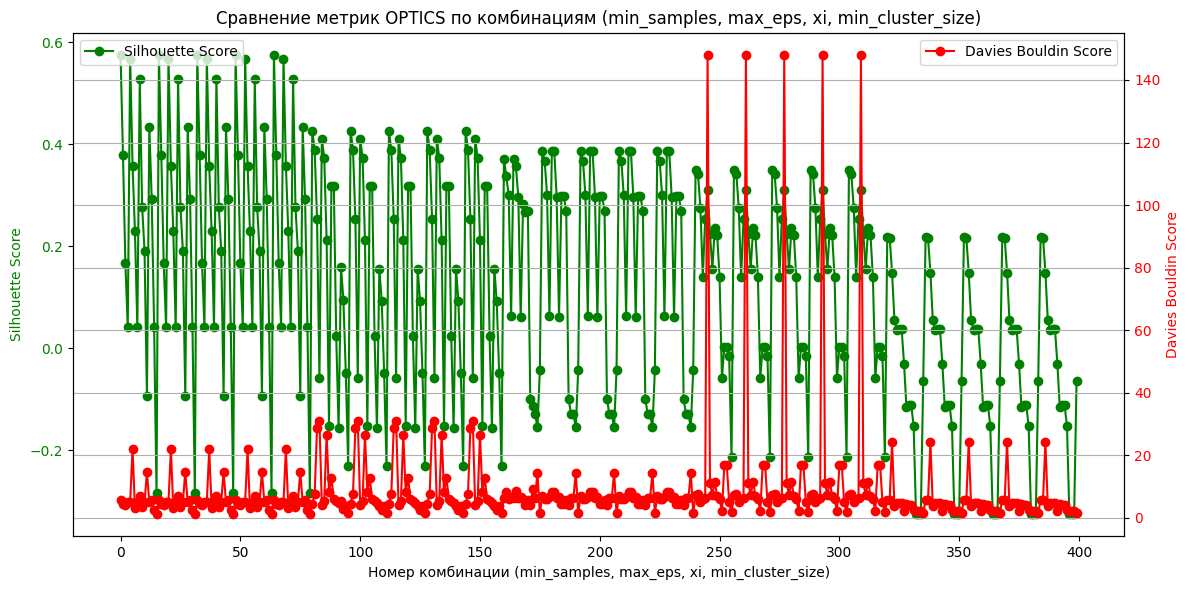

Лучшее сочетание параметров по силуэтному коэффициенту: min_samples=5, max_eps=0.5, xi=0.01, min_cluster_size=5
Лучшее сочетание параметров по Davies-Bouldin score: min_samples=5, max_eps=0.5, xi=0.2, min_cluster_size=50


In [127]:
silhouette_scores = []
davies_bouldin_scores = []

min_samples_values = [5, 10, 15, 20, 30]
max_eps_values = [0.5, 1.0, 1.5, 2.0, 3.0]
xi_values = [0.01, 0.05, 0.1, 0.2]
min_cluster_size_values = [5, 10, 20, 50]

for min_samples in min_samples_values:
    for max_eps in max_eps_values:
        for xi in xi_values:
            for min_cluster_size in min_cluster_size_values:
                try:
                    optics = OPTICS(min_samples=min_samples,
                                    max_eps=max_eps,
                                    xi=xi,
                                    min_cluster_size=min_cluster_size)
                    cluster_labels = optics.fit_predict(movie_data_scaled)

                    if len(set(cluster_labels)) > 1:
                        silhouette_avg = silhouette_score(movie_data_scaled, cluster_labels)
                        silhouette_scores.append(silhouette_avg)
                        print(f"Silhouette score для min_samples={min_samples}, max_eps={max_eps}, xi={xi}, min_cluster_size={min_cluster_size}: {silhouette_avg}")

                        davies_bouldin_avg = davies_bouldin_score(movie_data_scaled, cluster_labels)
                        davies_bouldin_scores.append(davies_bouldin_avg)
                        print(f"Davies Bouldin score для min_samples={min_samples}, max_eps={max_eps}, xi={xi}, min_cluster_size={min_cluster_size}: {davies_bouldin_avg}")
                    else:
                        print(f"Недостаточно кластеров для min_samples={min_samples}, max_eps={max_eps}, xi={xi}, min_cluster_size={min_cluster_size}")

                except Exception as e:
                    print(f"Ошибка с min_samples={min_samples}, max_eps={max_eps}, xi={xi}, min_cluster_size={min_cluster_size}: {e}")
                    continue

                print("------------------------------------------------------------------")


fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(range(len(silhouette_scores)), silhouette_scores, 'g-o', label='Silhouette Score')
ax1.set_xlabel('Номер комбинации (min_samples, max_eps, xi, min_cluster_size)')
ax1.set_ylabel('Silhouette Score', color='g')
ax1.tick_params(axis='y', labelcolor='g')

ax2 = ax1.twinx()
ax2.plot(range(len(davies_bouldin_scores)), davies_bouldin_scores, 'r-o', label='Davies Bouldin Score')
ax2.set_ylabel('Davies Bouldin Score', color='r')
ax2.tick_params(axis='y', labelcolor='r')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title('Сравнение метрик OPTICS по комбинациям (min_samples, max_eps, xi, min_cluster_size)')
plt.grid(True)
plt.tight_layout()
plt.show()

param_combinations = [(min_samples, max_eps, xi, min_cluster_size) for min_samples in min_samples_values
                      for max_eps in max_eps_values
                      for xi in xi_values
                      for min_cluster_size in min_cluster_size_values]

best_combination_silhouette = param_combinations[silhouette_scores.index(max(silhouette_scores))]
print(f"Лучшее сочетание параметров по силуэтному коэффициенту: min_samples={best_combination_silhouette[0]}, max_eps={best_combination_silhouette[1]}, xi={best_combination_silhouette[2]}, min_cluster_size={best_combination_silhouette[3]}")

best_combination_db = param_combinations[davies_bouldin_scores.index(min(davies_bouldin_scores))]
print(f"Лучшее сочетание параметров по Davies-Bouldin score: min_samples={best_combination_db[0]}, max_eps={best_combination_db[1]}, xi={best_combination_db[2]}, min_cluster_size={best_combination_db[3]}")

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Silhouette Score для OPTICS: 0.5745094959087722


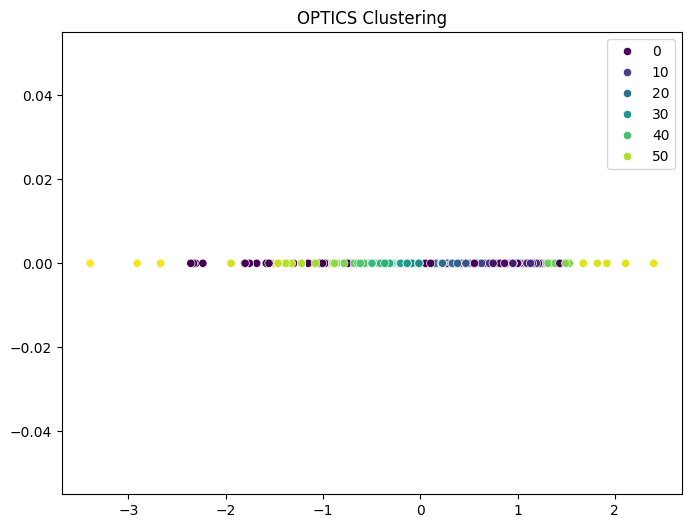

In [128]:
optics = OPTICS(min_samples=5, xi=0.01, min_cluster_size=5, max_eps=0.5)
optics_labels = optics.fit_predict(movie_data_scaled)

silhouette_avg = silhouette_score(movie_data_scaled, optics_labels)
print(f"Silhouette Score для OPTICS: {silhouette_avg}")

plt.figure(figsize=(8, 6))
sns.scatterplot(x=movie_data_pca[:, 0], y=movie_data_pca[:, 1], hue=optics_labels, palette='viridis')
plt.title('OPTICS Clustering')
plt.show()

---

### 11. **BIRCH (Balanced Iterative Reducing and Clustering using Hierarchies)**

**Где применять:**  
- **Когда работает хорошо:** Для кластеризации больших данных, где важна скорость и эффективность. Хорошо работает для кластеризации в реальном времени и на больших объемах данных.
- **Где плохо применять:** Если кластеры имеют сложную форму или сильно различаются по плотности, например, если фильмов слишком много с большим количеством редких тегов.
- **Не применять:** Когда кластеризация должна быть очень точной и требуются четкие группы.

**Тип данных:** Большие наборы данных, например, для рекомендаций на основе поведения пользователей. Для кластеризации фильмов с большим количеством тегов из `movie_tags` или для создания кластеров пользователей по их оценкам из `ratings`.

Silhouette score для n_clusters=2, threshold=0.1, branching_factor=30: 0.6158422418334276
Davies Bouldin score для n_clusters=2, threshold=0.1, branching_factor=30: 0.464084805574186
------------------------------------------------------------------
Silhouette score для n_clusters=2, threshold=0.1, branching_factor=40: 0.6158422418334276
Davies Bouldin score для n_clusters=2, threshold=0.1, branching_factor=40: 0.464084805574186
------------------------------------------------------------------
Silhouette score для n_clusters=2, threshold=0.1, branching_factor=50: 0.6158422418334276
Davies Bouldin score для n_clusters=2, threshold=0.1, branching_factor=50: 0.464084805574186
------------------------------------------------------------------
Silhouette score для n_clusters=2, threshold=0.1, branching_factor=60: 0.6158422418334276
Davies Bouldin score для n_clusters=2, threshold=0.1, branching_factor=60: 0.464084805574186
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_birch.py:727: ConvergenceWarning: Number of subclusters found (6) by BIRCH is less than (7). Decrease the threshold.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_birch.py:727: ConvergenceWarning: Number of subclusters found (6) by BIRCH is less than (7). Decrease the threshold.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_birch.py:727: ConvergenceWarning: Number of subclusters found (6) by BIRCH is less than (7). Decrease the threshold.
  warnings.warn(


Silhouette score для n_clusters=7, threshold=0.5, branching_factor=40: 0.5527789642841591
Davies Bouldin score для n_clusters=7, threshold=0.5, branching_factor=40: 0.4866881547132975
------------------------------------------------------------------
Silhouette score для n_clusters=7, threshold=0.5, branching_factor=50: 0.5527789642841591
Davies Bouldin score для n_clusters=7, threshold=0.5, branching_factor=50: 0.4866881547132975
------------------------------------------------------------------
Silhouette score для n_clusters=7, threshold=0.5, branching_factor=60: 0.5527789642841591
Davies Bouldin score для n_clusters=7, threshold=0.5, branching_factor=60: 0.4866881547132975
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_birch.py:727: ConvergenceWarning: Number of subclusters found (6) by BIRCH is less than (7). Decrease the threshold.
  warnings.warn(


Silhouette score для n_clusters=8, threshold=0.1, branching_factor=30: 0.5803927531822848
Davies Bouldin score для n_clusters=8, threshold=0.1, branching_factor=30: 0.41509402747122986
------------------------------------------------------------------
Silhouette score для n_clusters=8, threshold=0.1, branching_factor=40: 0.5803927531822848
Davies Bouldin score для n_clusters=8, threshold=0.1, branching_factor=40: 0.41509402747122986
------------------------------------------------------------------
Silhouette score для n_clusters=8, threshold=0.1, branching_factor=50: 0.5803927531822848
Davies Bouldin score для n_clusters=8, threshold=0.1, branching_factor=50: 0.41509402747122986
------------------------------------------------------------------
Silhouette score для n_clusters=8, threshold=0.1, branching_factor=60: 0.5803927531822848
Davies Bouldin score для n_clusters=8, threshold=0.1, branching_factor=60: 0.41509402747122986
-----------------------------------------------------------

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_birch.py:727: ConvergenceWarning: Number of subclusters found (6) by BIRCH is less than (8). Decrease the threshold.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_birch.py:727: ConvergenceWarning: Number of subclusters found (6) by BIRCH is less than (8). Decrease the threshold.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_birch.py:727: ConvergenceWarning: Number of subclusters found (6) by BIRCH is less than (8). Decrease the threshold.
  warnings.warn(


Silhouette score для n_clusters=8, threshold=0.5, branching_factor=30: 0.5527789642841591
Davies Bouldin score для n_clusters=8, threshold=0.5, branching_factor=30: 0.4866881547132975
------------------------------------------------------------------
Silhouette score для n_clusters=8, threshold=0.5, branching_factor=40: 0.5527789642841591
Davies Bouldin score для n_clusters=8, threshold=0.5, branching_factor=40: 0.4866881547132975
------------------------------------------------------------------
Silhouette score для n_clusters=8, threshold=0.5, branching_factor=50: 0.5527789642841591
Davies Bouldin score для n_clusters=8, threshold=0.5, branching_factor=50: 0.4866881547132975
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_birch.py:727: ConvergenceWarning: Number of subclusters found (6) by BIRCH is less than (8). Decrease the threshold.
  warnings.warn(


Silhouette score для n_clusters=8, threshold=0.5, branching_factor=60: 0.5527789642841591
Davies Bouldin score для n_clusters=8, threshold=0.5, branching_factor=60: 0.4866881547132975
------------------------------------------------------------------
Silhouette score для n_clusters=9, threshold=0.1, branching_factor=30: 0.577254351487258
Davies Bouldin score для n_clusters=9, threshold=0.1, branching_factor=30: 0.36486570955458836
------------------------------------------------------------------
Silhouette score для n_clusters=9, threshold=0.1, branching_factor=40: 0.577254351487258
Davies Bouldin score для n_clusters=9, threshold=0.1, branching_factor=40: 0.36486570955458836
------------------------------------------------------------------
Silhouette score для n_clusters=9, threshold=0.1, branching_factor=50: 0.577254351487258
Davies Bouldin score для n_clusters=9, threshold=0.1, branching_factor=50: 0.36486570955458836
---------------------------------------------------------------

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_birch.py:727: ConvergenceWarning: Number of subclusters found (8) by BIRCH is less than (9). Decrease the threshold.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_birch.py:727: ConvergenceWarning: Number of subclusters found (8) by BIRCH is less than (9). Decrease the threshold.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_birch.py:727: ConvergenceWarning: Number of subclusters found (8) by BIRCH is less than (9). Decrease the threshold.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_birch.py:727: ConvergenceWarning: Number of subclusters found (8) by BIRCH is less than (9). Decrease the threshold.
  warnings.warn(


Silhouette score для n_clusters=9, threshold=0.3, branching_factor=60: 0.5313881110438955
Davies Bouldin score для n_clusters=9, threshold=0.3, branching_factor=60: 0.4929356577010512
------------------------------------------------------------------
Silhouette score для n_clusters=9, threshold=0.4, branching_factor=30: 0.5306220385492755
Davies Bouldin score для n_clusters=9, threshold=0.4, branching_factor=30: 0.4215524924345371
------------------------------------------------------------------
Silhouette score для n_clusters=9, threshold=0.4, branching_factor=40: 0.5306220385492755
Davies Bouldin score для n_clusters=9, threshold=0.4, branching_factor=40: 0.4215524924345371
------------------------------------------------------------------
Silhouette score для n_clusters=9, threshold=0.4, branching_factor=50: 0.5306220385492755
Davies Bouldin score для n_clusters=9, threshold=0.4, branching_factor=50: 0.4215524924345371
---------------------------------------------------------------

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_birch.py:727: ConvergenceWarning: Number of subclusters found (6) by BIRCH is less than (9). Decrease the threshold.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_birch.py:727: ConvergenceWarning: Number of subclusters found (6) by BIRCH is less than (9). Decrease the threshold.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_birch.py:727: ConvergenceWarning: Number of subclusters found (6) by BIRCH is less than (9). Decrease the threshold.
  warnings.warn(


Silhouette score для n_clusters=9, threshold=0.5, branching_factor=50: 0.5527789642841591
Davies Bouldin score для n_clusters=9, threshold=0.5, branching_factor=50: 0.4866881547132975
------------------------------------------------------------------
Silhouette score для n_clusters=9, threshold=0.5, branching_factor=60: 0.5527789642841591
Davies Bouldin score для n_clusters=9, threshold=0.5, branching_factor=60: 0.4866881547132975
------------------------------------------------------------------
Silhouette score для n_clusters=10, threshold=0.1, branching_factor=30: 0.5696774121271382
Davies Bouldin score для n_clusters=10, threshold=0.1, branching_factor=30: 0.3636847704282947
------------------------------------------------------------------
Silhouette score для n_clusters=10, threshold=0.1, branching_factor=40: 0.5696774121271382
Davies Bouldin score для n_clusters=10, threshold=0.1, branching_factor=40: 0.3636847704282947
-----------------------------------------------------------

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_birch.py:727: ConvergenceWarning: Number of subclusters found (6) by BIRCH is less than (9). Decrease the threshold.
  warnings.warn(


Silhouette score для n_clusters=10, threshold=0.1, branching_factor=50: 0.5696774121271382
Davies Bouldin score для n_clusters=10, threshold=0.1, branching_factor=50: 0.3636847704282947
------------------------------------------------------------------
Silhouette score для n_clusters=10, threshold=0.1, branching_factor=60: 0.5696774121271382
Davies Bouldin score для n_clusters=10, threshold=0.1, branching_factor=60: 0.3636847704282947
------------------------------------------------------------------
Silhouette score для n_clusters=10, threshold=0.2, branching_factor=30: 0.5648995882437816
Davies Bouldin score для n_clusters=10, threshold=0.2, branching_factor=30: 0.3911618004381947
------------------------------------------------------------------
Silhouette score для n_clusters=10, threshold=0.2, branching_factor=40: 0.5648995882437816
Davies Bouldin score для n_clusters=10, threshold=0.2, branching_factor=40: 0.3911618004381947
-------------------------------------------------------

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_birch.py:727: ConvergenceWarning: Number of subclusters found (8) by BIRCH is less than (10). Decrease the threshold.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_birch.py:727: ConvergenceWarning: Number of subclusters found (8) by BIRCH is less than (10). Decrease the threshold.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_birch.py:727: ConvergenceWarning: Number of subclusters found (8) by BIRCH is less than (10). Decrease the threshold.
  warnings.warn(


Silhouette score для n_clusters=10, threshold=0.3, branching_factor=40: 0.5313881110438955
Davies Bouldin score для n_clusters=10, threshold=0.3, branching_factor=40: 0.4929356577010512
------------------------------------------------------------------
Silhouette score для n_clusters=10, threshold=0.3, branching_factor=50: 0.5313881110438955
Davies Bouldin score для n_clusters=10, threshold=0.3, branching_factor=50: 0.4929356577010512
------------------------------------------------------------------
Silhouette score для n_clusters=10, threshold=0.3, branching_factor=60: 0.5313881110438955
Davies Bouldin score для n_clusters=10, threshold=0.3, branching_factor=60: 0.4929356577010512
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_birch.py:727: ConvergenceWarning: Number of subclusters found (8) by BIRCH is less than (10). Decrease the threshold.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_birch.py:727: ConvergenceWarning: Number of subclusters found (9) by BIRCH is less than (10). Decrease the threshold.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_birch.py:727: ConvergenceWarning: Number of subclusters found (9) by BIRCH is less than (10). Decrease the threshold.
  warnings.warn(


Silhouette score для n_clusters=10, threshold=0.4, branching_factor=30: 0.5306220385492755
Davies Bouldin score для n_clusters=10, threshold=0.4, branching_factor=30: 0.42155249243453713
------------------------------------------------------------------
Silhouette score для n_clusters=10, threshold=0.4, branching_factor=40: 0.5306220385492755
Davies Bouldin score для n_clusters=10, threshold=0.4, branching_factor=40: 0.42155249243453713
------------------------------------------------------------------
Silhouette score для n_clusters=10, threshold=0.4, branching_factor=50: 0.5306220385492755
Davies Bouldin score для n_clusters=10, threshold=0.4, branching_factor=50: 0.42155249243453713
------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_birch.py:727: ConvergenceWarning: Number of subclusters found (9) by BIRCH is less than (10). Decrease the threshold.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_birch.py:727: ConvergenceWarning: Number of subclusters found (9) by BIRCH is less than (10). Decrease the threshold.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_birch.py:727: ConvergenceWarning: Number of subclusters found (6) by BIRCH is less than (10). Decrease the threshold.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_birch.py:727: ConvergenceWarning: Number of subclusters found (6) by BIRCH is less than (10). Decrease the threshold.
  warnings.warn(


Silhouette score для n_clusters=10, threshold=0.4, branching_factor=60: 0.5306220385492755
Davies Bouldin score для n_clusters=10, threshold=0.4, branching_factor=60: 0.42155249243453713
------------------------------------------------------------------
Silhouette score для n_clusters=10, threshold=0.5, branching_factor=30: 0.5527789642841591
Davies Bouldin score для n_clusters=10, threshold=0.5, branching_factor=30: 0.4866881547132975
------------------------------------------------------------------
Silhouette score для n_clusters=10, threshold=0.5, branching_factor=40: 0.5527789642841591
Davies Bouldin score для n_clusters=10, threshold=0.5, branching_factor=40: 0.4866881547132975
------------------------------------------------------------------
Silhouette score для n_clusters=10, threshold=0.5, branching_factor=50: 0.5527789642841591
Davies Bouldin score для n_clusters=10, threshold=0.5, branching_factor=50: 0.4866881547132975
------------------------------------------------------

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_birch.py:727: ConvergenceWarning: Number of subclusters found (6) by BIRCH is less than (10). Decrease the threshold.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_birch.py:727: ConvergenceWarning: Number of subclusters found (6) by BIRCH is less than (10). Decrease the threshold.
  warnings.warn(


Silhouette score для n_clusters=10, threshold=0.5, branching_factor=60: 0.5527789642841591
Davies Bouldin score для n_clusters=10, threshold=0.5, branching_factor=60: 0.4866881547132975
------------------------------------------------------------------


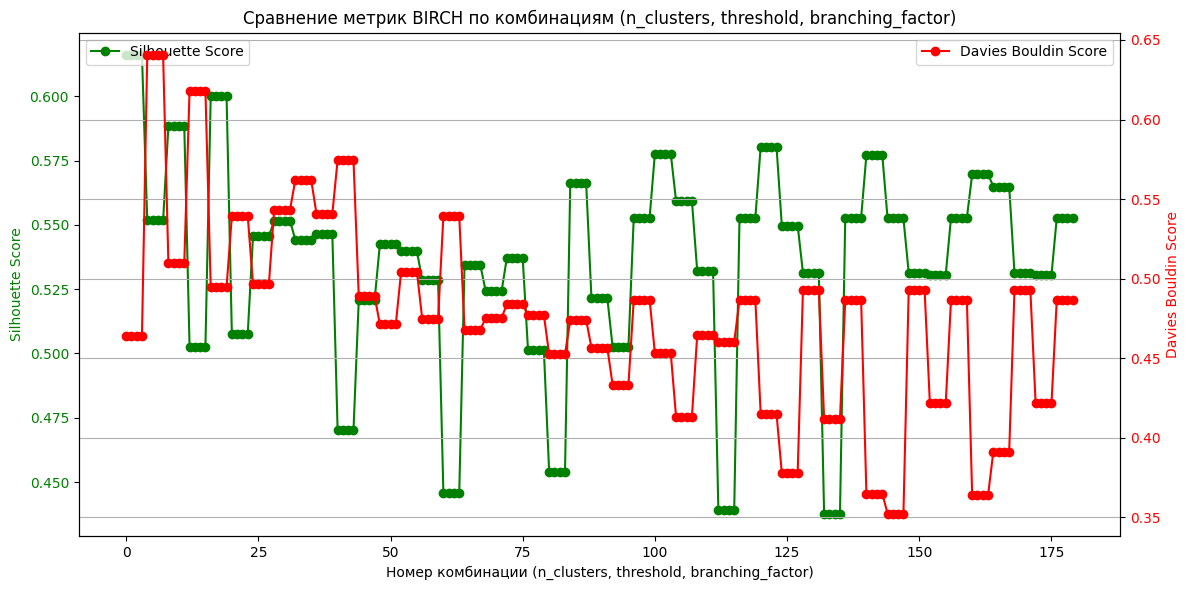

Лучшее сочетание параметров по силуэтному коэффициенту: n_clusters=2, threshold=0.1, branching_factor=30
Лучшее сочетание параметров по Davies-Bouldin score: n_clusters=9, threshold=0.2, branching_factor=30


In [134]:
silhouette_scores = []
davies_bouldin_scores = []

n_clusters_values = [2, 3, 4, 5, 6, 7, 8, 9, 10]
threshold_values = [0.1, 0.2, 0.3, 0.4, 0.5]
branching_factor_values = [30, 40, 50, 60]

for n_clusters in n_clusters_values:
    for threshold in threshold_values:
        for branching_factor in branching_factor_values:
            try:
                birch = Birch(n_clusters=n_clusters,
                              threshold=threshold,
                              branching_factor=branching_factor)
                cluster_labels = birch.fit_predict(movie_data_scaled)

                if len(set(cluster_labels)) > 1:
                    silhouette_avg = silhouette_score(movie_data_scaled, cluster_labels)
                    silhouette_scores.append(silhouette_avg)
                    print(f"Silhouette score для n_clusters={n_clusters}, threshold={threshold}, branching_factor={branching_factor}: {silhouette_avg}")

                    davies_bouldin_avg = davies_bouldin_score(movie_data_scaled, cluster_labels)
                    davies_bouldin_scores.append(davies_bouldin_avg)
                    print(f"Davies Bouldin score для n_clusters={n_clusters}, threshold={threshold}, branching_factor={branching_factor}: {davies_bouldin_avg}")
                else:
                    print(f"Недостаточно кластеров для n_clusters={n_clusters}, threshold={threshold}, branching_factor={branching_factor}")

            except Exception as e:
                print(f"Ошибка с n_clusters={n_clusters}, threshold={threshold}, branching_factor={branching_factor}: {e}")
                continue

            print("------------------------------------------------------------------")


fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(range(len(silhouette_scores)), silhouette_scores, 'g-o', label='Silhouette Score')
ax1.set_xlabel('Номер комбинации (n_clusters, threshold, branching_factor)')
ax1.set_ylabel('Silhouette Score', color='g')
ax1.tick_params(axis='y', labelcolor='g')

ax2 = ax1.twinx()
ax2.plot(range(len(davies_bouldin_scores)), davies_bouldin_scores, 'r-o', label='Davies Bouldin Score')
ax2.set_ylabel('Davies Bouldin Score', color='r')
ax2.tick_params(axis='y', labelcolor='r')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title('Сравнение метрик BIRCH по комбинациям (n_clusters, threshold, branching_factor)')
plt.grid(True)
plt.tight_layout()
plt.show()

param_combinations = [(n_clusters, threshold, branching_factor) for n_clusters in n_clusters_values
                      for threshold in threshold_values
                      for branching_factor in branching_factor_values]

best_combination_silhouette = param_combinations[silhouette_scores.index(max(silhouette_scores))]
print(f"Лучшее сочетание параметров по силуэтному коэффициенту: n_clusters={best_combination_silhouette[0]}, threshold={best_combination_silhouette[1]}, branching_factor={best_combination_silhouette[2]}")

best_combination_db = param_combinations[davies_bouldin_scores.index(min(davies_bouldin_scores))]
print(f"Лучшее сочетание параметров по Davies-Bouldin score: n_clusters={best_combination_db[0]}, threshold={best_combination_db[1]}, branching_factor={best_combination_db[2]}")

Silhouette Score для BIRCH: 0.5524931798169755


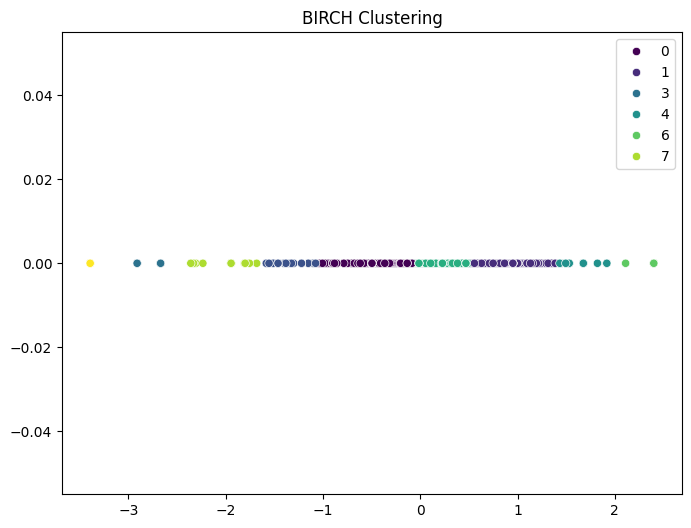

In [135]:
birch = Birch(n_clusters=9, threshold=0.2, branching_factor=30)
birch_labels = birch.fit_predict(movie_data_scaled)

silhouette_avg = silhouette_score(movie_data_scaled, birch_labels)
print(f"Silhouette Score для BIRCH: {silhouette_avg}")

plt.figure(figsize=(8, 6))
sns.scatterplot(x=movie_data_pca[:, 0], y=movie_data_pca[:, 1], hue=birch_labels, palette='viridis')
plt.title('BIRCH Clustering')
plt.show()

### Заключение:
Для рекомендательных систем выбор метода кластеризации зависит от множества факторов, включая тип данных, размер набора, необходимость учитывать шум, сложность иерархических структур и другие особенности. Например:

- Для кластеризации **пользователей с разными интересами** лучше подойдут **DBSCAN** или **HDBSCAN**, которые хорошо работают с шумом и переменной плотностью.
- Для рекомендательных систем, где кластеры **имеют четкие границы и сходство между объектами можно выразить числово**, подойдет **K-means**.
- **Для работы с графами и сложными зависимостями** лучше использовать **Spectral Clustering**.
- Для кластеризации **фильмов по жанрам и тегам**: подойдут методы, такие как **K-means**, **Agglomerative Clustering** и **Ward**, если требуется выделить четкие категории.
- Для кластеризации **с учетом плотности и редких тегов**: лучше использовать **DBSCAN**, **HDBSCAN** или **OPTICS**.
- Для кластеризации **пользователей по их оценкам**: методы вроде **Gaussian Mixture Model (GMM)** или **K-means** могут быть полезны, если пользователи имеют схожие предпочтения.